# Jitter

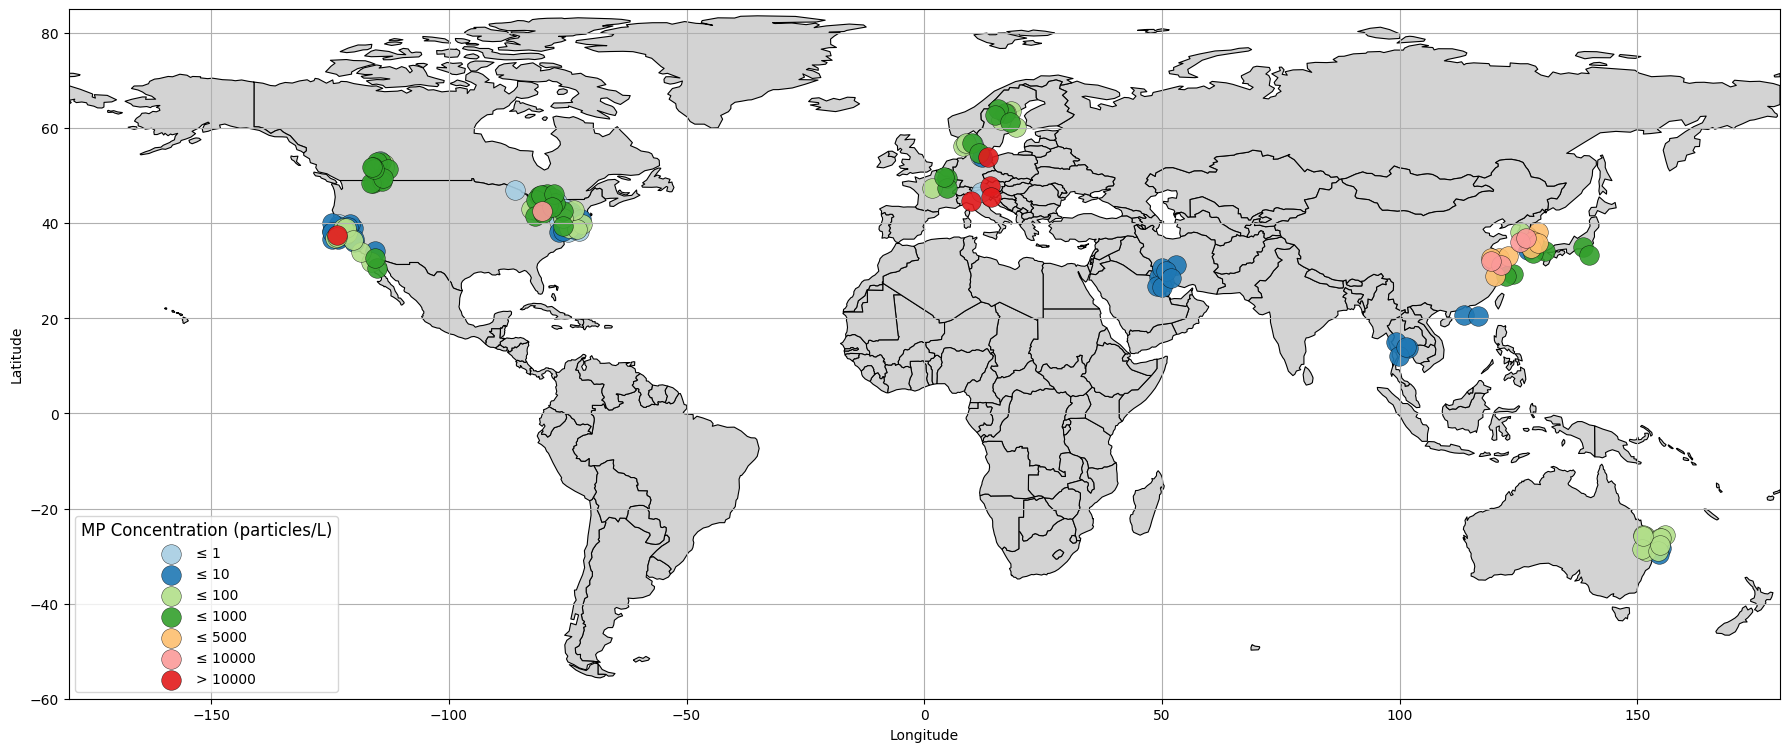

In [84]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the Excel file
df = pd.read_excel("Urban Runoff MP Database_072025.xlsx", sheet_name="Urban Runoff MP Database")

# Drop rows missing concentration or coordinates
df = df.dropna(subset=["Standardized Concentration (particles/L)", "Decimal Latitude", "Decimal Longitude"])

# Define bins and corresponding labels and colors
bins = [0, 1, 10, 100, 1000, 5000, 10000, 20000]
labels = ['≤ 1', '≤ 10', '≤ 100', '≤ 1000', '≤ 5000', '≤ 10000', '> 10000']
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fdbf6f', '#fb9a99', '#e31a1c']
color_map = dict(zip(labels, colors))


# Assign bin labels
df["MP_bin"] = pd.cut(df["Standardized Concentration (particles/L)"], bins=bins, labels=labels, include_lowest=True)

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df["Decimal Longitude"], df["Decimal Latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load the world shapefile (local stable version)
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world[world["NAME"] != "Antarctica"]

# Plot
fig, ax = plt.subplots(figsize=(18, 10))
world.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=.8)

import numpy as np

# Add jitter (displacement)
np.random.seed(42)
jitter_strength = 2.5  # degrees (~30 km)
gdf["Longitude_jittered"] = gdf.geometry.x + np.random.uniform(-jitter_strength, jitter_strength, size=len(gdf))
gdf["Latitude_jittered"] = gdf.geometry.y + np.random.uniform(-jitter_strength, jitter_strength, size=len(gdf))
gdf["geometry"] = [Point(xy) for xy in zip(gdf["Longitude_jittered"], gdf["Latitude_jittered"])]


# Plot each bin category
for label in labels:
    subset = gdf[gdf["MP_bin"] == label]
    if not subset.empty:
        subset.plot(
            ax=ax,
            markersize=200,
            color=color_map[label],
            label=label,
            edgecolor="black",
            linewidth=0.3,
            alpha=0.9
        )

# Final map settings
#ax.set_title("Abundance of Microplastics in Urban Runoff Sampling Sites", fontsize=18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 85)
ax.set_aspect("equal")
ax.grid(True)
ax.legend(title="MP Concentration (particles/L)", loc="lower left", fontsize="medium", title_fontsize="large")

plt.tight_layout()
plt.show()


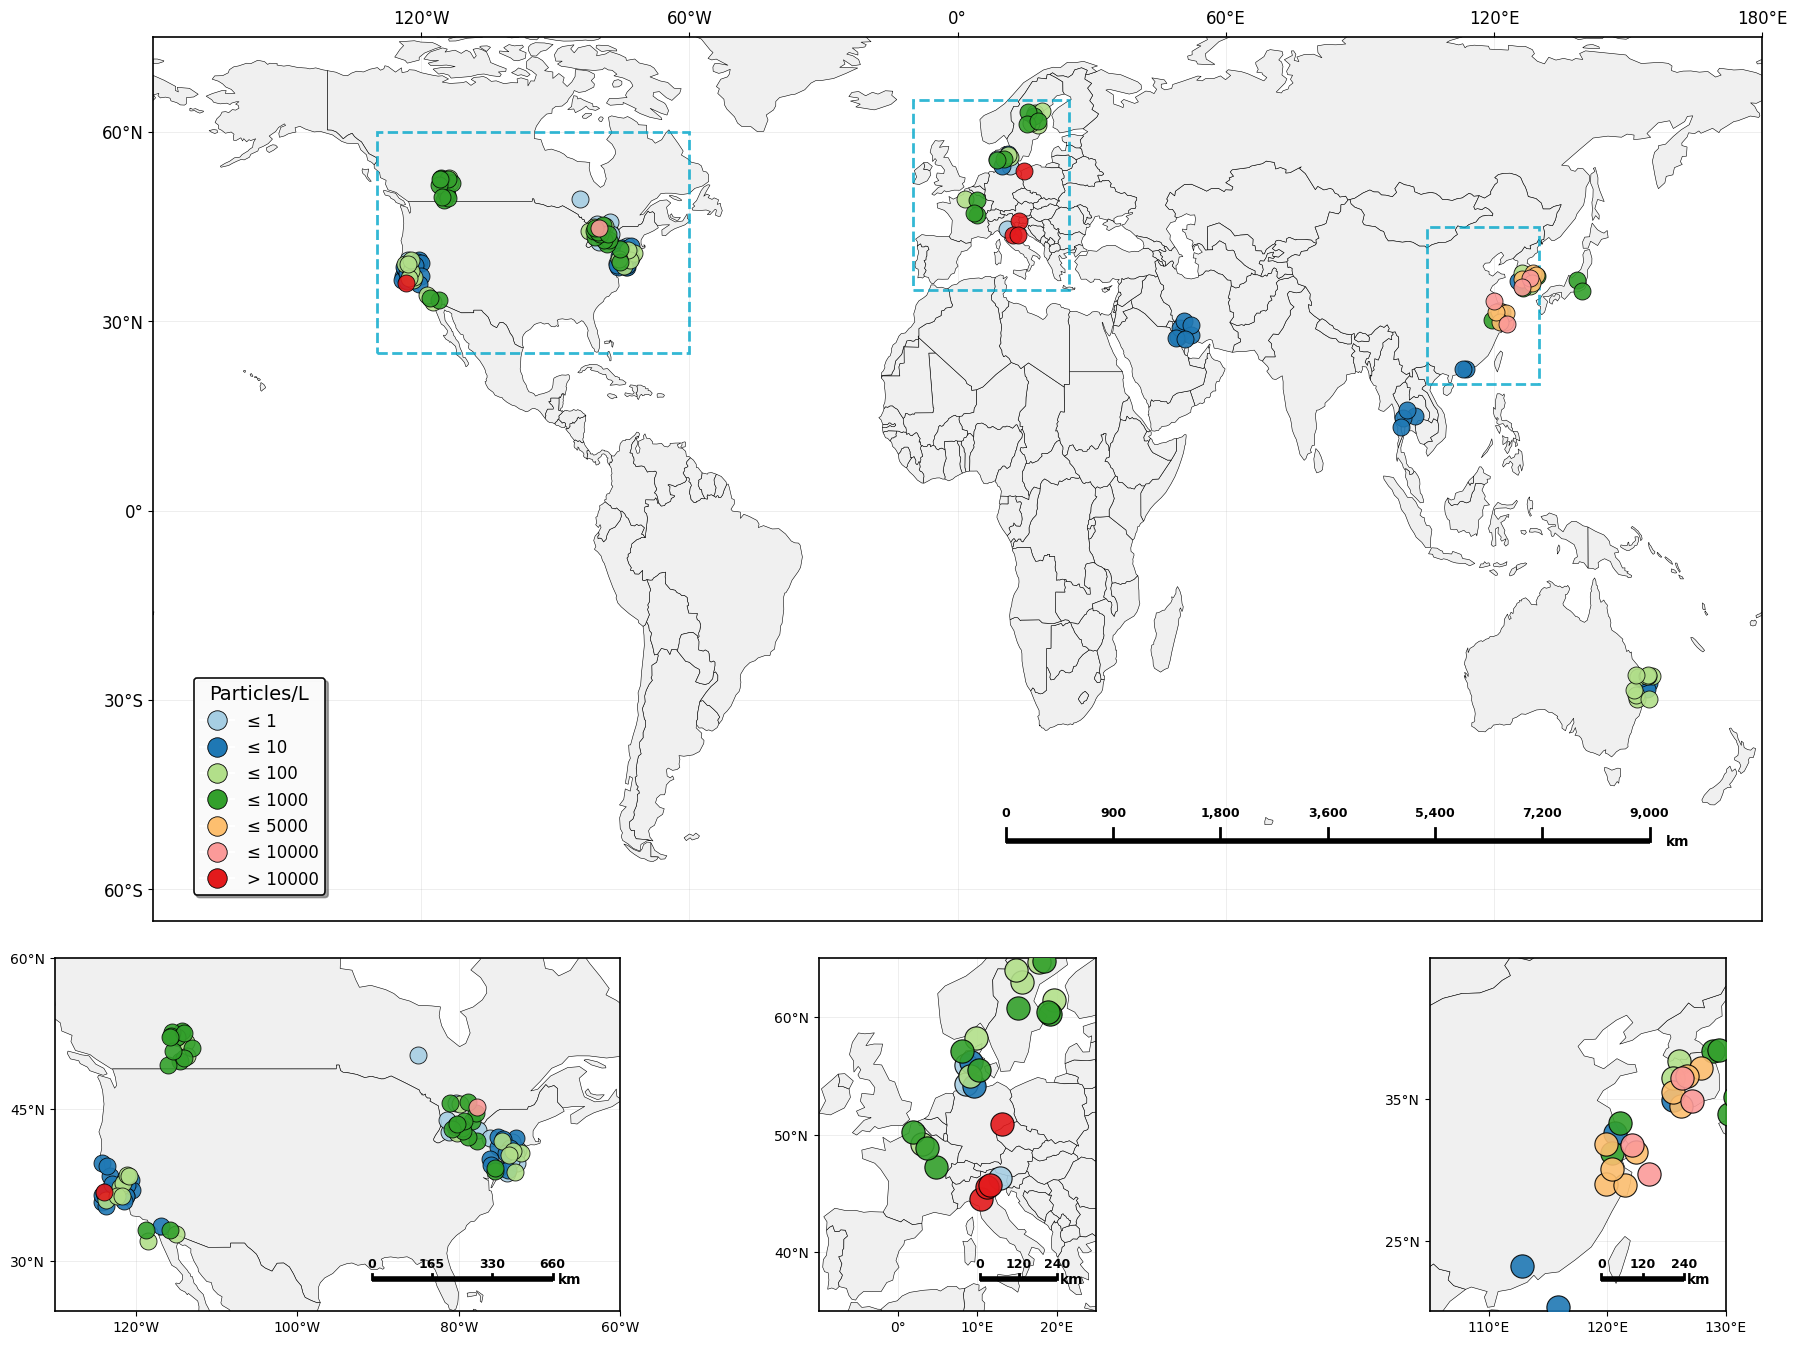

In [85]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, Polygon, FancyBboxPatch
import matplotlib.gridspec as gridspec
from matplotlib.patches import Wedge
import matplotlib.patches as patches
from matplotlib.lines import Line2D

def create_reference_style_map():
    # Load the Excel file
    df = pd.read_excel("Urban Runoff MP Database_072025.xlsx", sheet_name="Urban Runoff MP Database")
    
    # Drop rows missing concentration or coordinates
    df = df.dropna(subset=["Standardized Concentration (particles/L)", "Decimal Latitude", "Decimal Longitude"])
    
    # Use your specified bins and colors
    bins = [0, 1, 10, 100, 1000, 5000, 10000, 20000]
    labels = ['≤ 1', '≤ 10', '≤ 100', '≤ 1000', '≤ 5000', '≤ 10000', '> 10000']
    colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fdbf6f', '#fb9a99', '#e31a1c']
    
    # Assign bin labels
    df["MP_bin"] = pd.cut(df["Standardized Concentration (particles/L)"], bins=bins, labels=labels, include_lowest=True)
    color_map = dict(zip(labels, colors))
    
    # Load world shapefile
    shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
    world = gpd.read_file(shapefile_path)
    world = world[world["NAME"] != "Antarctica"]
    
    # Create figure with three insets
    fig = plt.figure(figsize=(20, 14))
    # Use GridSpec with equal width ratios for perfect alignment
    gs = gridspec.GridSpec(2, 3, figure=fig, 
                          height_ratios=[2.5, 1], width_ratios=[1, 1, 1],
                          hspace=0.06, wspace=0.0)  # Reduce hspace/wspace for tight alignment
    
    # Main world map (spans full width)
    ax_main = fig.add_subplot(gs[0, :])
    ax_main.set_aspect("equal")

    # Three insets, perfectly aligned under the main map
    ax_north_america = fig.add_subplot(gs[1, 0])
    ax_europe = fig.add_subplot(gs[1, 1])
    ax_asia = fig.add_subplot(gs[1, 2])
    
    # Function to add reference-style scale bar
    def add_reference_scale_bar(ax, extent, position='bottom_right'):
        width = extent[1] - extent[0]
        height = extent[3] - extent[2]

        # Determine scale based on map width
        if width > 200:  # World map
            distances = [0, 900, 1800, 3600, 5400, 7200, 9000]  # km
            bar_length = width * 0.4
            margin_x = width * 0.07
        elif width > 50:  # Regional map
            distances = [0, 165, 330, 660]  # km
            bar_length = width * 0.32  # slightly shorter
            margin_x = width * 0.12    # increase margin to avoid border
        else:  # Detailed map
            distances = [0, 120, 240]  # km
            bar_length = width * 0.28  # shorter for detailed
            margin_x = width * 0.14    # more margin for small maps

        # Set fixed margin from the edges (increase margin to avoid overlap)
        margin_y = height * 0.09

        # Positioning logic
        if position == 'bottom_right':
            x_start = extent[1] - bar_length - margin_x
            y_pos = extent[2] + margin_y
        elif position == 'bottom_left':
            x_start = extent[0] + margin_x
            y_pos = extent[2] + margin_y
        elif position == 'top_left':
            x_start = extent[0] + margin_x
            y_pos = extent[3] - margin_y - height * 0.03
        elif position == 'top_right':
            x_start = extent[1] - bar_length - margin_x
            y_pos = extent[3] - margin_y - height * 0.03
        else:
            x_start = extent[1] - bar_length - margin_x
            y_pos = extent[2] + margin_y

        # Draw main scale line
        ax.plot([x_start, x_start + bar_length], [y_pos, y_pos],
                'k-', linewidth=4, solid_capstyle='butt', zorder=20)

        # Add tick marks and labels (tick marks on top)
        for i, distance in enumerate(distances):
            x_pos = x_start + (i / (len(distances) - 1)) * bar_length
            tick_height = height * 0.015
            # Tick mark on top of the scale bar
            ax.plot([x_pos, x_pos], [y_pos, y_pos + tick_height],
                    'k-', linewidth=2, zorder=21)
            # Label above the tick
            ax.text(x_pos, y_pos + tick_height + height * 0.01, f'{distance:,}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold', zorder=22)

        # Add unit label ("km") just to the right of the scale bar, beside the last tick
        ax.text(x_start + bar_length + width * 0.01, y_pos,
                'km', ha='left', va='center', fontsize=10, fontweight='bold', zorder=22)
    
    # Function to style axes
    def style_axis(ax, extent, add_grid=True, tick_position='bottom'):
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        
        if add_grid:
            ax.grid(True, linestyle='-', alpha=0.3, linewidth=0.5)
            ax.set_axisbelow(True)
        
        # Style spines
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color('black')
        
        # Set tick positions
        if tick_position == 'top':
            ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        else:
            ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    
    # Function to plot data on axis with scale-appropriate jitter
    def plot_on_axis(ax, extent, add_points=True):
        # Plot world countries
        world.plot(ax=ax, facecolor='#f0f0f0', edgecolor='black', linewidth=0.4)
        
        if add_points:
            # Filter points within extent with buffer
            buffer = 5
            mask = ((df["Decimal Longitude"] >= extent[0] - buffer) & 
                   (df["Decimal Longitude"] <= extent[1] + buffer) & 
                   (df["Decimal Latitude"] >= extent[2] - buffer) & 
                   (df["Decimal Latitude"] <= extent[3] + buffer))
            df_subset = df[mask].copy()
            
            if len(df_subset) == 0:
                return
            
            # Calculate appropriate jitter for this scale
            lon_range = extent[1] - extent[0]
            
            # Scale jitter based on map extent
            if lon_range < 50:  # Inset maps
                jitter_scale = 2.5
            else:  # Main map
                jitter_scale = 2
            
            # Apply scaled jitter
            np.random.seed(42)
            df_subset["Longitude_display"] = df_subset["Decimal Longitude"] + np.random.uniform(-jitter_scale, jitter_scale, size=len(df_subset))
            df_subset["Latitude_display"] = df_subset["Decimal Latitude"] + np.random.uniform(-jitter_scale, jitter_scale, size=len(df_subset))
            
            # Create geometry for this subset
            geometry_subset = [Point(xy) for xy in zip(df_subset["Longitude_display"], df_subset["Latitude_display"])]
            gdf_subset = gpd.GeoDataFrame(df_subset, geometry=geometry_subset, crs="EPSG:4326")
            
            # Plot each concentration category
            for label in labels:
                subset = gdf_subset[gdf_subset["MP_bin"] == label]
                if not subset.empty:
                    # Adjust marker size based on map scale
                    if lon_range < 50:  # Inset maps
                        marker_size = 280
                        edge_width = 0.8
                    else:  # Main map
                        marker_size = 150
                        edge_width = 0.6
                    
                    subset.plot(
                        ax=ax,
                        markersize=marker_size,
                        color=color_map[label],
                        edgecolor='black',
                        linewidth=edge_width,
                        alpha=0.9,
                        zorder=10
                    )
    
    # Function to add connecting lines from insets to main map
    def add_connecting_lines():
        # Get figure coordinates for drawing lines
        fig_width, fig_height = fig.get_size_inches()
        
        # North America connections
        na_main_x = 0.17  # aligned with left inset
        na_main_y = 0.65
        na_inset_x = 0.17
        na_inset_y = 0.35
        
        # Add dashed lines
        line_na = Line2D([na_main_x, na_inset_x], [na_main_y, na_inset_y], 
                        transform=fig.transFigure, color='#00a6ca', 
                        linestyle='--', linewidth=2, alpha=0.8)
        fig.lines.append(line_na)
        
        # Europe connections  
        eu_main_x = 0.5
        eu_main_y = 0.65
        eu_inset_x = 0.5
        eu_inset_y = 0.35
        
        line_eu = Line2D([eu_main_x, eu_inset_x], [eu_main_y, eu_inset_y], 
                        transform=fig.transFigure, color='#00a6ca', 
                        linestyle='--', linewidth=2, alpha=0.8)
        fig.lines.append(line_eu)
        
        # Asia connections
        asia_main_x = 0.83  # aligned with right inset
        asia_main_y = 0.65
        asia_inset_x = 0.83
        asia_inset_y = 0.35
        
        line_asia = Line2D([asia_main_x, asia_inset_x], [asia_main_y, asia_inset_y], 
                          transform=fig.transFigure, color='#00a6ca', 
                          linestyle='--', linewidth=2, alpha=0.8)
        fig.lines.append(line_asia)
    
    # Main map
    main_extent = [-180, 180, -65, 75]
    style_axis(ax_main, main_extent, tick_position='top')
    plot_on_axis(ax_main, main_extent)
    
    # Add degree labels to main map (on top)
    ax_main.set_xticks(np.arange(-120, 181, 60))
    ax_main.set_yticks(np.arange(-60, 61, 30))
    ax_main.set_xticklabels([f'{abs(x)}°{"W" if x < 0 else "E" if x > 0 else ""}' for x in np.arange(-120, 181, 60)])
    ax_main.set_yticklabels([f'{abs(y)}°{"S" if y < 0 else "N" if y > 0 else ""}' for y in np.arange(-60, 61, 30)])
    
    # North America inset
    north_america_extent = [-130, -60, 25, 60]
    style_axis(ax_north_america, north_america_extent)
    plot_on_axis(ax_north_america, north_america_extent)
    ax_north_america.set_xticks(np.arange(-120, -59, 20))
    ax_north_america.set_yticks(np.arange(30, 61, 15))
    ax_north_america.set_xticklabels([f'{abs(x)}°W' for x in np.arange(-120, -59, 20)])
    ax_north_america.set_yticklabels([f'{y}°N' for y in np.arange(30, 61, 15)])
    
    # Europe inset
    europe_extent = [-10, 25, 35, 65]
    style_axis(ax_europe, europe_extent)
    plot_on_axis(ax_europe, europe_extent)
    ax_europe.set_xticks(np.arange(0, 21, 10))
    ax_europe.set_yticks(np.arange(40, 61, 10))
    ax_europe.set_xticklabels([f'{x}°E' if x > 0 else '0°' for x in np.arange(0, 21, 10)])
    ax_europe.set_yticklabels([f'{y}°N' for y in np.arange(40, 61, 10)])
    
    # Asia inset
    asia_extent = [105, 130, 20, 45]
    style_axis(ax_asia, asia_extent)
    plot_on_axis(ax_asia, asia_extent)
    ax_asia.set_xticks(np.arange(110, 131, 10))
    ax_asia.set_yticks(np.arange(25, 41, 10))
    ax_asia.set_xticklabels([f'{x}°E' for x in np.arange(110, 131, 10)])
    ax_asia.set_yticklabels([f'{y}°N' for y in np.arange(25, 41, 10)])
    
    # Add dashed boxes connecting insets to main map
    na_box = Rectangle((-130, 25), 70, 35, linewidth=2, edgecolor='#00a6ca', 
                      facecolor='none', linestyle='--', alpha=0.8)
    ax_main.add_patch(na_box)
    europe_box = Rectangle((-10, 35), 35, 30, linewidth=2, edgecolor='#00a6ca', 
                          facecolor='none', linestyle='--', alpha=0.8)
    ax_main.add_patch(europe_box)
    asia_box = Rectangle((105, 20), 25, 25, linewidth=2, edgecolor='#00a6ca',
                        facecolor='none', linestyle='--', alpha=0.8)
    ax_main.add_patch(asia_box)
    
    # Create legend with your colors
    legend_elements = []
    for label, color in color_map.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=14,
                                        markeredgecolor='black', markeredgewidth=0.6,
                                        label=label))
    
    # Position legend in main map
    legend = ax_main.legend(handles=legend_elements, title='Particles/L', 
                           loc='lower left', frameon=True, fancybox=True,
                           shadow=True, fontsize=12, title_fontsize=14,
                           bbox_to_anchor=(0.02, 0.02))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.2)
    
    # Add reference-style scale bars
    add_reference_scale_bar(ax_main, main_extent,position='bottom_right')
    add_reference_scale_bar(ax_north_america, north_america_extent)
    add_reference_scale_bar(ax_europe, europe_extent)
    add_reference_scale_bar(ax_asia, asia_extent)
    
    
    # Clean up tick labels for insets
    ax_north_america.tick_params(labelsize=10)
    ax_europe.tick_params(labelsize=10)
    ax_asia.tick_params(labelsize=10)
    ax_main.tick_params(labelsize=12)
    
    # Adjust layout for perfect alignment
    plt.subplots_adjust(left=0.05, right=0.98, top=0.97, bottom=0.06, hspace=0.06, wspace=0.0)
    
    # Save high-resolution figure
    plt.savefig('microplastics_reference_style.svg', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    return fig

# Alternative color schemes you can try
def alternative_color_schemes():
    """Different color schemes for the map"""
    
    # Viridis-inspired
    viridis_colors = ['#440154', '#31688e', '#35b779', '#6ece58', '#b5de2b', '#fde725']
    
    # Blue to red
    blue_red = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#fdbf6f', '#fd8d3c', '#d73027']
    
    # Spectral
    spectral = ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c']
    
    return viridis_colors, blue_red, spectral

if __name__ == "__main__":
    # Create the map
    fig = create_reference_style_map()

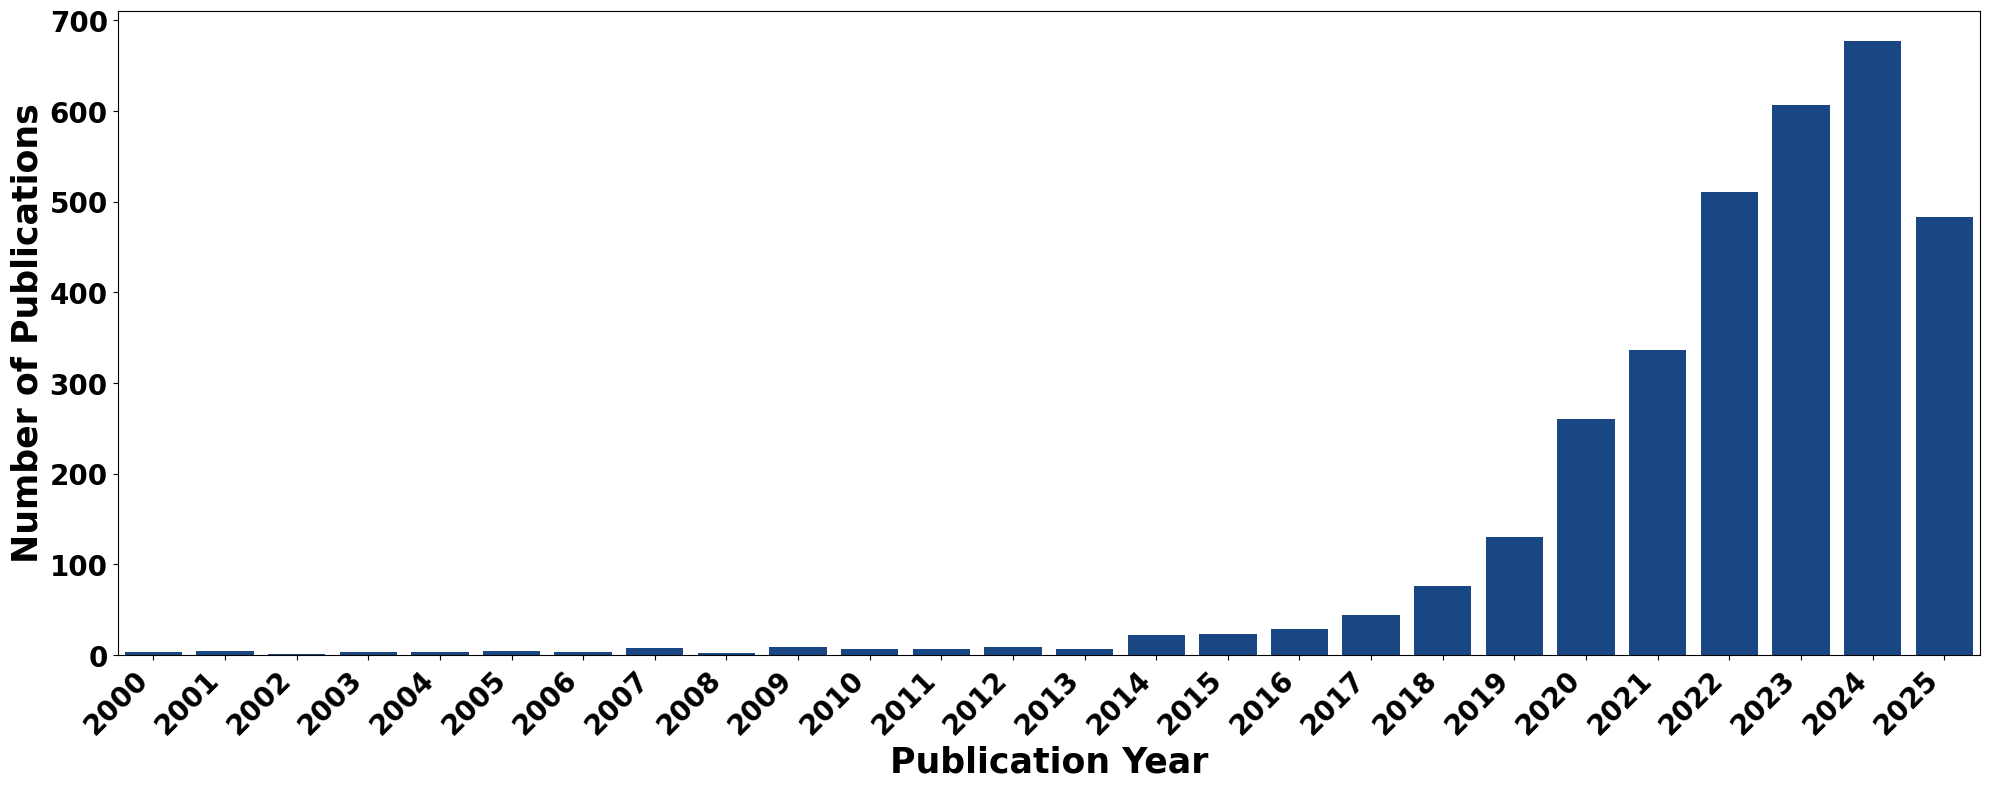

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Customize Bar Color Here ===
bar_color = '#084594'  # e.g., 'steelblue', 'seagreen', '#1f77b4', 'tomato', etc.

# List of CSV file paths (update these paths if needed)
csv_file_paths = [
    "1-1000.csv",
    "1001-2000.csv",
    "2001-3000.csv",
    "3001-3270.csv"
]

# Read and concatenate all CSV files using ISO-8859-1 encoding
csv_dfs = [pd.read_csv(file, encoding='ISO-8859-1') for file in csv_file_paths]
combined_df = pd.concat(csv_dfs, ignore_index=True)

# Count the number of publications per year
year_counts = combined_df['Publication Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20, 8))
sns.barplot(x=year_counts.index.astype(str), y=year_counts.values, color=bar_color)
plt.xticks(rotation=45, ha='right', fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

# Bold, larger axis labels
plt.xlabel('Publication Year', fontsize=25, fontweight='bold')
plt.ylabel('Number of Publications', fontsize=25, fontweight='bold')

# Optional: Title and grid, still commented
# plt.title('Number of Publications per Year', fontsize=16, fontweight='bold')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


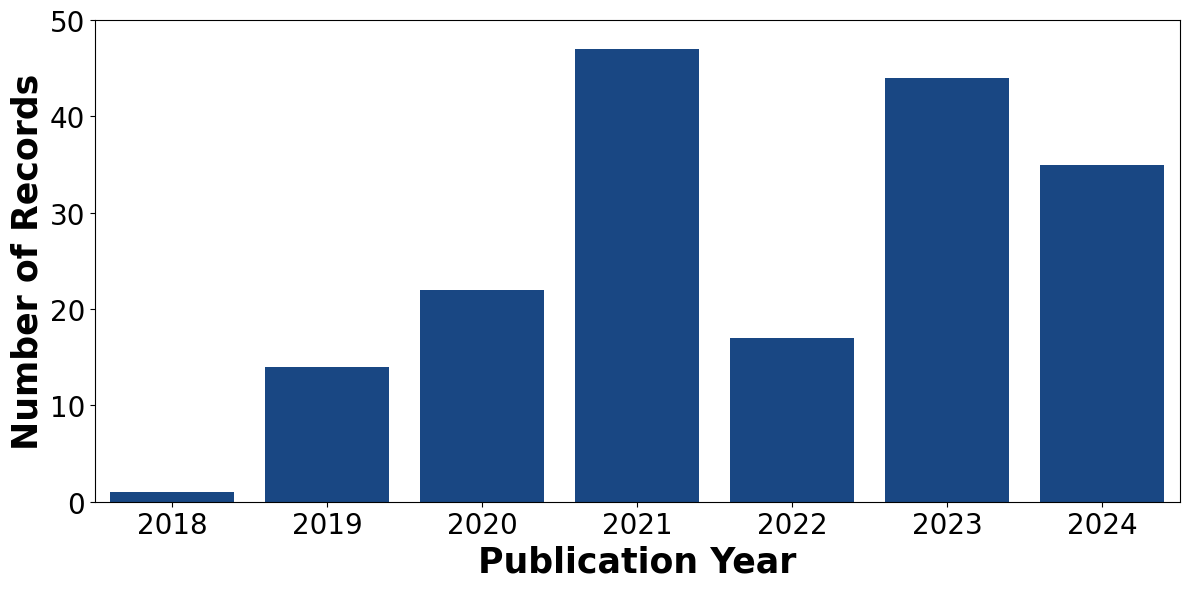

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
df = pd.read_excel("Urban Runoff MP Database_072025.xlsx", sheet_name="Urban Runoff MP Database")

# Extract the last valid 4-digit year (ignores things like _x0001_)
df['Year'] = df['Author (s) and Publication Year'].astype(str).str.extract(r'(\d{4})(?!.*\d{4})')

# Convert to numeric and filter valid years
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df[df['Year'].between(1900, 2025)]

# Count number of records per year
year_counts = df['Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, color='#084594')

# Axis labels
plt.xlabel('Publication Year', fontsize=25, fontweight='bold')
plt.ylabel('Number of Records', fontsize=25, fontweight='bold')

# Ticks and limits
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(0, 50)

# Data labels on each bar
# for i, value in enumerate(year_counts.values):
#     ax.text(i, value + 0.8, str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Box plots by country

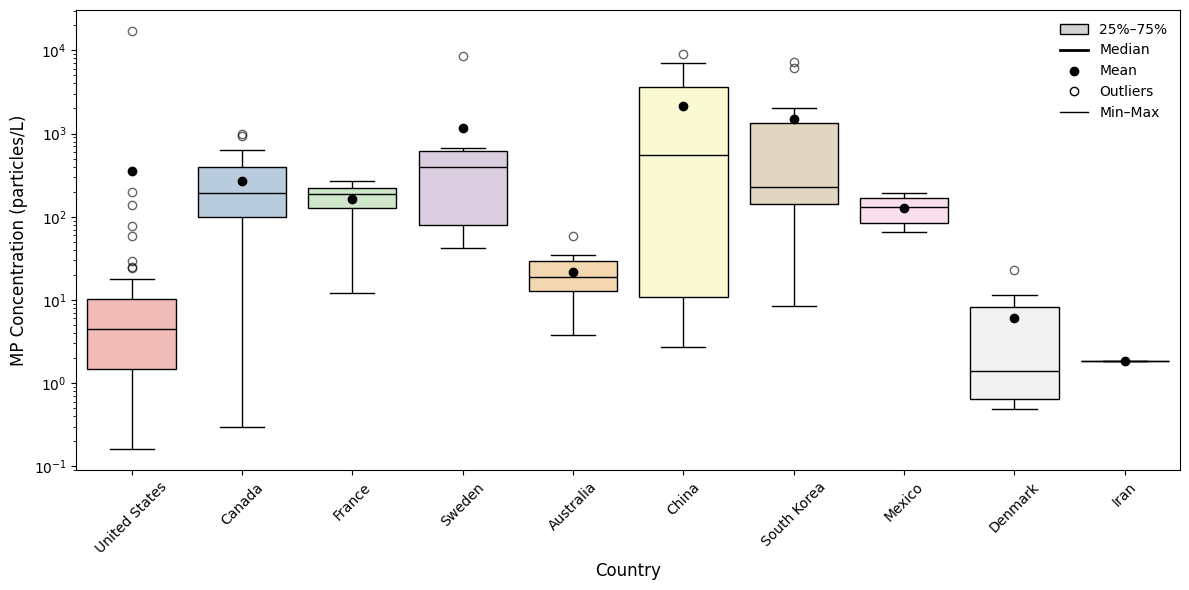

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Load the cleaned dataset
df = pd.read_csv("Urban Runoff MP Database_072025.csv", encoding='cp1252')

# Convert concentration to numeric
df['Concentration'] = pd.to_numeric(df['Standardized Concentration (particles/L)'], errors='coerce')

# Filter valid rows
df = df[df['Concentration'].notna() & (df['Concentration'] > 0)]

# Clean grouping columns
df['Country'] = df['Country'].astype(str).str.strip()
df['Dominant size'] = df['Dominant size'].astype(str).str.strip()

# Get top 10 countries by count
top_countries = df['Country'].value_counts().nlargest(10).index
df_country = df[df['Country'].isin(top_countries)]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Country',
    y='Concentration',
    data=df_country,
    palette='Pastel1',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markerfacecolor": "none", "markeredgecolor": "black", "alpha": 0.6}
)

plt.yscale('log')
plt.ylabel("MP Concentration (particles/L)", fontsize=12)
plt.xlabel("Country", fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)  # no gridlines

# Legend in top-right corner (like Fig a)
legend_elements = [
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='25%–75%'),
    mlines.Line2D([], [], color='black', linewidth=2, label='Median'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=6, label='Mean'),
    mlines.Line2D([], [], color='black', marker='o', markerfacecolor='none', linestyle='None', markersize=6, label='Outliers'),
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Min–Max'),
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


# Box plot by dominant size

/var/folders/w9/4t92sk9n38z0zk4qh8njbth00000gn/T/ipykernel_24631/444720674.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


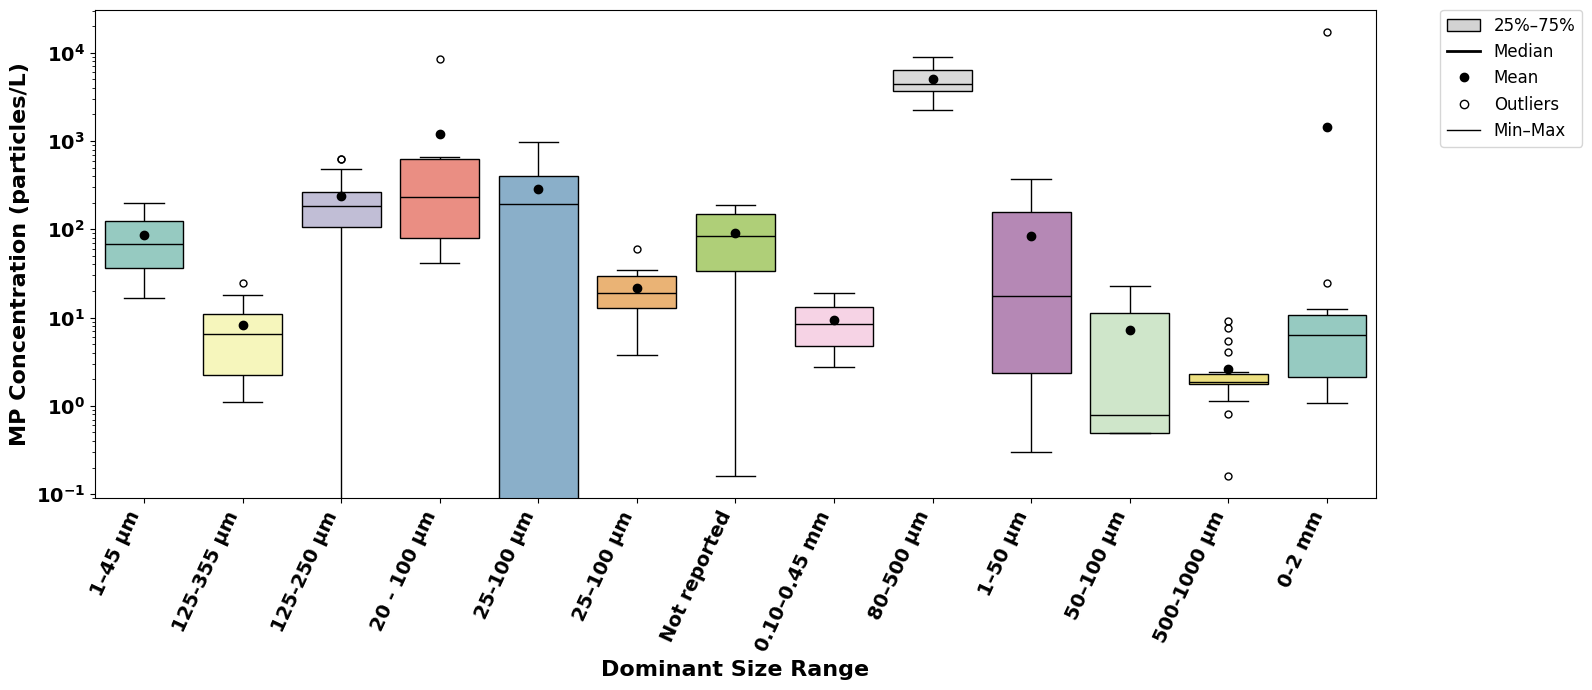

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Load the Excel file
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# Drop rows with missing or non-numeric concentration
df = df[pd.to_numeric(df["Standardized Concentration (particles/L)"], errors="coerce").notna()]
df["Standardized Concentration (particles/L)"] = df["Standardized Concentration (particles/L)"].astype(float)

# Clean dominant size column
df["Dominant size"] = df["Dominant size"].astype(str).str.strip()

# Reassign 'Other/Complex' entries
def reassign_complex(entry):
    lower_entry = entry.lower()
    if "median" in lower_entry or "±" in lower_entry or "for non" in lower_entry:
        match = re.search(r"([\d\.]+)", lower_entry)
        if match:
            try:
                size_val = float(match.group(1))
                return "1–50 μm" if size_val < 50 else "50–100 μm"
            except:
                return entry
        else:
            return entry
    return entry

df["Dominant size (reassigned)"] = df["Dominant size"].apply(reassign_complex)

# Filter out rare categories (<3 entries)
min_count = 5
valid_bins = df["Dominant size (reassigned)"].value_counts()
valid_bins = valid_bins[valid_bins >= min_count].index
df_filtered = df[df["Dominant size (reassigned)"].isin(valid_bins)]

# Plot
plt.figure(figsize=(16, 7))
ax = sns.boxplot(
    data=df_filtered,
    x="Dominant size (reassigned)",
    y="Standardized Concentration (particles/L)",
    palette="Set3",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "none", "markeredgecolor": "black"}
)
plt.yscale("log")

# Adjust tick label size and weight
plt.xticks(rotation=65, ha="right", fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Adjust axis labels
plt.xlabel("Dominant Size Range", fontsize=16, fontweight='bold')
plt.ylabel("MP Concentration (particles/L)", fontsize=16, fontweight='bold')

# Remove grid
plt.grid(False)

# Custom legend
legend_elements = [
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='25%–75%'),
    mlines.Line2D([], [], color='black', linewidth=2, label='Median'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=6, label='Mean'),
    mlines.Line2D([], [], color='black', marker='o', markerfacecolor='none', linestyle='None', markersize=6, label='Outliers'),
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Min–Max'),
]
plt.legend(
    handles=legend_elements,
    title=None,
    fontsize=12,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # tweak x, y to manually move
    borderaxespad=0
)

plt.tight_layout()
plt.show()

/var/folders/w9/4t92sk9n38z0zk4qh8njbth00000gn/T/ipykernel_24631/3857132715.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


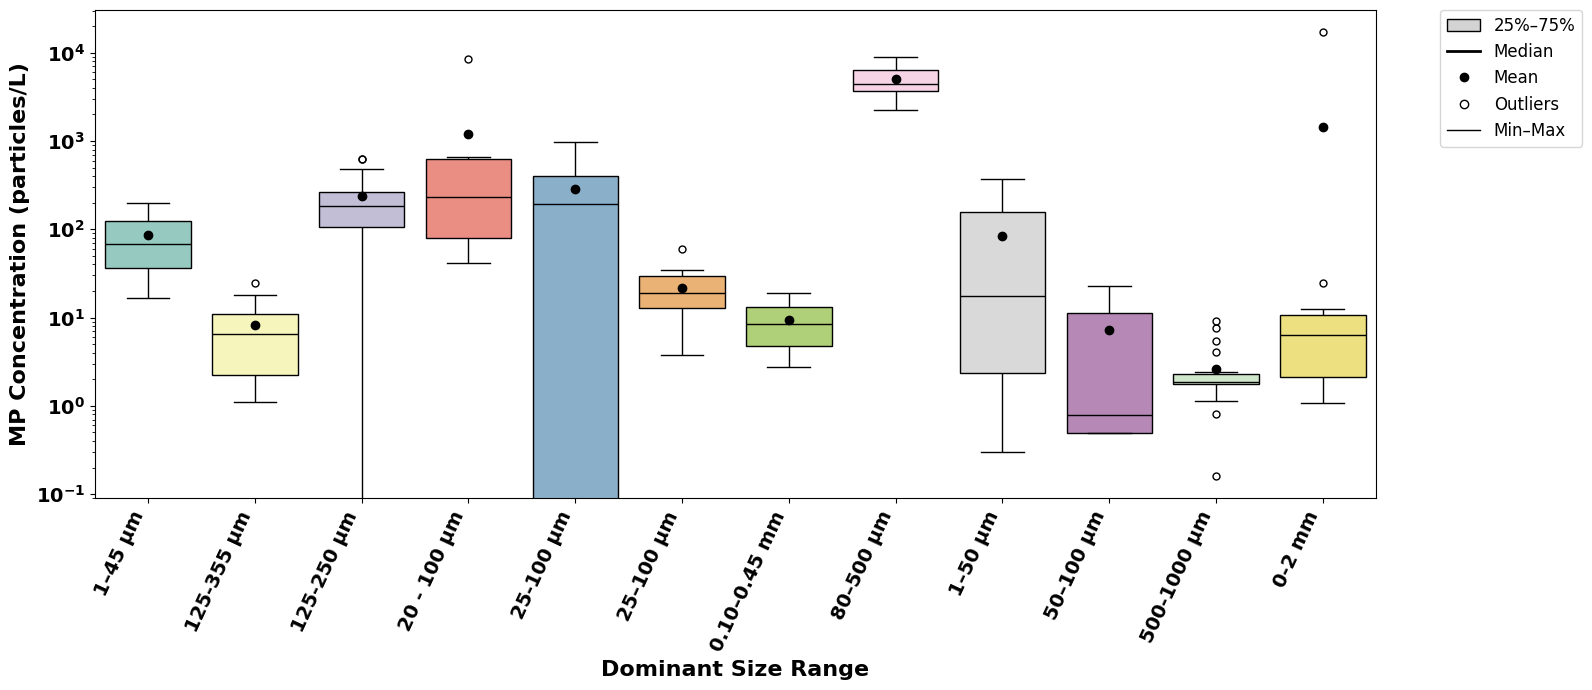

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Load the Excel file
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# Drop rows with missing or non-numeric concentration
df = df[pd.to_numeric(df["Standardized Concentration (particles/L)"], errors="coerce").notna()]
df["Standardized Concentration (particles/L)"] = df["Standardized Concentration (particles/L)"].astype(float)

# Clean dominant size column
df["Dominant size"] = df["Dominant size"].astype(str).str.strip()

# Reassign 'Other/Complex' entries
def reassign_complex(entry):
    lower_entry = entry.lower()
    if "not reported" in lower_entry or lower_entry in ["", "nan"]:
        return None
    if "median" in lower_entry or "±" in lower_entry or "for non" in lower_entry:
        match = re.search(r"([\d\.]+)", lower_entry)
        if match:
            try:
                size_val = float(match.group(1))
                return "1–50 μm" if size_val < 50 else "50–100 μm"
            except:
                return None
        else:
            return None
    return entry

df["Dominant size (reassigned)"] = df["Dominant size"].apply(reassign_complex)

# Drop rows with missing or invalid reassigned values
df = df[df["Dominant size (reassigned)"].notna()]

# Filter out rare categories (<5 entries)
min_count = 5
valid_bins = df["Dominant size (reassigned)"].value_counts()
valid_bins = valid_bins[valid_bins >= min_count].index
df_filtered = df[df["Dominant size (reassigned)"].isin(valid_bins)]

# Plot
plt.figure(figsize=(16, 7))
ax = sns.boxplot(
    data=df_filtered,
    x="Dominant size (reassigned)",
    y="Standardized Concentration (particles/L)",
    palette="Set3",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "none", "markeredgecolor": "black"}
)
plt.yscale("log")
# Adjust tick label size and weight
plt.xticks(rotation=65, ha="right", fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Adjust axis labels
plt.xlabel("Dominant Size Range", fontsize=16, fontweight='bold')
plt.ylabel("MP Concentration (particles/L)", fontsize=16, fontweight='bold')
# plt.title("MP Concentration by Dominant Size Range (Standardized)", fontsize=14)

plt.grid(False)

# Custom legend
legend_elements = [
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='25%–75%'),
    mlines.Line2D([], [], color='black', linewidth=2, label='Median'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=6, label='Mean'),
    mlines.Line2D([], [], color='black', marker='o', markerfacecolor='none', linestyle='None', markersize=6, label='Outliers'),
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Min–Max'),
]
plt.legend(
    handles=legend_elements,
    title=None,
    fontsize=12,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),  # tweak x, y to manually move
    borderaxespad=0
)

plt.tight_layout()
plt.show()


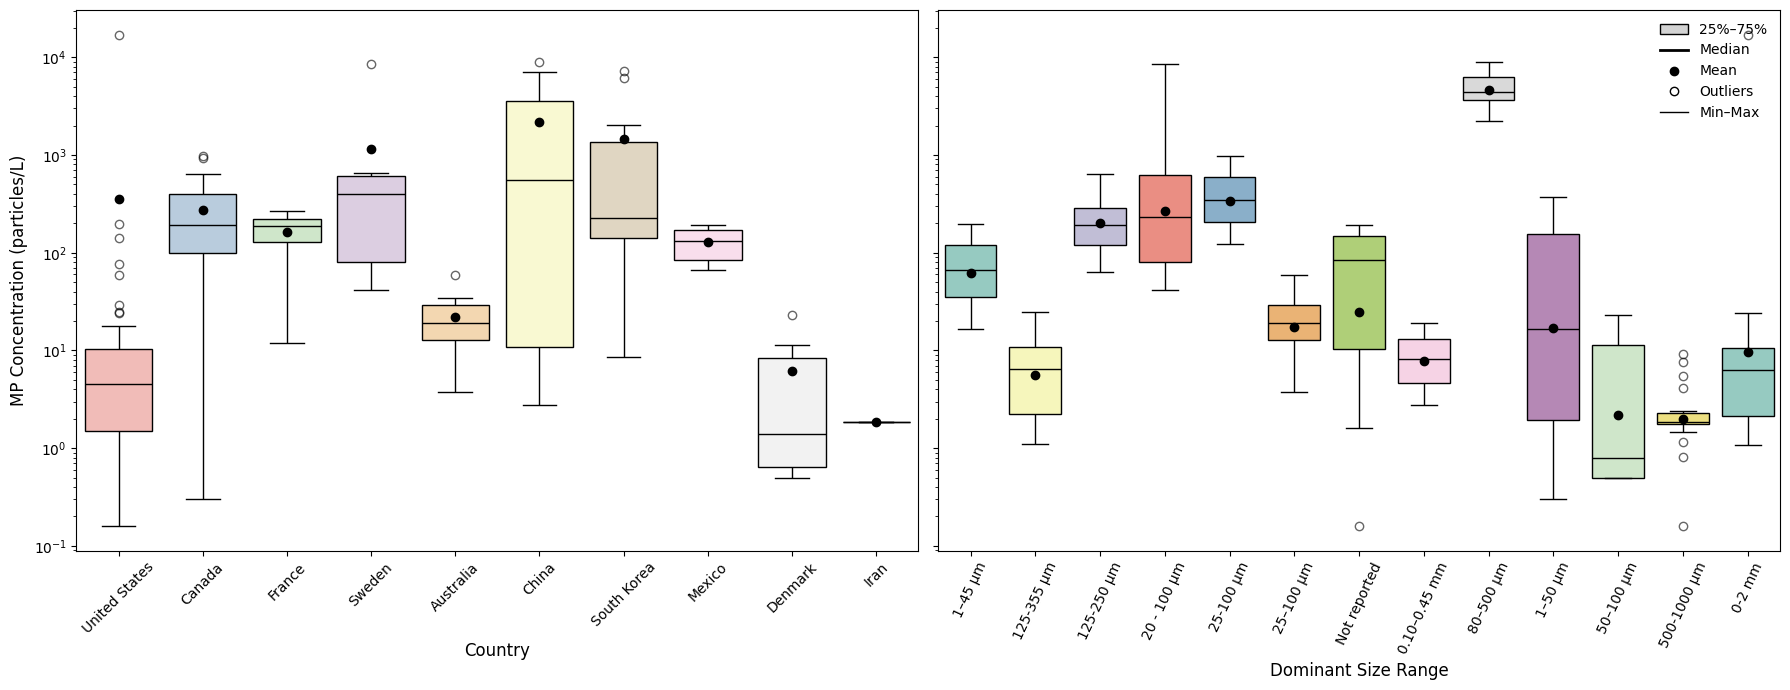

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import re

# === Load CSV for Country Plot (as in original PDF) ===
df_csv = pd.read_csv("Urban Runoff MP Database_072025.csv", encoding='cp1252')
df_csv.columns = df_csv.columns.str.strip()
df_csv['Concentration'] = pd.to_numeric(df_csv['Standardized Concentration (particles/L)'], errors='coerce')
df_csv = df_csv[df_csv['Concentration'].notna() & (df_csv['Concentration'] > 0)].copy()
df_csv['Country'] = df_csv['Country'].astype(str).str.strip()

top_countries = df_csv['Country'].value_counts().nlargest(10).index
df_country = df_csv[df_csv['Country'].isin(top_countries)]

# === Load Excel for Dominant Size Plot ===
df_xlsx = pd.read_excel("Urban Runoff MP Database_072025.xlsx", sheet_name=0)
df_xlsx.columns = df_xlsx.columns.str.strip()
conc_col = "Standardized Concentration (particles/L)"
df_xlsx[conc_col] = pd.to_numeric(df_xlsx[conc_col], errors="coerce")
df_xlsx = df_xlsx[df_xlsx[conc_col].notna() & (df_xlsx[conc_col] > 0)].copy()

df_xlsx['Dominant size'] = df_xlsx['Dominant size'].astype(str).str.strip()

def reassign_complex(entry):
    lower_entry = entry.lower()
    if "median" in lower_entry or "±" in lower_entry or "for non" in lower_entry:
        match = re.search(r"([\d\.]+)", lower_entry)
        if match:
            try:
                size_val = float(match.group(1))
                return "1–50 µm" if size_val < 50 else "50–100 µm"
            except:
                return entry
    return entry

df_xlsx["Dominant size (reassigned)"] = df_xlsx["Dominant size"].apply(reassign_complex)
min_count = 5
valid_bins = df_xlsx["Dominant size (reassigned)"].value_counts()
valid_bins = valid_bins[valid_bins >= min_count].index
df_size = df_xlsx[df_xlsx["Dominant size (reassigned)"].isin(valid_bins)]

# === Create subplots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# --- Left Plot: Country ---
sns.boxplot(
    x='Country',
    y='Concentration',
    data=df_country,
    palette='Pastel1',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markerfacecolor": "none", "markeredgecolor": "black", "alpha": 0.6},
    ax=ax1
)
ax1.set_yscale('log')
ax1.set_xlabel("Country", fontsize=12)
ax1.set_ylabel("MP Concentration (particles/L)", fontsize=12)
# ax1.set_title("Box Plot by Country", fontsize=13)
ax1.tick_params(axis='x', rotation=45)

# --- Right Plot: Dominant Size ---
sns.boxplot(
    x="Dominant size (reassigned)",
    y=conc_col,
    data=df_size,
    palette="Set3",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markerfacecolor": "none", "markeredgecolor": "black", "alpha": 0.6},
    ax=ax2
)
ax2.set_yscale("log")
ax2.set_xlabel("Dominant Size Range", fontsize=12)
# ax2.set_title("Box Plot by Dominant Size", fontsize=13)
ax2.tick_params(axis='x', rotation=65)

# === Shared Legend on Right ===
legend_elements = [
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='25%–75%'),
    mlines.Line2D([], [], color='black', linewidth=2, label='Median'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=6, label='Mean'),
    mlines.Line2D([], [], color='black', marker='o', markerfacecolor='none',
                  linestyle='None', markersize=6, label='Outliers'),
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Min–Max')
]
ax2.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


# Descriptive Statistical analyses

URBAN RUNOFF MICROPLASTICS - COMPREHENSIVE STATISTICAL ANALYSIS
Dataset loaded: 180 total records
Clean dataset: 172 valid concentration records
Removed: 8 invalid/missing records
COMPREHENSIVE DESCRIPTIVE STATISTICS
Variable: Standardized Concentration (particles/L)
------------------------------------------------------------
Count                         :      172.000
Mean                          :      947.627
Median                        :       22.695
Mode                          :        1.860
Standard Deviation            :     3067.221
Variance                      :  9407843.028
Minimum                       :        0.160
Maximum                       :    18966.000
Range                         :    18965.840
Q1 (25th percentile)          :        3.757
Q3 (75th percentile)          :      220.625
IQR                           :      216.868
Skewness                      :        4.335
Kurtosis                      :       19.208
Coefficient of Variation (%)  :      323.

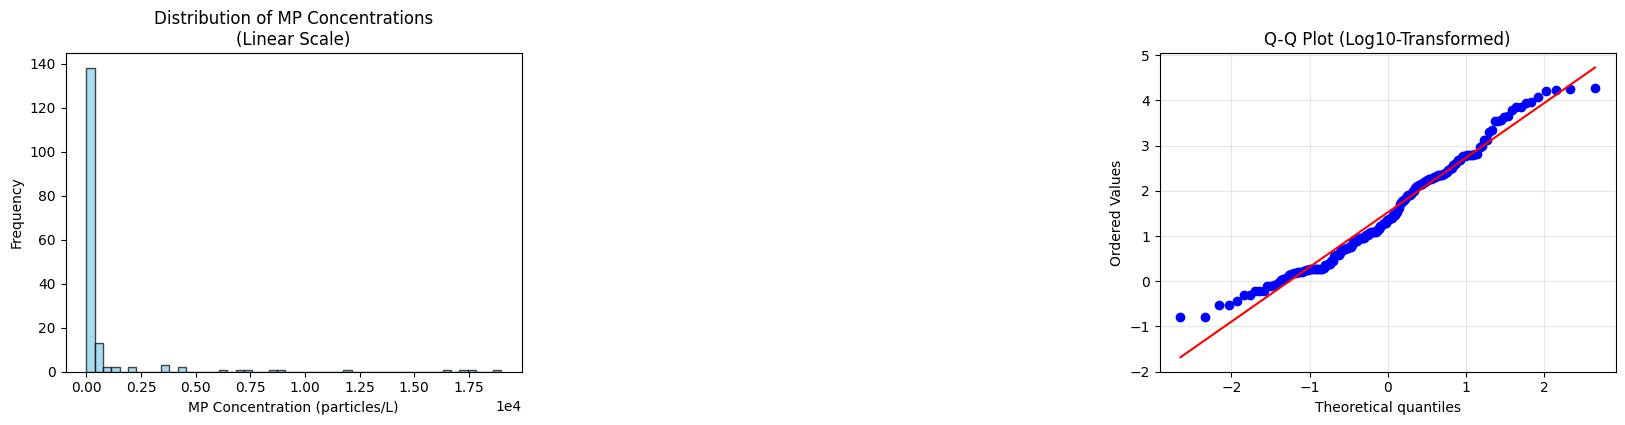

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, kstest, anderson
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_clean_data(filepath):
    """Load and clean the microplastics dataset"""
    
    # Load data
    df = pd.read_csv(filepath, encoding='cp1252')
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Extract key variables
    concentration_col = 'Standardized Concentration (particles/L)'
    
    # Clean concentration data
    df[concentration_col] = pd.to_numeric(df[concentration_col], errors='coerce')
    
    # Remove invalid concentrations
    df_clean = df[df[concentration_col].notna() & (df[concentration_col] > 0)].copy()
    
    # Extract year from date
    df_clean['Year'] = df_clean['Date'].str.extract(r'(20\d{2})').astype(float)
    
    # Clean categorical variables
    categorical_cols = ['Country', 'Dominant shape', 'Sampling method', 
                       'Dominant polymer (s)', 'Region']
    
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Not reported').str.strip()
    
    print(f"Dataset loaded: {len(df)} total records")
    print(f"Clean dataset: {len(df_clean)} valid concentration records")
    print(f"Removed: {len(df) - len(df_clean)} invalid/missing records")
    
    return df_clean, concentration_col

# ============================================================================
# 2. DESCRIPTIVE STATISTICS
# ============================================================================

def comprehensive_descriptive_stats(df, conc_col):
    """Calculate comprehensive descriptive statistics"""
    
    concentrations = df[conc_col].dropna()
    
    # Basic statistics
    stats_dict = {
        'Count': len(concentrations),
        'Mean': concentrations.mean(),
        'Median': concentrations.median(),
        'Mode': concentrations.mode().iloc[0] if not concentrations.mode().empty else np.nan,
        'Standard Deviation': concentrations.std(),
        'Variance': concentrations.var(),
        'Minimum': concentrations.min(),
        'Maximum': concentrations.max(),
        'Range': concentrations.max() - concentrations.min(),
        'Q1 (25th percentile)': concentrations.quantile(0.25),
        'Q3 (75th percentile)': concentrations.quantile(0.75),
        'IQR': concentrations.quantile(0.75) - concentrations.quantile(0.25),
        'Skewness': stats.skew(concentrations),
        'Kurtosis': stats.kurtosis(concentrations),
        'Coefficient of Variation (%)': (concentrations.std() / concentrations.mean()) * 100
    }
    
    # Geometric statistics (for log-normal data)
    log_conc = np.log10(concentrations)
    stats_dict.update({
        'Geometric Mean': stats.gmean(concentrations),
        'Log10 Mean': log_conc.mean(),
        'Log10 Std Dev': log_conc.std(),
        '5th Percentile': concentrations.quantile(0.05),
        '10th Percentile': concentrations.quantile(0.10),
        '90th Percentile': concentrations.quantile(0.90),
        '95th Percentile': concentrations.quantile(0.95),
        '99th Percentile': concentrations.quantile(0.99)
    })
    
    # Convert to DataFrame for better display
    stats_df = pd.DataFrame(list(stats_dict.items()), columns=['Statistic', 'Value'])
    
    print("=" * 60)
    print("COMPREHENSIVE DESCRIPTIVE STATISTICS")
    print("=" * 60)
    print(f"Variable: {conc_col}")
    print("-" * 60)
    
    for _, row in stats_df.iterrows():
        if isinstance(row['Value'], float):
            print(f"{row['Statistic']:<30}: {row['Value']:>12.3f}")
        else:
            print(f"{row['Statistic']:<30}: {row['Value']:>12}")
    
    return stats_df

# ============================================================================
# 3. NORMALITY TESTING
# ============================================================================

def normality_tests(df, conc_col):
    """Perform various normality tests"""
    
    concentrations = df[conc_col].dropna()
    log_concentrations = np.log10(concentrations)
    
    print("\n" + "=" * 60)
    print("NORMALITY TESTS")
    print("=" * 60)
    
    # Tests for original data
    print("Original Data:")
    print("-" * 30)
    
    # Shapiro-Wilk test (for n < 5000)
    if len(concentrations) <= 5000:
        shapiro_stat, shapiro_p = shapiro(concentrations)
        print(f"Shapiro-Wilk Test - Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4e}")
    
    # D'Agostino's normality test
    dagostino_stat, dagostino_p = normaltest(concentrations)
    print(f"D'Agostino Test  - Statistic: {dagostino_stat:.4f}, p-value: {dagostino_p:.4e}")
    
    # Anderson-Darling test
    anderson_result = anderson(concentrations, dist='norm')
    print(f"Anderson-Darling - Statistic: {anderson_result.statistic:.4f}")
    
    # Tests for log-transformed data
    print("\nLog10-Transformed Data:")
    print("-" * 30)
    
    if len(log_concentrations) <= 5000:
        log_shapiro_stat, log_shapiro_p = shapiro(log_concentrations)
        print(f"Shapiro-Wilk Test - Statistic: {log_shapiro_stat:.4f}, p-value: {log_shapiro_p:.4e}")
    
    log_dagostino_stat, log_dagostino_p = normaltest(log_concentrations)
    print(f"D'Agostino Test  - Statistic: {log_dagostino_stat:.4f}, p-value: {log_dagostino_p:.4e}")
    
    # Interpretation
    print("\nInterpretation:")
    print("- p < 0.05: Data significantly deviates from normal distribution")
    print("- p > 0.05: Data appears normally distributed")

# ============================================================================
# 4. OUTLIER DETECTION
# ============================================================================

def detect_outliers(df, conc_col):
    """Detect outliers using multiple methods"""
    
    concentrations = df[conc_col].dropna()
    
    print("\n" + "=" * 60)
    print("OUTLIER DETECTION")
    print("=" * 60)
    
    # IQR Method
    Q1 = concentrations.quantile(0.25)
    Q3 = concentrations.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = concentrations[(concentrations < lower_bound) | (concentrations > upper_bound)]
    
    # Z-score method (|z| > 3)
    z_scores = np.abs(stats.zscore(concentrations))
    z_outliers = concentrations[z_scores > 3]
    
    # Modified Z-score method (using median)
    median = concentrations.median()
    mad = np.median(np.abs(concentrations - median))
    modified_z_scores = 0.6745 * (concentrations - median) / mad
    modified_z_outliers = concentrations[np.abs(modified_z_scores) > 3.5]
    
    print(f"Total observations: {len(concentrations)}")
    print(f"IQR method outliers: {len(iqr_outliers)} ({len(iqr_outliers)/len(concentrations)*100:.1f}%)")
    print(f"Z-score outliers (|z| > 3): {len(z_outliers)} ({len(z_outliers)/len(concentrations)*100:.1f}%)")
    print(f"Modified Z-score outliers: {len(modified_z_outliers)} ({len(modified_z_outliers)/len(concentrations)*100:.1f}%)")
    
    print(f"\nIQR bounds: {lower_bound:.3f} - {upper_bound:.3f}")
    if len(iqr_outliers) > 0:
        print(f"Extreme outliers: {iqr_outliers.min():.1f} - {iqr_outliers.max():.1f}")

# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

def create_comprehensive_plots(df, conc_col):
    """Create all visualization plots"""
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 24))
    
    concentrations = df[conc_col].dropna()
    log_concentrations = np.log10(concentrations)
    
    # 1. Overall distribution histogram
    # plt.subplot(5, 3, 1)
    # plt.hist(concentrations, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.xlabel('MP Concentration (particles/L)')
    # plt.ylabel('Frequency')
    # plt.title('Distribution of MP Concentrations\n(Linear Scale)')
    # plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # 2. Log-scale histogram
    # plt.subplot(5, 3, 2)
    # plt.hist(concentrations, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    # plt.xlabel('MP Concentration (particles/L)')
    # plt.ylabel('Frequency')
    # plt.title('Distribution of MP Concentrations\n(Log Scale)')
    # plt.xscale('log')
    
    # 3. Q-Q plot for normality
    plt.subplot(5, 3, 3)
    stats.probplot(log_concentrations, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Log10-Transformed)')
    plt.grid(True, alpha=0.3)
    
    # # 4. Overall boxplot
    # plt.subplot(5, 3, 4)
    # plt.boxplot(concentrations, vert=True)
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Overall Distribution\n(Boxplot)')
    # plt.yscale('log')
    
    # # 5. Country-wise boxplots
    # plt.subplot(5, 3, 5)
    # # Get top 8 countries by sample size
    # top_countries = df['Country'].value_counts().head(8).index
    # country_data = [df[df['Country'] == country][conc_col].dropna() for country in top_countries]
    
    # plt.boxplot(country_data, labels=[c[:8] + '...' if len(c) > 8 else c for c in top_countries])
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Concentrations by Country\n(Top 8 Countries)')
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    
    # # 6. Sampling method boxplots
    # plt.subplot(5, 3, 6)
    # top_methods = df['Sampling method'].value_counts().head(6).index
    # method_data = [df[df['Sampling method'] == method][conc_col].dropna() for method in top_methods]
    
    # plt.boxplot(method_data, labels=[m[:10] + '...' for m in top_methods])
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Concentrations by Sampling Method\n(Top 6 Methods)')
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    
    # # 7. Shape-wise boxplots
    # plt.subplot(5, 3, 7)
    # # Clean shape data
    # df_shape = df[df['Dominant shape'] != 'Not reported'].copy()
    # top_shapes = df_shape['Dominant shape'].value_counts().head(6).index
    # shape_data = [df_shape[df_shape['Dominant shape'] == shape][conc_col].dropna() for shape in top_shapes]
    
    # plt.boxplot(shape_data, labels=[s[:8] + '...' if len(s) > 8 else s for s in top_shapes])
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Concentrations by Dominant Shape\n(Top 6 Shapes)')
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    
    # # 8. Temporal trends
    # plt.subplot(5, 3, 8)
    # yearly_data = df.groupby('Year')[conc_col].apply(list).dropna()
    # years = sorted(yearly_data.index)
    # year_concentrations = [yearly_data[year] for year in years]
    
    # plt.boxplot(year_concentrations, labels=[int(y) for y in years])
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Temporal Trends\n(Yearly Boxplots)')
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    
    # # 9. Violin plot (overall)
    # plt.subplot(5, 3, 9)
    # plt.violinplot([concentrations], positions=[1], showmeans=True, showmedians=True)
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Distribution Shape\n(Violin Plot)')
    # plt.yscale('log')
    # plt.xticks([1], ['All Data'])
    
    # # 10. Scatter plot: Latitude vs Concentration
    # plt.subplot(5, 3, 10)
    # df_coord = df.dropna(subset=['Decimal Latitude', conc_col])
    # plt.scatter(df_coord['Decimal Latitude'], df_coord[conc_col], alpha=0.6, s=30)
    # plt.xlabel('Latitude')
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Geographic Pattern\n(Latitude vs Concentration)')
    # plt.yscale('log')
    
    # # 11. Sample size by country
    # plt.subplot(5, 3, 11)
    # country_counts = df['Country'].value_counts().head(10)
    # plt.bar(range(len(country_counts)), country_counts.values, color='lightgreen')
    # plt.xlabel('Countries')
    # plt.ylabel('Number of Studies')
    # plt.title('Sample Sizes by Country\n(Top 10)')
    # plt.xticks(range(len(country_counts)), [c[:8] + '...' if len(c) > 8 else c for c in country_counts.index], rotation=45)
    
    # # 12. Yearly trend line
    # plt.subplot(5, 3, 12)
    # yearly_stats = df.groupby('Year')[conc_col].agg(['mean', 'median', 'count']).dropna()
    # plt.plot(yearly_stats.index, yearly_stats['mean'], 'o-', label='Mean', markersize=6)
    # plt.plot(yearly_stats.index, yearly_stats['median'], 's-', label='Median', markersize=6)
    # plt.xlabel('Year')
    # plt.ylabel('MP Concentration (particles/L)')
    # plt.title('Temporal Trends\n(Mean & Median)')
    # plt.yscale('log')
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.show()

# ============================================================================
# 6. STATISTICAL TESTS
# ============================================================================

def statistical_tests(df, conc_col):
    """Perform statistical tests between groups"""
    
    print("\n" + "=" * 60)
    print("STATISTICAL TESTS")
    print("=" * 60)
    
    # Kruskal-Wallis test for countries (non-parametric ANOVA)
    print("KRUSKAL-WALLIS TESTS (Non-parametric ANOVA):")
    print("-" * 45)
    
    # Test countries (top 5 with sufficient data)
    top_countries = df['Country'].value_counts().head(5).index
    country_groups = [df[df['Country'] == country][conc_col].dropna() for country in top_countries]
    country_groups = [group for group in country_groups if len(group) >= 3]  # At least 3 samples
    
    if len(country_groups) >= 2:
        kw_stat, kw_p = stats.kruskal(*country_groups)
        print(f"Countries: H = {kw_stat:.3f}, p = {kw_p:.3e}")
        
        if kw_p < 0.05:
            print("  → Significant differences between countries")
        else:
            print("  → No significant differences between countries")
    
    # Test sampling methods
    top_methods = df['Sampling method'].value_counts().head(4).index
    method_groups = [df[df['Sampling method'] == method][conc_col].dropna() for method in top_methods]
    method_groups = [group for group in method_groups if len(group) >= 3]
    
    if len(method_groups) >= 2:
        kw_stat, kw_p = stats.kruskal(*method_groups)
        print(f"Sampling Methods: H = {kw_stat:.3f}, p = {kw_p:.3e}")
        
        if kw_p < 0.05:
            print("  → Significant differences between sampling methods")
        else:
            print("  → No significant differences between sampling methods")

# ============================================================================
# 7. CORRELATION ANALYSIS
# ============================================================================

def correlation_analysis(df, conc_col):
    """Analyze correlations with environmental variables"""
    
    print("\n" + "=" * 60)
    print("CORRELATION ANALYSIS")
    print("=" * 60)
    
    # Numeric columns for correlation
    numeric_cols = ['Decimal Latitude', 'Decimal Longitude', 'Total rainfall', 
                   'Temperature', 'Antecedent dry days', 'Average wind speed']
    
    correlation_results = {}
    
    for col in numeric_cols:
        if col in df.columns:
            # Convert to numeric and get valid pairs
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                valid_data = df[[conc_col, col]].dropna()
                
                if len(valid_data) > 10:  # At least 10 paired observations
                    # Convert to float arrays
                    x = valid_data[conc_col].astype(float)
                    y = valid_data[col].astype(float)
                    
                    # Pearson correlation
                    pearson_r, pearson_p = stats.pearsonr(x, y)
                    
                    # Spearman correlation (non-parametric)
                    spearman_r, spearman_p = stats.spearmanr(x, y)
                    
                    correlation_results[col] = {
                        'n_pairs': len(valid_data),
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p
                    }
            except Exception as e:
                print(f"Could not analyze correlation with {col}: {str(e)}")
                continue
    
    # Display results
    if correlation_results:
        print(f"{'Variable':<20} {'N':<6} {'Pearson r':<10} {'p-value':<10} {'Spearman ρ':<12} {'p-value':<10}")
        print("-" * 70)
        
        for var, results in correlation_results.items():
            print(f"{var:<20} {results['n_pairs']:<6} {results['pearson_r']:<10.3f} "
                  f"{results['pearson_p']:<10.3e} {results['spearman_r']:<12.3f} {results['spearman_p']:<10.3e}")
    else:
        print("No valid correlations could be computed - insufficient numeric data")

# ============================================================================
# 8. SUMMARY STATISTICS BY GROUP
# ============================================================================

def group_summary_statistics(df, conc_col):
    """Generate summary statistics by groups"""
    
    print("\n" + "=" * 60)
    print("GROUP SUMMARY STATISTICS")
    print("=" * 60)
    
    # By Country
    print("BY COUNTRY (Top 10):")
    print("-" * 30)
    country_summary = df.groupby('Country')[conc_col].agg([
        'count', 'mean', 'median', 'std', 
        lambda x: x.quantile(0.25),  # Q1
        lambda x: x.quantile(0.75),  # Q3
        'min', 'max'
    ]).round(2)
    
    country_summary.columns = ['N', 'Mean', 'Median', 'Std', 'Q1', 'Q3', 'Min', 'Max']
    print(country_summary.head(10).to_string())
    
    # By Sampling Method
    print("\n\nBY SAMPLING METHOD (Top 8):")
    print("-" * 35)
    method_summary = df.groupby('Sampling method')[conc_col].agg([
        'count', 'mean', 'median', 'std'
    ]).round(2)
    
    method_summary.columns = ['N', 'Mean', 'Median', 'Std']
    print(method_summary.head(8).to_string())

# ============================================================================
# 9. MAIN EXECUTION FUNCTION
# ============================================================================

def run_complete_analysis(filepath):
    """Run the complete analysis pipeline"""
    
    print("URBAN RUNOFF MICROPLASTICS - COMPREHENSIVE STATISTICAL ANALYSIS")
    print("=" * 80)
    
    try:
        # Load and clean data
        df, conc_col = load_and_clean_data(filepath)
        
        # Run all analyses
        stats_df = comprehensive_descriptive_stats(df, conc_col)
        normality_tests(df, conc_col)
        detect_outliers(df, conc_col)
        statistical_tests(df, conc_col)
        correlation_analysis(df, conc_col)
        group_summary_statistics(df, conc_col)
        
        # Create visualizations
        print("\n" + "=" * 60)
        print("GENERATING COMPREHENSIVE VISUALIZATIONS...")
        print("=" * 60)
        create_comprehensive_plots(df, conc_col)
        
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE!")
        print("=" * 80)
        
        return df, stats_df
        
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None, None

# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    # Replace with your actual file path
    filepath = "Urban Runoff MP Database_072025.csv"
    
    # Run complete analysis
    df, stats_df = run_complete_analysis(filepath)
    
    # Additional custom analysis can be added here
    if df is not None:
        print("\nDataset successfully loaded and analyzed!")
        print(f"Final dataset shape: {df.shape}")

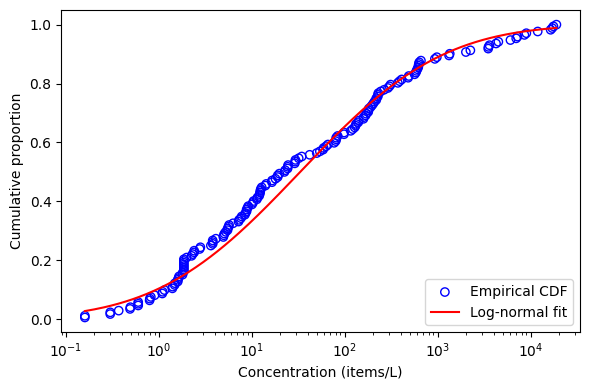

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# 1. Load data
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database")

# 2. Prepare positive concentrations
vals = df["Standardized Concentration (particles/L)"].dropna()
vals = vals[vals > 0]
vals_sorted = np.sort(vals)
cumprop = np.arange(1, len(vals_sorted)+1) / len(vals_sorted)

# 3. Fit a log‑normal distribution
shape, loc, scale = lognorm.fit(vals_sorted, floc=0)
x = np.logspace(np.log10(vals_sorted.min()),
                np.log10(vals_sorted.max()), 200)
cdf_fit = lognorm.cdf(x, shape, loc=loc, scale=scale)

# 4. Plot
plt.figure(figsize=(6,4))
plt.scatter(vals_sorted, cumprop,
            facecolors='none', edgecolors='blue',
            label="Empirical CDF")
plt.plot(x, cdf_fit, color='red', label="Log-normal fit")
plt.xscale('log')
plt.xlabel("Concentration (items/L)")
plt.ylabel("Cumulative proportion")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


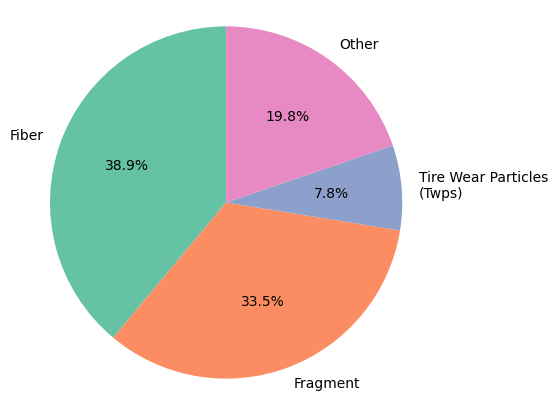

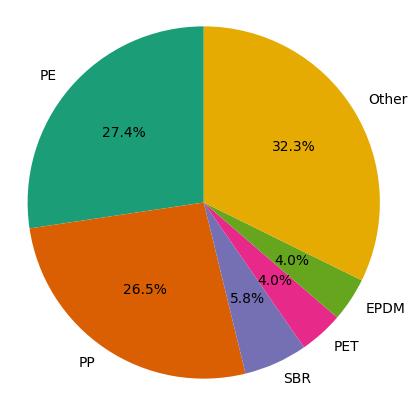

In [92]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load & clean as before…
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database")
df.columns = df.columns.str.strip()

shape_col = next(c for c in df.columns if c.lower().startswith("dominant shape"))
poly_col  = next(c for c in df.columns if c.lower().startswith("dominant polymer"))

shape_map = {
    'fibers':'Fiber','fiber':'Fiber',
    'fragments':'Fragment','fragment':'Fragment',
    'films':'Film','film':'Film',
    'spheres':'Sphere','sphere':'Sphere'
}
def split_shape(x):
    if pd.isna(x): return []
    parts = re.split(r'[;,/&]\s*|\s+and\s+', str(x))
    return [ shape_map.get(p.strip().lower(), p.strip().title()) for p in parts ]

df['shape_list'] = df[shape_col].apply(split_shape)
shape_series = df.explode('shape_list')['shape_list']
shape_series = shape_series[~shape_series.str.lower().isin(['not reported'])]
shape_counts = shape_series.value_counts()

def split_poly(x):
    if pd.isna(x): return []
    parts = re.split(r'[;,/&]\s*|\s+and\s+', str(x))
    return [ re.sub(r'\s*\(.*?\)', '', p).strip().title() for p in parts ]

df['poly_list'] = df[poly_col].apply(split_poly)
poly_series = df.explode('poly_list')['poly_list']
poly_series = poly_series[~poly_series.str.lower().isin(['not reported','discussed'])]
poly_counts = poly_series.value_counts()

# Corrected grouping function (positional arg)
def group_top(s, n):
    top   = s.nlargest(n)
    other = pd.Series({'Other': s.sum() - top.sum()})
    return pd.concat([top, other])
abbrev = {
    "Polyethylene": "PE",
    "Polypropylene": "PP",
    "Styrene-Butadiene Rubber": "SBR",
    "Polyethylene Terephthalate": "PET",
    "Ethylene Propylene Diene Monomer": "EPDM",
    # “Other” stays as is
}
shape_plot = group_top(shape_counts, 3)   # top 3 shapes + Other
poly_plot  = group_top(poly_counts,  5)   # top 5 polymers + Other
poly_plot = poly_plot.rename(index=abbrev)
# Example manual colors
shape_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]
poly_colors  = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]

# Plot shapes
plt.figure(figsize=(5,5))
plt.pie(shape_plot.values,
        labels=shape_plot.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=shape_colors)
# plt.title("Dominant Shapes (Top 3 + Other)")
plt.axis('equal')
plt.show()

# Plot polymers
poly_colors  = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"]
plt.figure(figsize=(5,5))
plt.pie(
    poly_plot.values,
    labels=poly_plot.index,    # now shows PE, PP, SBR, PET, EPDM, Other
    autopct='%1.1f%%',
    startangle=90,
    colors=poly_colors
)
# plt.title("Dominant Polymers (Top 5 + Other)")
plt.axis('equal')
plt.show()

Median ratio (≤100 µm / >100 µm): 10.0×
Mann–Whitney U = 4699.5, p = 2.699e-04

ANOVA results:
                    sum_sq     df         F    PR(>F)
C(size_group)    2.413530    1.0  0.661596  0.417135
Residual       620.166636  170.0       NaN       NaN

Tukey HSD results:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
>100 µm cutoff ≤100 µm cutoff   0.2423 0.4171 -0.3457 0.8303  False
-------------------------------------------------------------------


C:\Users\prott\AppData\Local\Temp\ipykernel_22288\1848514744.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


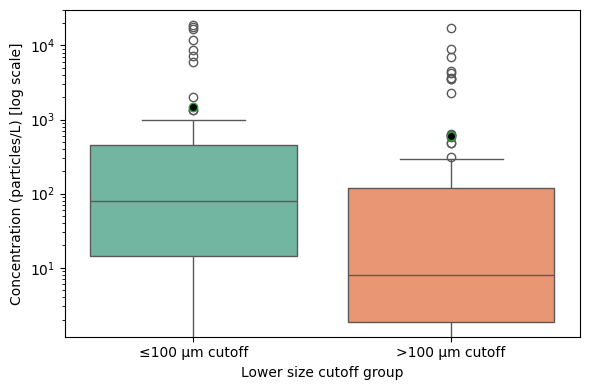

In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Load and clean data
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database")
df.columns = df.columns.str.strip()

# Keep only numeric concentrations
conc_col = "Standardized Concentration (particles/L)"
df = df[pd.to_numeric(df[conc_col], errors="coerce").notna()].copy()
df[conc_col] = df[conc_col].astype(float)

# 2. Parse Dominant size → numeric lower cutoff in µm
size_col = next(c for c in df.columns if c.lower().startswith("dominant size"))
def extract_lower_um(s):
    tokens = re.findall(r"(\d+\.?\d*)\s*(µm|μm|mm)", str(s))
    vals = []
    for num, unit in tokens:
        v = float(num)
        if unit.lower().startswith("mm"):
            v *= 1000.0
        vals.append(v)
    return min(vals) if vals else np.nan

df["lower_um"] = df[size_col].apply(extract_lower_um)

# 3. Group: ≤100 µm vs >100 µm
df2 = df.dropna(subset=["lower_um"]).copy()
df2["size_group"] = np.where(df2["lower_um"] <= 100, "≤100 µm cutoff", ">100 µm cutoff")

# 4. Median ratio (fold-change)
med_small = df2[df2["size_group"]=="≤100 µm cutoff"][conc_col].median()
med_large = df2[df2["size_group"]==">100 µm cutoff"][conc_col].median()
ratio = med_small / med_large
print(f"Median ratio (≤100 µm / >100 µm): {ratio:.1f}×")

# 5. Mann–Whitney U test
g1 = df2[df2["size_group"]=="≤100 µm cutoff"][conc_col]
g2 = df2[df2["size_group"]==">100 µm cutoff"][conc_col]
u_stat, p_val = mannwhitneyu(g1, g2, alternative="two-sided")
print(f"Mann–Whitney U = {u_stat:.1f}, p = {p_val:.3e}")

# 6. One‑way ANOVA on log‑transformed concentration
df2["log_conc"] = np.log10(df2[conc_col] + 1e-6)  # avoid log(0)
model = ols("log_conc ~ C(size_group)", data=df2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA results:\n", anova_table)

# 7. Tukey HSD post‑hoc test
tukey = pairwise_tukeyhsd(df2["log_conc"], df2["size_group"], alpha=0.05)
print("\nTukey HSD results:\n", tukey.summary())

# 8. Boxplot visualization
plt.figure(figsize=(6,4))
sns.boxplot(
    x="size_group", y=conc_col, data=df2,
    palette={"≤100 µm cutoff":"#66c2a5", ">100 µm cutoff":"#fc8d62"},
    showmeans=True, meanprops={"marker":"o","markerfacecolor":"black"}
)
plt.yscale("log")
plt.xlabel("Lower size cutoff group")
plt.ylabel("Concentration (particles/L) [log scale]")
# plt.title("MP Concentrations: ≤100 µm vs >100 µm cutoff")
# plt.text(
#     0.5, 0.05,
#     f"Median ratio = {ratio:.1f}×\nM-W U = {u_stat:.1f}, p = {p_val:.1e}",
#     ha="center", va="bottom", transform=plt.gca().transAxes,
#     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
# )
plt.tight_layout()
plt.show()


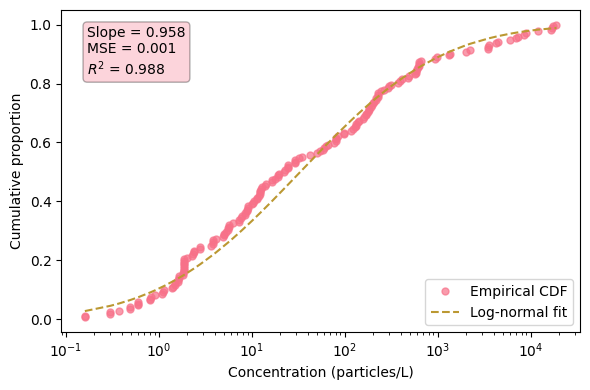

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, linregress

# ——— Configuration ———
# Path to your Excel file
file_path = 'Urban Runoff MP Database_072025.xlsx'
sheet_name = 'Urban Runoff MP Database'
concentration_col = 'Standardized Concentration (particles/L)'

# ——— Load and clean data ———
df = pd.read_excel(file_path, sheet_name=sheet_name)
data = df[concentration_col].dropna()
data = data[data > 0].values  # exclude zeros and negatives

# ——— Empirical CDF ———
x = np.sort(data)
y = np.arange(1, len(x) + 1) / len(x)

# ——— Fit log‑normal distribution ———
shape, loc, scale = lognorm.fit(data, floc=0)
y_fit = lognorm.cdf(x, shape, loc=loc, scale=scale)

# ——— Goodness‑of‑fit metrics ———
slope, intercept, r_value, p_value, std_err = linregress(y_fit, y)
mse = np.mean((y - y_fit) ** 2)
r2 = r_value ** 2

# ——— Plotting ———
plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o', linestyle='none', markersize=5, alpha=0.7, label='Empirical CDF')
plt.plot(x, y_fit, linestyle='--', linewidth=1.5, label='Log‑normal fit')
plt.xscale('log')

plt.xlabel('Concentration (particles/L)')
plt.ylabel('Cumulative proportion')
# plt.title('Empirical CDF vs. Log‑normal Fit')
plt.legend(loc='lower right')

plt.text(0.05, 0.95,
         f'Slope = {slope:.3f}\nMSE = {mse:.3f}\n$R^2$ = {r2:.3f}',
         transform=plt.gca().transAxes,
         va='top',
         bbox=dict(boxstyle='round,pad=0.3', alpha=0.3))

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import re

# Load your Excel file
file_path = "Urban Runoff MP Database_072025.xlsx"  # Replace with your actual path
df = pd.read_excel(file_path, sheet_name=0)

# Clean column names
df.columns = df.columns.str.strip()

# Step 1: Extract numeric size (µm) from 'Dominant size'
def extract_corrected_size(value):
    if pd.isna(value):
        return np.nan

    value_str = str(value).lower()

    # Detect the unit (applies to all numbers)
    unit_match = re.search(r"(µm|μm|mm)", value_str)
    if not unit_match:
        return np.nan
    unit = unit_match.group(1)

    # Extract all numeric values
    number_matches = re.findall(r"\d+\.?\d*", value_str)
    if not number_matches:
        return np.nan

    sizes = []
    for num_str in number_matches:
        size = float(num_str)
        if unit.startswith("mm"):
            size *= 1000  # convert mm to µm
        sizes.append(size)

    # Use average of min and max
    if sizes:
        return (min(sizes) + max(sizes)) / 2
    return np.nan

# Step 2: Define standard size bins
def classify_size_bin(size_um):
    if pd.isna(size_um):
        return "Unknown"
    elif size_um < 50:
        return "1–50 µm"
    elif size_um <= 100:
        return "50–100 µm"
    elif size_um <= 500:
        return "100–500 µm"
    elif size_um <= 1000:
        return "500–1000 µm"
    else:
        return ">1000 µm"

# Step 3: Apply both functions to the dataframe
df["Numeric Size (µm)"] = df["Dominant size"].apply(extract_corrected_size)
df["Standardized Size Bin"] = df["Numeric Size (µm)"].apply(classify_size_bin)

# Step 4: Display the resulting table
output_df = df[["Dominant size", "Numeric Size (µm)", "Standardized Size Bin"]]
output_df.head(20)  # Show first 20 rows, or remove .head() to display all



Dominant size  Numeric Size (µm) Standardized Size Bin
0        1–45 μm               23.0               1–50 µm
1        1–45 μm               23.0               1–50 µm
2        1–45 μm               23.0               1–50 µm
3        1–45 μm               23.0               1–50 µm
4        1–45 μm               23.0               1–50 µm
5        1–45 μm               23.0               1–50 µm
6     125-355 μm              240.0            100–500 µm
7     125-355 μm              240.0            100–500 µm
8     125-355 μm              240.0            100–500 µm
9     125-355 μm              240.0            100–500 µm
10    125-355 μm              240.0            100–500 µm
11    125-355 μm              240.0            100–500 µm
12    125-355 μm              240.0            100–500 µm
13    125-355 μm              240.0            100–500 µm
14    125-355 μm              240.0            100–500 µm
15    125-355 μm              240.0            100–500 µm
16    125-355 μm              240.0            100–500 µm
17    125-355 μm              240.0            100–500 µm
18    125-250 μm              187.5            100–500 µm
19    125-250 μm              187.5            100–500 µm

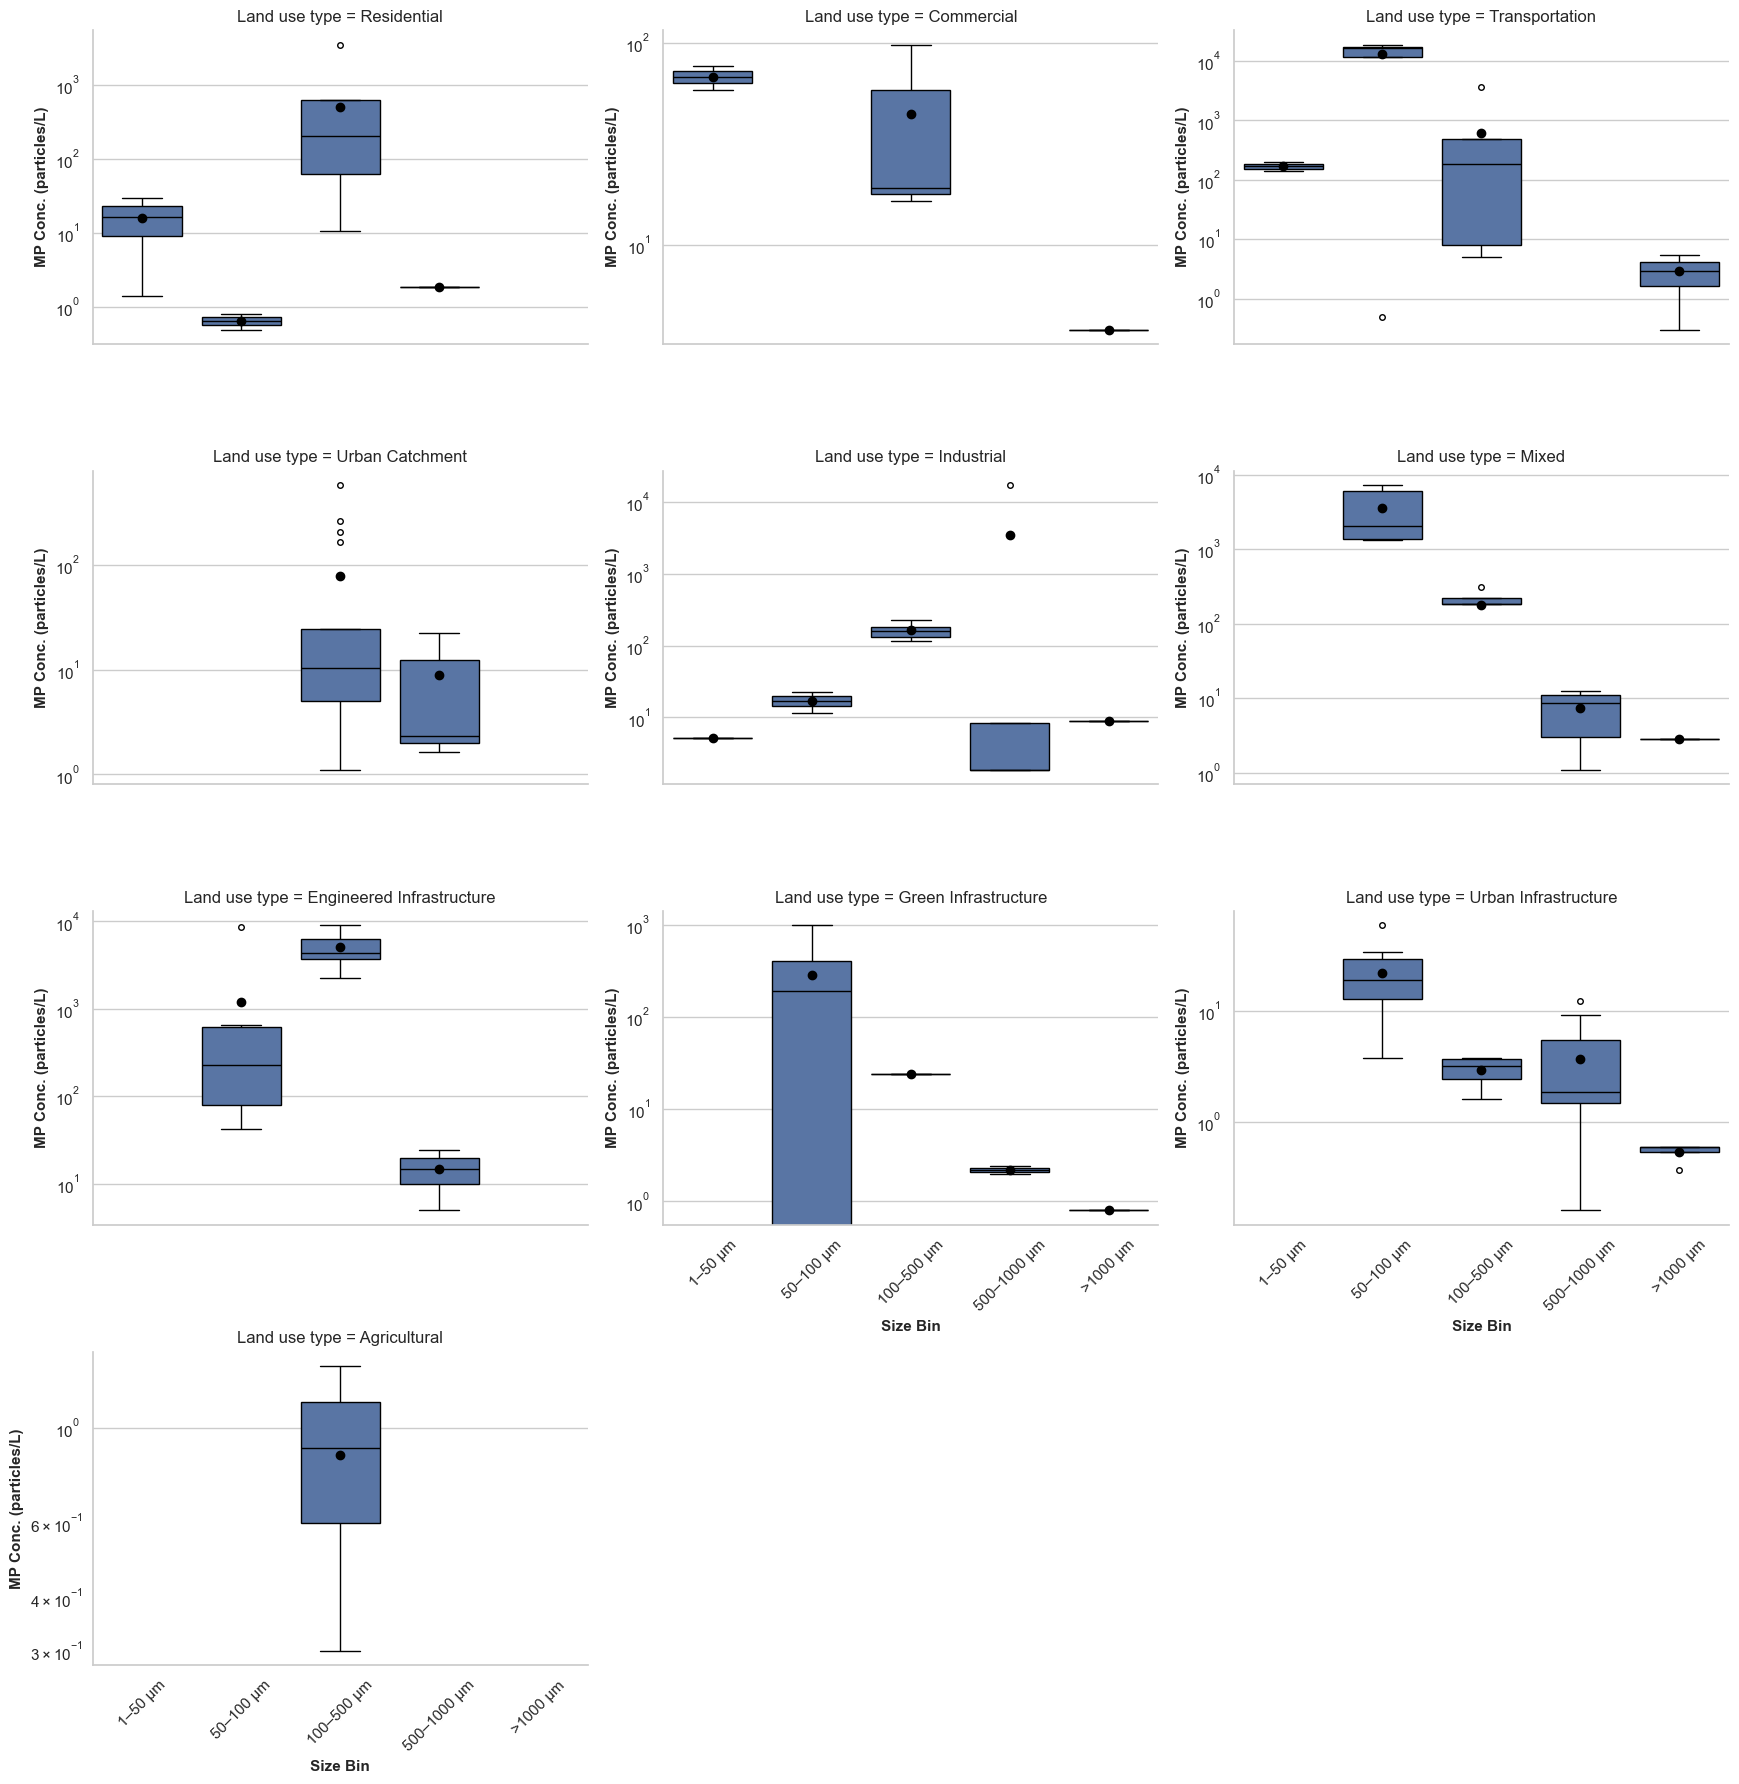

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Excel File ===
file_path = "Urban Runoff MP Database_072025.xlsx"  # Ensure this file is in the same folder
df = pd.read_excel(file_path, sheet_name=0)
df.columns = df.columns.str.strip()  # Clean column names

# === Step 1: Clean and Classify Land Use Tags ===
def clean_land_use_tag(tag):
    if pd.isna(tag):
        return "Unknown"
    
    tag = tag.strip().lower()
    if tag in ["residential"]:
        return "Residential"
    elif tag in ["commercial"]:
        return "Commercial"
    elif tag in ["industrial"]:
        return "Industrial"
    elif tag in ["transportation"]:
        return "Transportation"
    elif tag in ["agricultural"]:
        return "Agricultural"
    elif tag in ["mixed"]:
        return "Mixed"
    elif tag in ["green infrastructure"]:
        return "Green Infrastructure"
    elif tag in ["engineered infrastructure"]:
        return "Engineered Infrastructure"
    elif tag in ["urban infrastructure"]:
        return "Urban Infrastructure"
    elif tag in ["urban catchment"]:
        return "Urban Catchment"
    else:
        return "Other"

# Apply tag cleaning and rename the output to 'Land use type'
df["Land use type"] = df["Land Use Tags"].apply(clean_land_use_tag)

# === Step 2: Filter valid entries ===
df = df[
    df["Standardized Concentration (particles/L)"].notna() &
    df["Standardized Size Bin"].notna() &
    df["Land use type"].notna()
].copy()

# === Step 3: Set size bin as ordered categorical ===
size_order = ["1–50 µm", "50–100 µm", "100–500 µm", "500–1000 µm", ">1000 µm"]
df["Standardized Size Bin"] = pd.Categorical(df["Standardized Size Bin"], categories=size_order, ordered=True)

# === Step 4: Create the FacetGrid Plot ===
sns.set(style="whitegrid")

g = sns.FacetGrid(
    df,
    col="Land use type",
    col_wrap=3,
    sharey=False,
    height=4.5,
    aspect=1.3
)

g.map_dataframe(
    sns.boxplot,
    x="Standardized Size Bin",
    y="Standardized Concentration (particles/L)",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "none", "markeredgecolor": "black"}
)

# === Step 5: Customize Axis and Labels ===
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_xlabel("Size Bin", fontsize=11, weight='bold')
    ax.set_ylabel("MP Conc. (particles/L)", fontsize=11, weight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


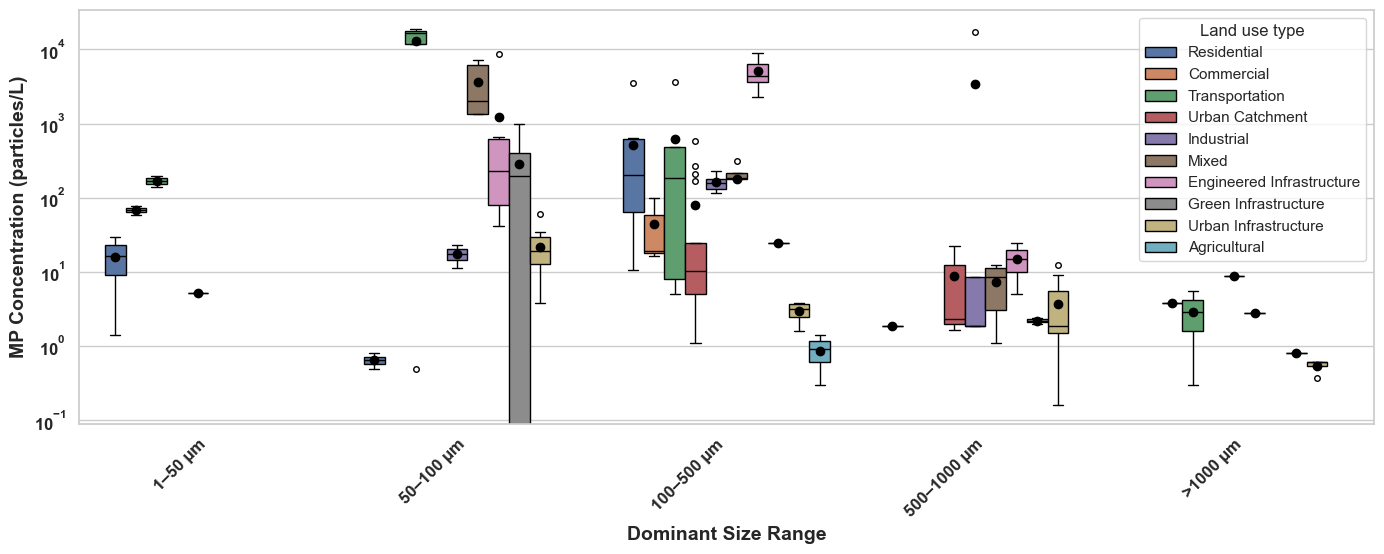

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# === Load and Clean Data ===
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name=0)
df.columns = df.columns.str.strip()

# === Clean Land Use Tags ===
def clean_land_use_tag(tag):
    if pd.isna(tag):
        return "Unknown"
    tag = tag.strip().lower()
    if tag in ["residential"]:
        return "Residential"
    elif tag in ["commercial"]:
        return "Commercial"
    elif tag in ["industrial"]:
        return "Industrial"
    elif tag in ["transportation"]:
        return "Transportation"
    elif tag in ["agricultural"]:
        return "Agricultural"
    elif tag in ["mixed"]:
        return "Mixed"
    elif tag in ["green infrastructure"]:
        return "Green Infrastructure"
    elif tag in ["engineered infrastructure"]:
        return "Engineered Infrastructure"
    elif tag in ["urban infrastructure"]:
        return "Urban Infrastructure"
    elif tag in ["urban catchment"]:
        return "Urban Catchment"
    else:
        return "Other"

df["Land use type"] = df["Land Use Tags"].apply(clean_land_use_tag)

# === Filter Valid Rows ===
df = df[
    df["Standardized Concentration (particles/L)"].notna() &
    df["Standardized Size Bin"].notna() &
    df["Land use type"].notna()
].copy()

# === Set Size Bin as Ordered Category ===
size_order = ["1–50 µm", "50–100 µm", "100–500 µm", "500–1000 µm", ">1000 µm"]
df["Standardized Size Bin"] = pd.Categorical(df["Standardized Size Bin"], categories=size_order, ordered=True)

# === Set Seaborn Style ===
sns.set(style="whitegrid")

# === Create Grouped Boxplot ===
plt.figure(figsize=(14, 6))
ax = sns.boxplot(
    data=df,
    x="Standardized Size Bin",
    y="Standardized Concentration (particles/L)",
    hue="Land use type",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "none", "markeredgecolor": "black"}
)

# === Log Scale & Formatting ===
plt.yscale("log")
plt.xlabel("Dominant Size Range", fontsize=14, weight="bold")
plt.ylabel("MP Concentration (particles/L)", fontsize=14, weight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

# === Custom Legend (Optional) ===
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(title="Land Use Type", fontsize=10, title_fontsize=11, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


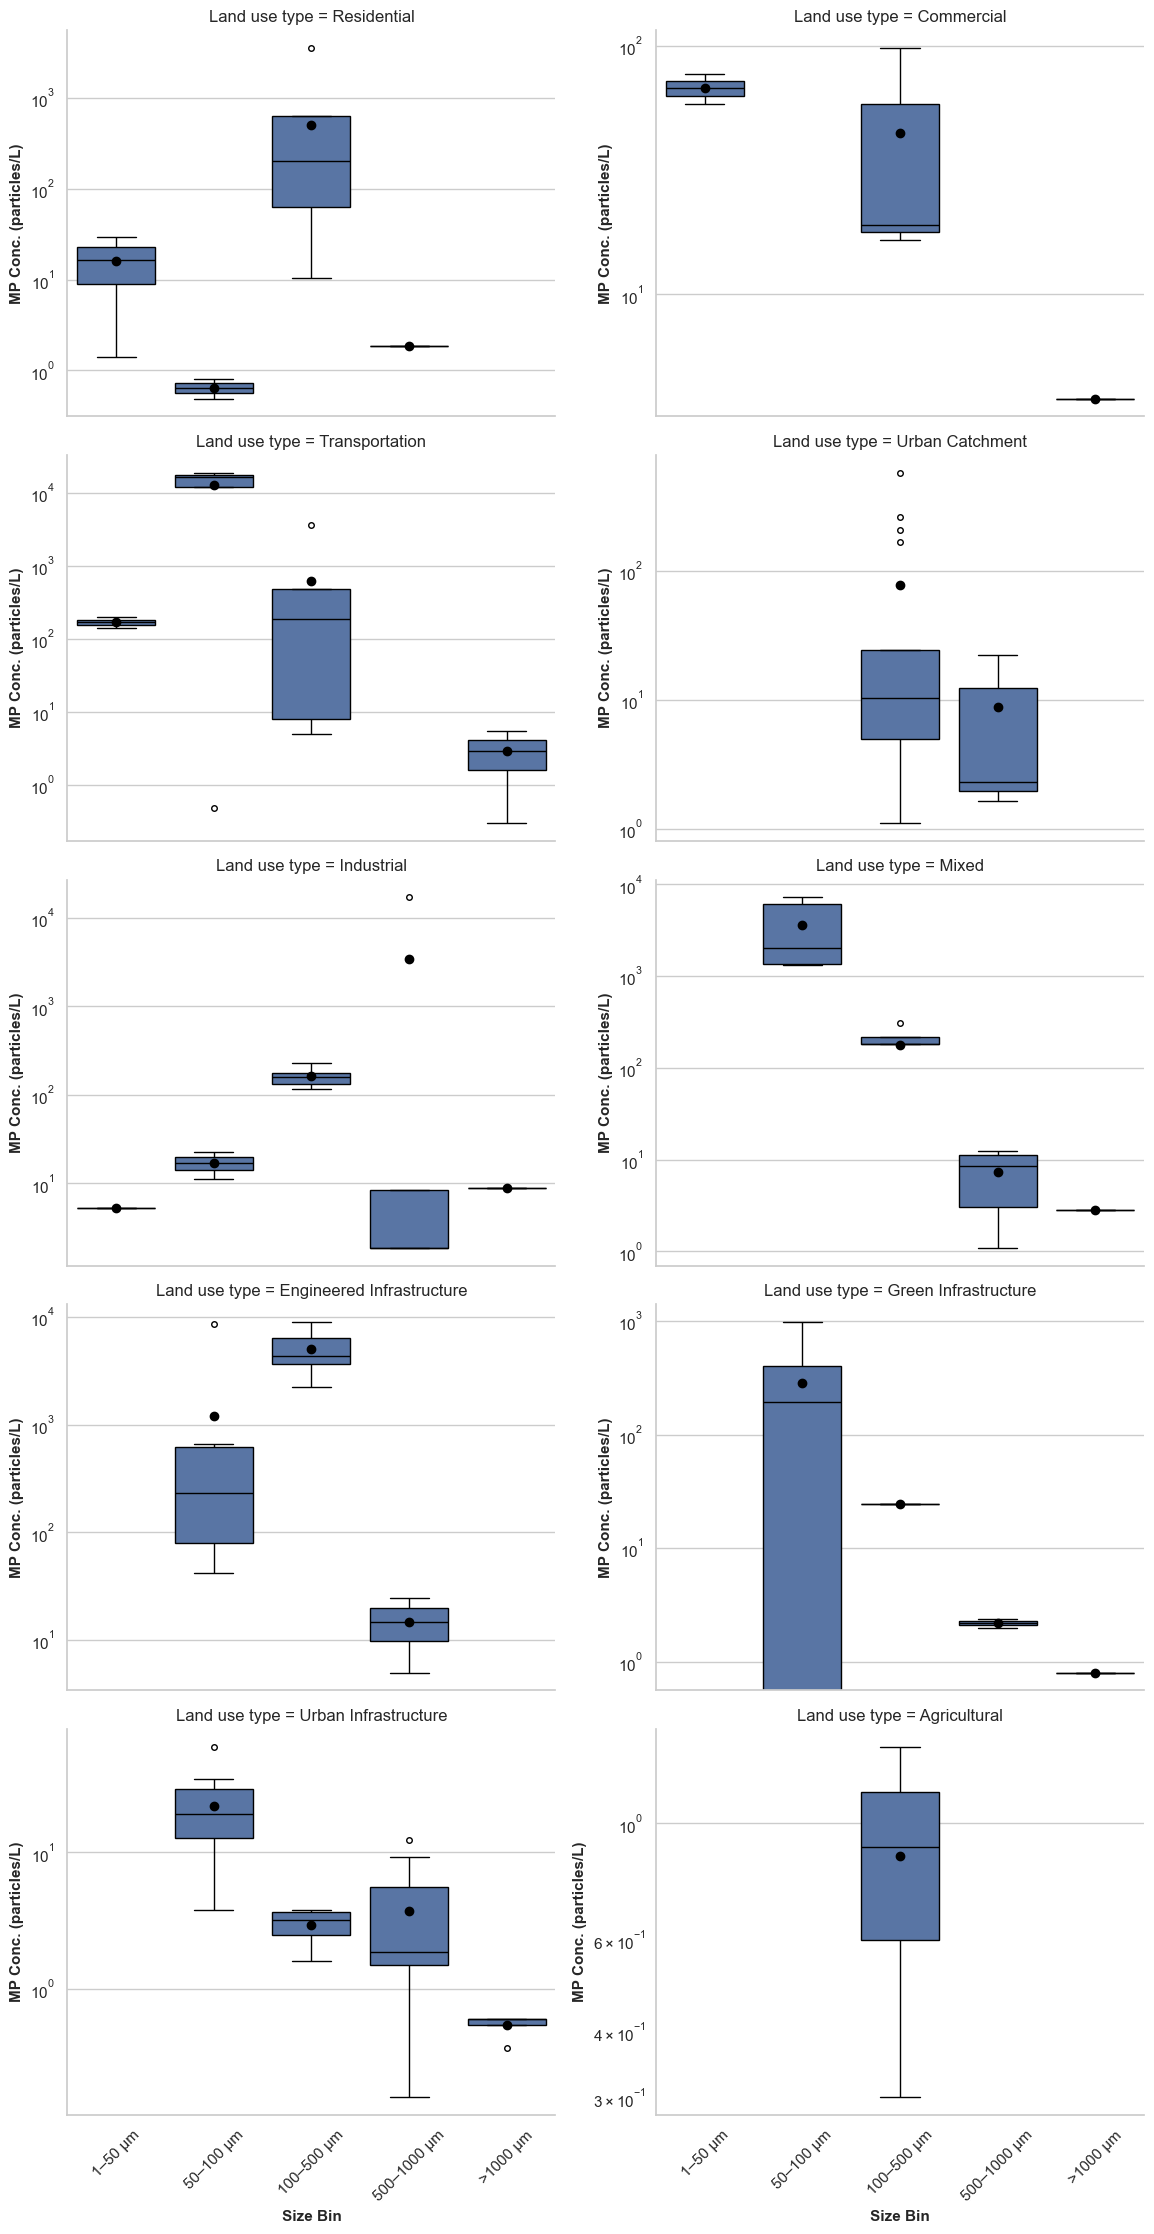

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Excel File ===
file_path = "Urban Runoff MP Database_072025.xlsx"  # Ensure this file is in the same folder
df = pd.read_excel(file_path, sheet_name=0)
df.columns = df.columns.str.strip()  # Clean column names

# === Step 1: Clean and Classify Land Use Tags ===
def clean_land_use_tag(tag):
    if pd.isna(tag):
        return "Unknown"
    
    tag = tag.strip().lower()
    if tag in ["residential"]:
        return "Residential"
    elif tag in ["commercial"]:
        return "Commercial"
    elif tag in ["industrial"]:
        return "Industrial"
    elif tag in ["transportation"]:
        return "Transportation"
    elif tag in ["agricultural"]:
        return "Agricultural"
    elif tag in ["mixed"]:
        return "Mixed"
    elif tag in ["green infrastructure"]:
        return "Green Infrastructure"
    elif tag in ["engineered infrastructure"]:
        return "Engineered Infrastructure"
    elif tag in ["urban infrastructure"]:
        return "Urban Infrastructure"
    elif tag in ["urban catchment"]:
        return "Urban Catchment"
    else:
        return "Other"

# Apply tag cleaning and rename the output to 'Land use type'
df["Land use type"] = df["Land Use Tags"].apply(clean_land_use_tag)

# === Step 2: Filter valid entries ===
df = df[
    df["Standardized Concentration (particles/L)"].notna() &
    df["Standardized Size Bin"].notna() &
    df["Land use type"].notna()
].copy()

# === Step 3: Set size bin as ordered categorical ===
size_order = ["1–50 µm", "50–100 µm", "100–500 µm", "500–1000 µm", ">1000 µm"]
df["Standardized Size Bin"] = pd.Categorical(df["Standardized Size Bin"], categories=size_order, ordered=True)

# === Step 4: Create the FacetGrid Plot ===
sns.set(style="whitegrid")

g = sns.FacetGrid(
    df,
    col="Land use type",
    col_wrap=2,  # ← changed from 3 to 2
    sharey=False,
    height=4.5,
    aspect=1.3
)

g.map_dataframe(
    sns.boxplot,
    x="Standardized Size Bin",
    y="Standardized Concentration (particles/L)",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
    boxprops={"edgecolor": "black"},
    medianprops={"color": "black"},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "none", "markeredgecolor": "black"}
)

# === Step 5: Customize Axis and Labels ===
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_xlabel("Size Bin", fontsize=11, weight='bold')
    ax.set_ylabel("MP Conc. (particles/L)", fontsize=11, weight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# === Load Dataset ===
file_path = "Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# === Standardize Quantification Methods ===
def standardize_quant_method(text):
    if pd.isna(text):
        return "Other"
    
    text_lower = text.lower()
    methods = set()
    
    if any(keyword in text_lower for keyword in ["atr-ftir", "μftir", "ftir-atr", "ftir"]):
        methods.add("FTIR")
    if "raman" in text_lower:
        methods.add("Raman")
    if any(keyword in text_lower for keyword in ["stereomicroscopy", "visual"]):
        methods.add("Microscopy")
    if "gc-ms" in text_lower or "ted-gc-ms" in text_lower:
        methods.add("GC-MS")
    if "sem" in text_lower:
        methods.add("SEM")
    if "hot needle" in text_lower:
        methods.add("Hot Needle")

    if len(methods) == 0:
        return "Other"
    elif len(methods) == 1:
        return list(methods)[0]
    elif methods == {"FTIR", "Raman"}:
        return "FTIR + Raman"
    else:
        return "Multi-method"

# === Apply Function ===
df["Quantification method (standardized)"] = df["Quantification method"].apply(standardize_quant_method)

# === Preview Output ===
display(df[["Quantification method", "Quantification method (standardized)"]].head(15))

# === Optional: Export ===
df[["Quantification method", "Quantification method (standardized)"]].to_excel(
    "Standardized_Quantification_Methods.xlsx", index=False
)


Quantification method  \
0                       ATR-FTIR and Raman microscope   
1                       ATR-FTIR and Raman microscope   
2                       ATR-FTIR and Raman microscope   
3                       ATR-FTIR and Raman microscope   
4                       ATR-FTIR and Raman microscope   
5                       ATR-FTIR and Raman microscope   
6   Stereomicroscopy, Raman spectroscopy, FTIR, an...   
7   Stereomicroscopy, Raman spectroscopy, FTIR, an...   
8   Stereomicroscopy, Raman spectroscopy, FTIR, an...   
9   Stereomicroscopy, Raman spectroscopy, FTIR, an...   
10  Stereomicroscopy, Raman spectroscopy, FTIR, an...   
11  Stereomicroscopy, Raman spectroscopy, FTIR, an...   
12  Stereomicroscopy, Raman spectroscopy, FTIR, an...   
13  Stereomicroscopy, Raman spectroscopy, FTIR, an...   
14  Stereomicroscopy, Raman spectroscopy, FTIR, an...   

   Quantification method (standardized)  
0                          FTIR + Raman  
1                          FTIR + Raman  
2                          FTIR + Raman  
3                          FTIR + Raman  
4                          FTIR + Raman  
5                          FTIR + Raman  
6                          Multi-method  
7                          Multi-method  
8                          Multi-method  
9                          Multi-method  
10                         Multi-method  
11                         Multi-method  
12                         Multi-method  
13                         Multi-method  
14                         Multi-method

In [3]:
import pandas as pd
import numpy as np

# === Step 1: Load Data ===
file_path = "Urban Runoff MP Database_072025.xlsx"  # Ensure this file is in the same directory
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# === Step 2: Clean Sample Volume Column ===
df["Sample volume (cleaned)"] = df["Sample volume"].astype(str).str.lower().str.strip()

# Replace known missing value indicators
df["Sample volume (cleaned)"] = df["Sample volume (cleaned)"].replace({
    "not reported": np.nan,
    "nr": np.nan
})

# Standardize separators and remove 'l'
df["Sample volume (cleaned)"] = df["Sample volume (cleaned)"].str.replace("–", "-", regex=False)
df["Sample volume (cleaned)"] = df["Sample volume (cleaned)"].str.replace("l", "", regex=False)
df["Sample volume (cleaned)"] = df["Sample volume (cleaned)"].str.strip()

# === Step 3: Extract numeric volume (handle ranges) ===
def parse_volume(val):
    try:
        if "-" in val:
            parts = val.split("-")
            parts = [float(p.strip()) for p in parts if p.strip().replace(".", "", 1).isdigit()]
            return sum(parts)/len(parts) if parts else np.nan
        elif val.replace(".", "", 1).isdigit():
            return float(val)
    except:
        return np.nan
    return np.nan

df["Sample volume (L)"] = df["Sample volume (cleaned)"].apply(parse_volume)

# === Step 4: Bin the sample volumes ===
def bin_sample_volume(volume):
    if pd.isna(volume):
        return "Not reported"
    elif volume < 5:
        return "Very Small (<5 L)"
    elif volume <= 50:
        return "Small (5–50 L)"
    elif volume <= 250:
        return "Medium (51–250 L)"
    elif volume <= 750:
        return "Large (251–750 L)"
    else:
        return "Very Large (>750 L)"

df["Sample volume bin"] = df["Sample volume (L)"].apply(bin_sample_volume)

# === Step 5: Optional – Export to Excel ===
output_columns = ["Sample volume", "Sample volume (L)", "Sample volume bin"]
# df[output_columns].to_excel("Sample_Volume_Binned_Output.xlsx", index=False)

# === Step 6: Show first few rows for confirmation ===
df[output_columns].head(10)


Sample volume  Sample volume (L)  Sample volume bin
0           1 L                1.0  Very Small (<5 L)
1           1 L                1.0  Very Small (<5 L)
2           1 L                1.0  Very Small (<5 L)
3           1 L                1.0  Very Small (<5 L)
4           1 L                1.0  Very Small (<5 L)
5           1 L                1.0  Very Small (<5 L)
6         197 L              197.0  Medium (51–250 L)
7         114 L              114.0  Medium (51–250 L)
8          67 L               67.0  Medium (51–250 L)
9         115 L              115.0  Medium (51–250 L)

C:\Users\prott\AppData\Local\Temp\ipykernel_19752\463155924.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\prott\AppData\Local\Temp\ipykernel_19752\463155924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\prott\AppData\Local\Temp\ipykernel_19752\463155924.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


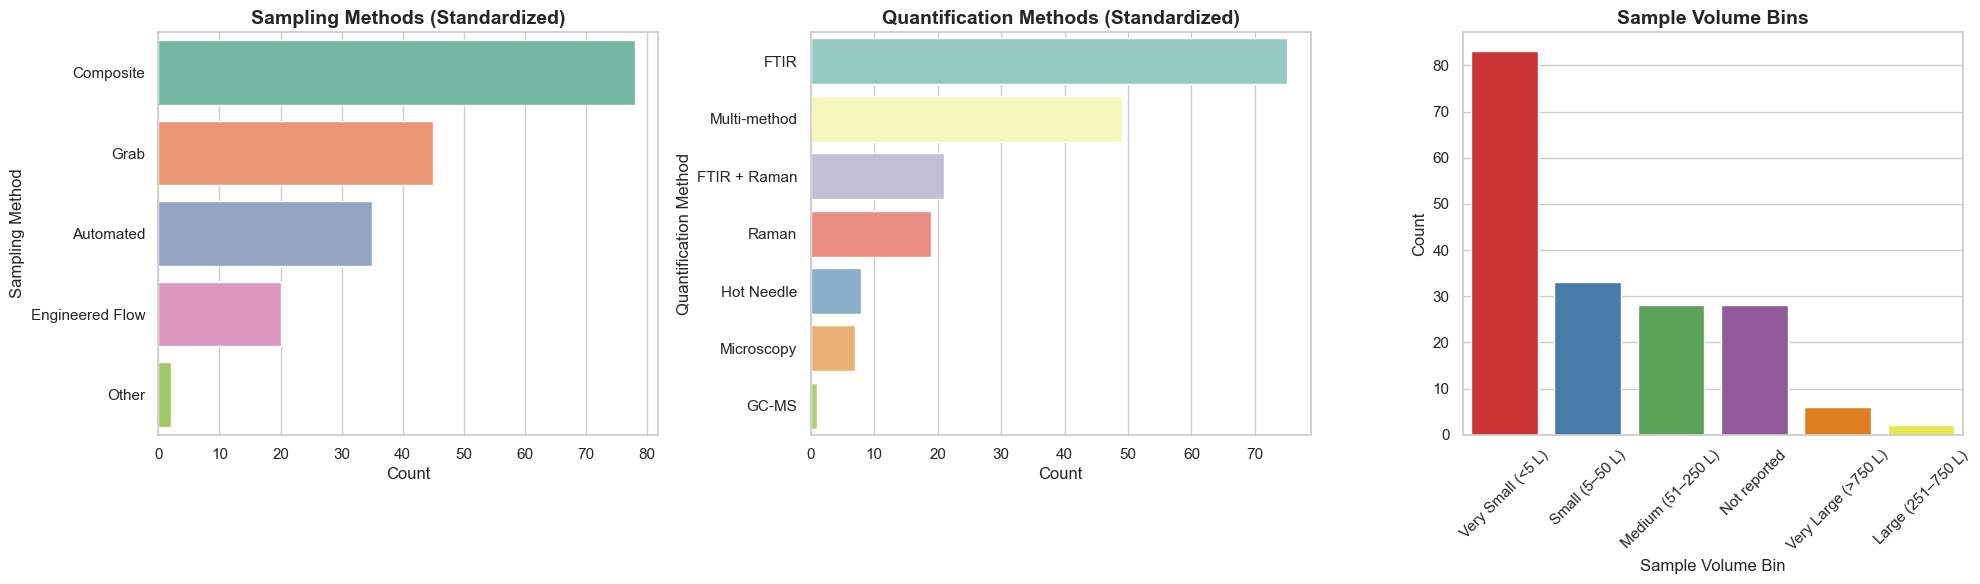

In [4]:
# === Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Dataset ===
file_path = "Urban Runoff MP Database_072025.xlsx"  # Ensure this file is in the same folder
df = pd.read_excel(file_path)

# === Set Plot Style ===
sns.set(style="whitegrid")

# === Create Subplots ===
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# === Plot 1: Sampling method (standardized) ===
sns.countplot(
    data=df,
    y="Sampling method (standardized)",
    order=df["Sampling method (standardized)"].value_counts().index,
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("Sampling Methods (Standardized)", fontsize=14, weight="bold")
axes[0].set_xlabel("Count", fontsize=12)
axes[0].set_ylabel("Sampling Method", fontsize=12)

# === Plot 2: Quantification method (standardized) ===
sns.countplot(
    data=df,
    y="Quantification method (standardized)",
    order=df["Quantification method (standardized)"].value_counts().index,
    palette="Set3",
    ax=axes[1]
)
axes[1].set_title("Quantification Methods (Standardized)", fontsize=14, weight="bold")
axes[1].set_xlabel("Count", fontsize=12)
axes[1].set_ylabel("Quantification Method", fontsize=12)

# === Plot 3: Sample volume bin ===
sns.countplot(
    data=df,
    x="Sample volume bin",
    order=df["Sample volume bin"].value_counts().index,
    palette="Set1",
    ax=axes[2]
)
axes[2].set_title("Sample Volume Bins", fontsize=14, weight="bold")
axes[2].set_xlabel("Sample Volume Bin", fontsize=12)
axes[2].set_ylabel("Count", fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

# === Final Formatting ===
plt.tight_layout()
plt.show()


Total records with valid concentration: 179

1. GEOGRAPHIC ANALYSIS BY COUNTRY

Records per country:
Series([], Name: count, dtype: int64)

Countries with n>=3: 0

Countries with n>=4: 0

Countries with n>=5: 0

NOTE: Insufficient countries for statistical comparison. Using all countries.

Only one country with sufficient data - no statistical test performed

Summary statistics by country:
Empty DataFrame
Columns: [count, median, mean, Q1, Q3]
Index: []


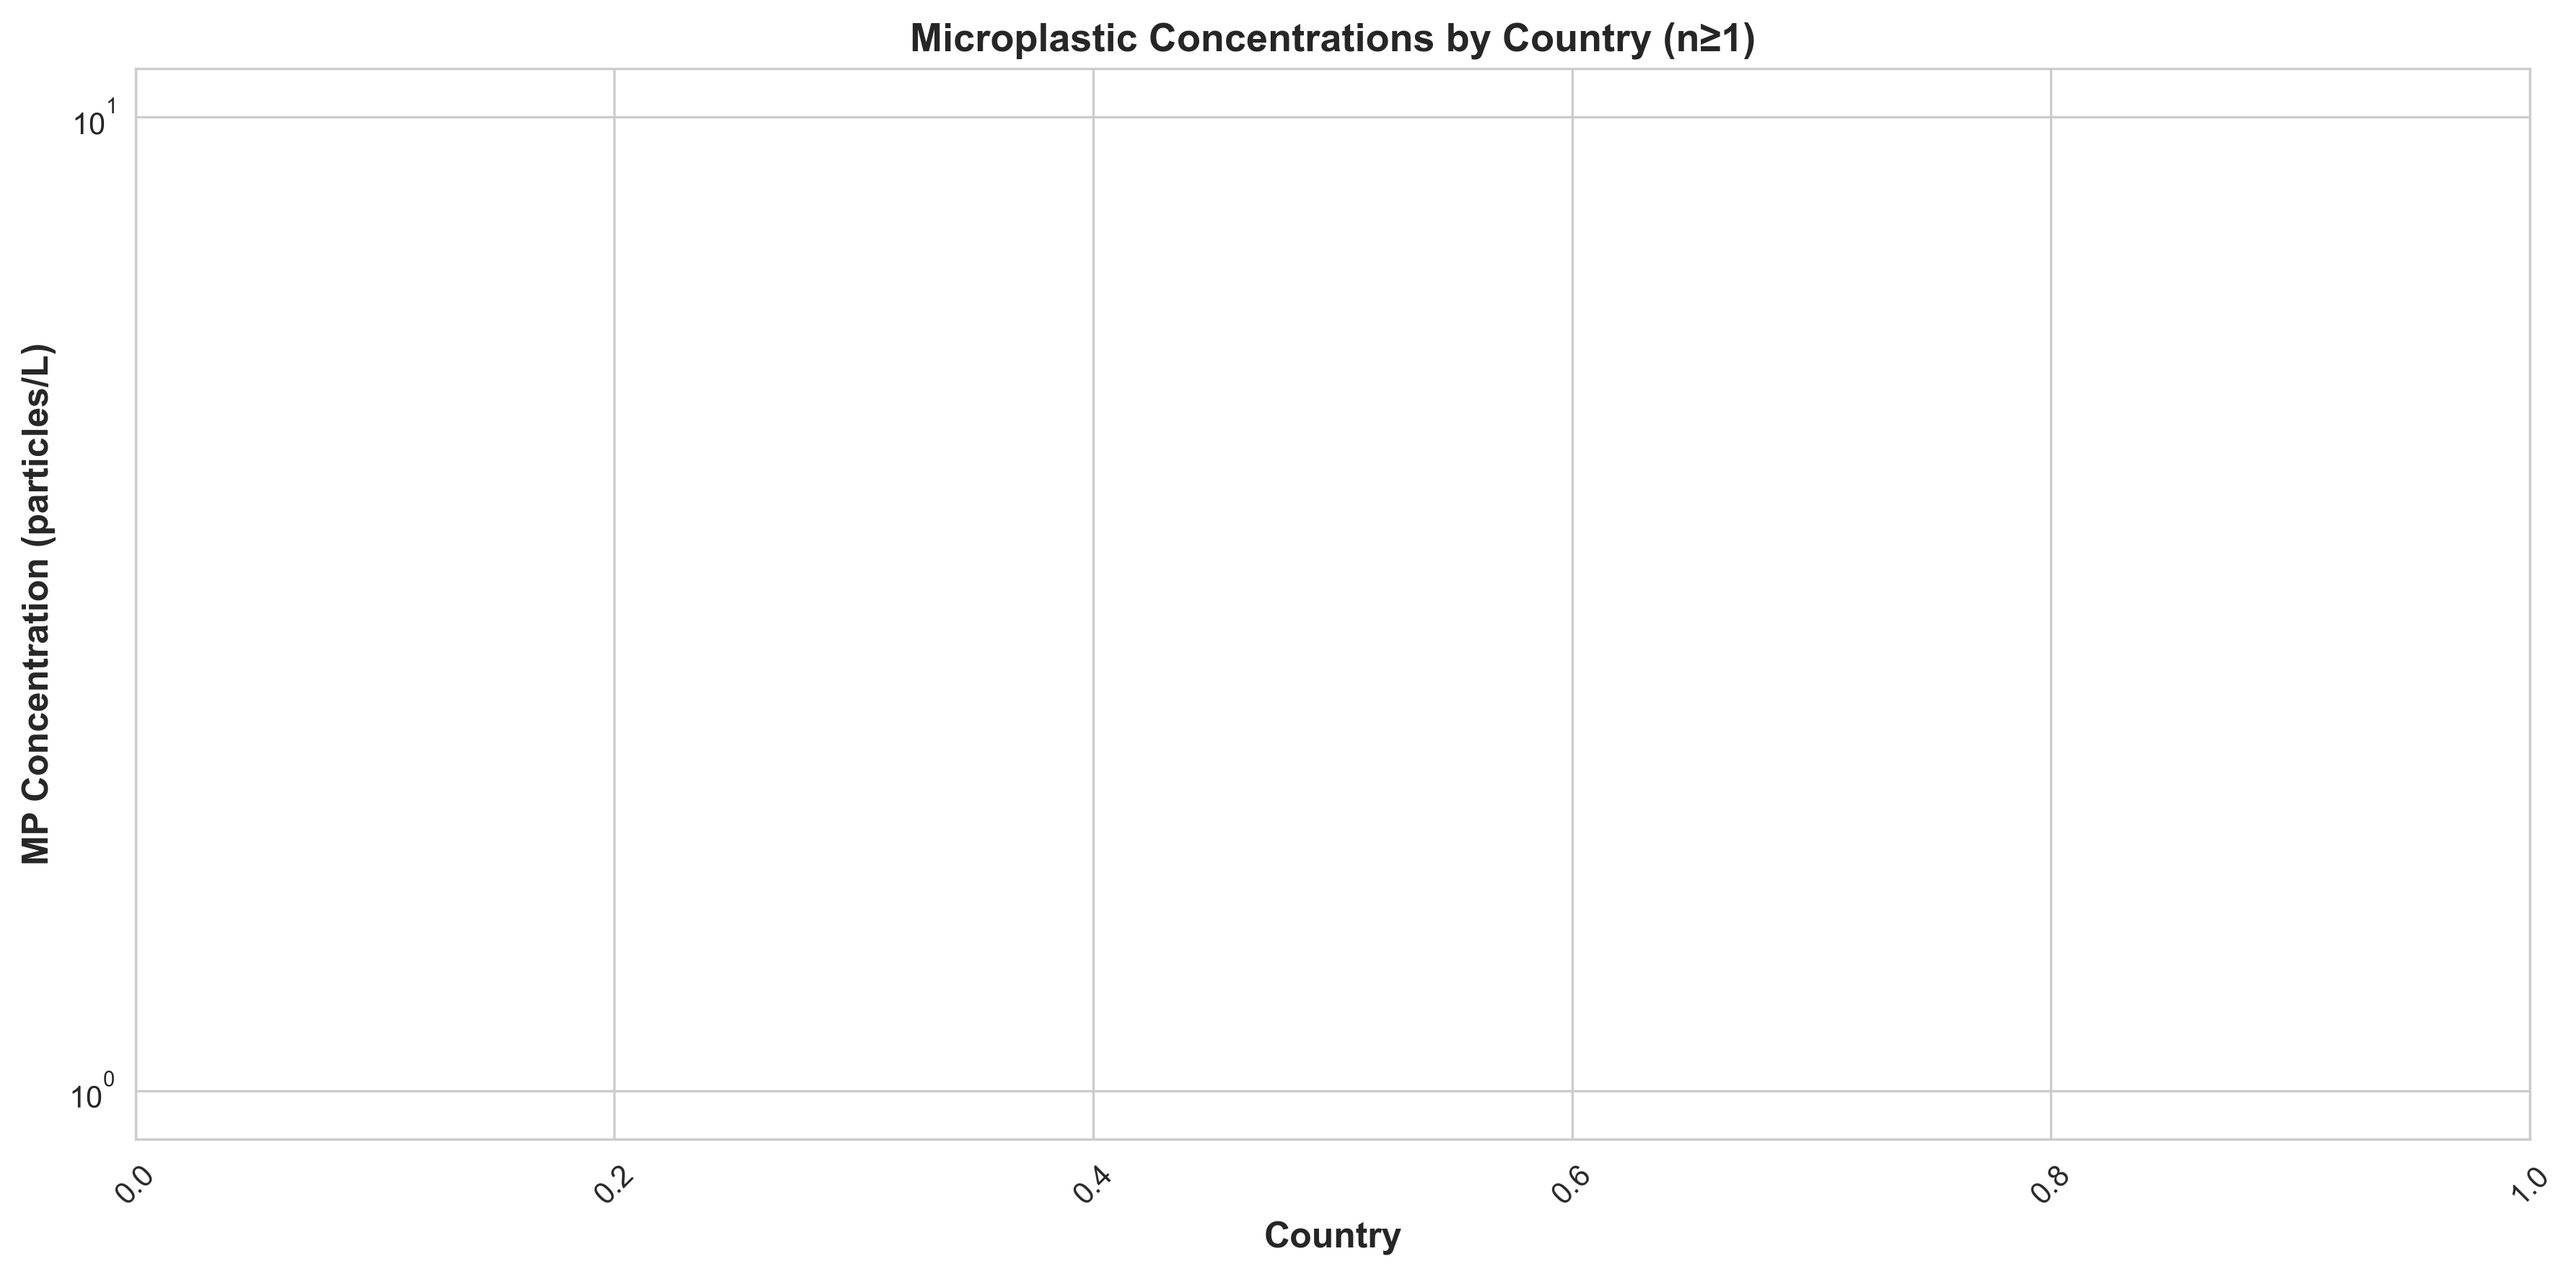


2. LAND USE ANALYSIS

Records per land use:
Land Use Tags
Urban Infrastructure         37
Green infrastructure         24
Residential                  23
Urban catchment              20
Engineered infrastructure    17
Transportation               17
Mixed                        17
Industrial                   15
Commercial                    6
Agricultural                  3
Name: count, dtype: int64

Land uses with n>=3: 10

Kruskal-Wallis test: H=46.000, p=6.021e-07

Summary statistics by land use:
                           count  median     mean     Q1       Q3
Land Use Tags                                                    
Engineered infrastructure     17  618.00  2437.67  80.00  4250.00
Transportation                17  197.50  4133.41   6.29  3612.60
Mixed                         17  180.70  1113.66   7.20  1327.00
Residential                   23   84.00   307.73  14.34   211.05
Green infrastructure          24   73.15   213.47   0.12   324.75
Commercial                     

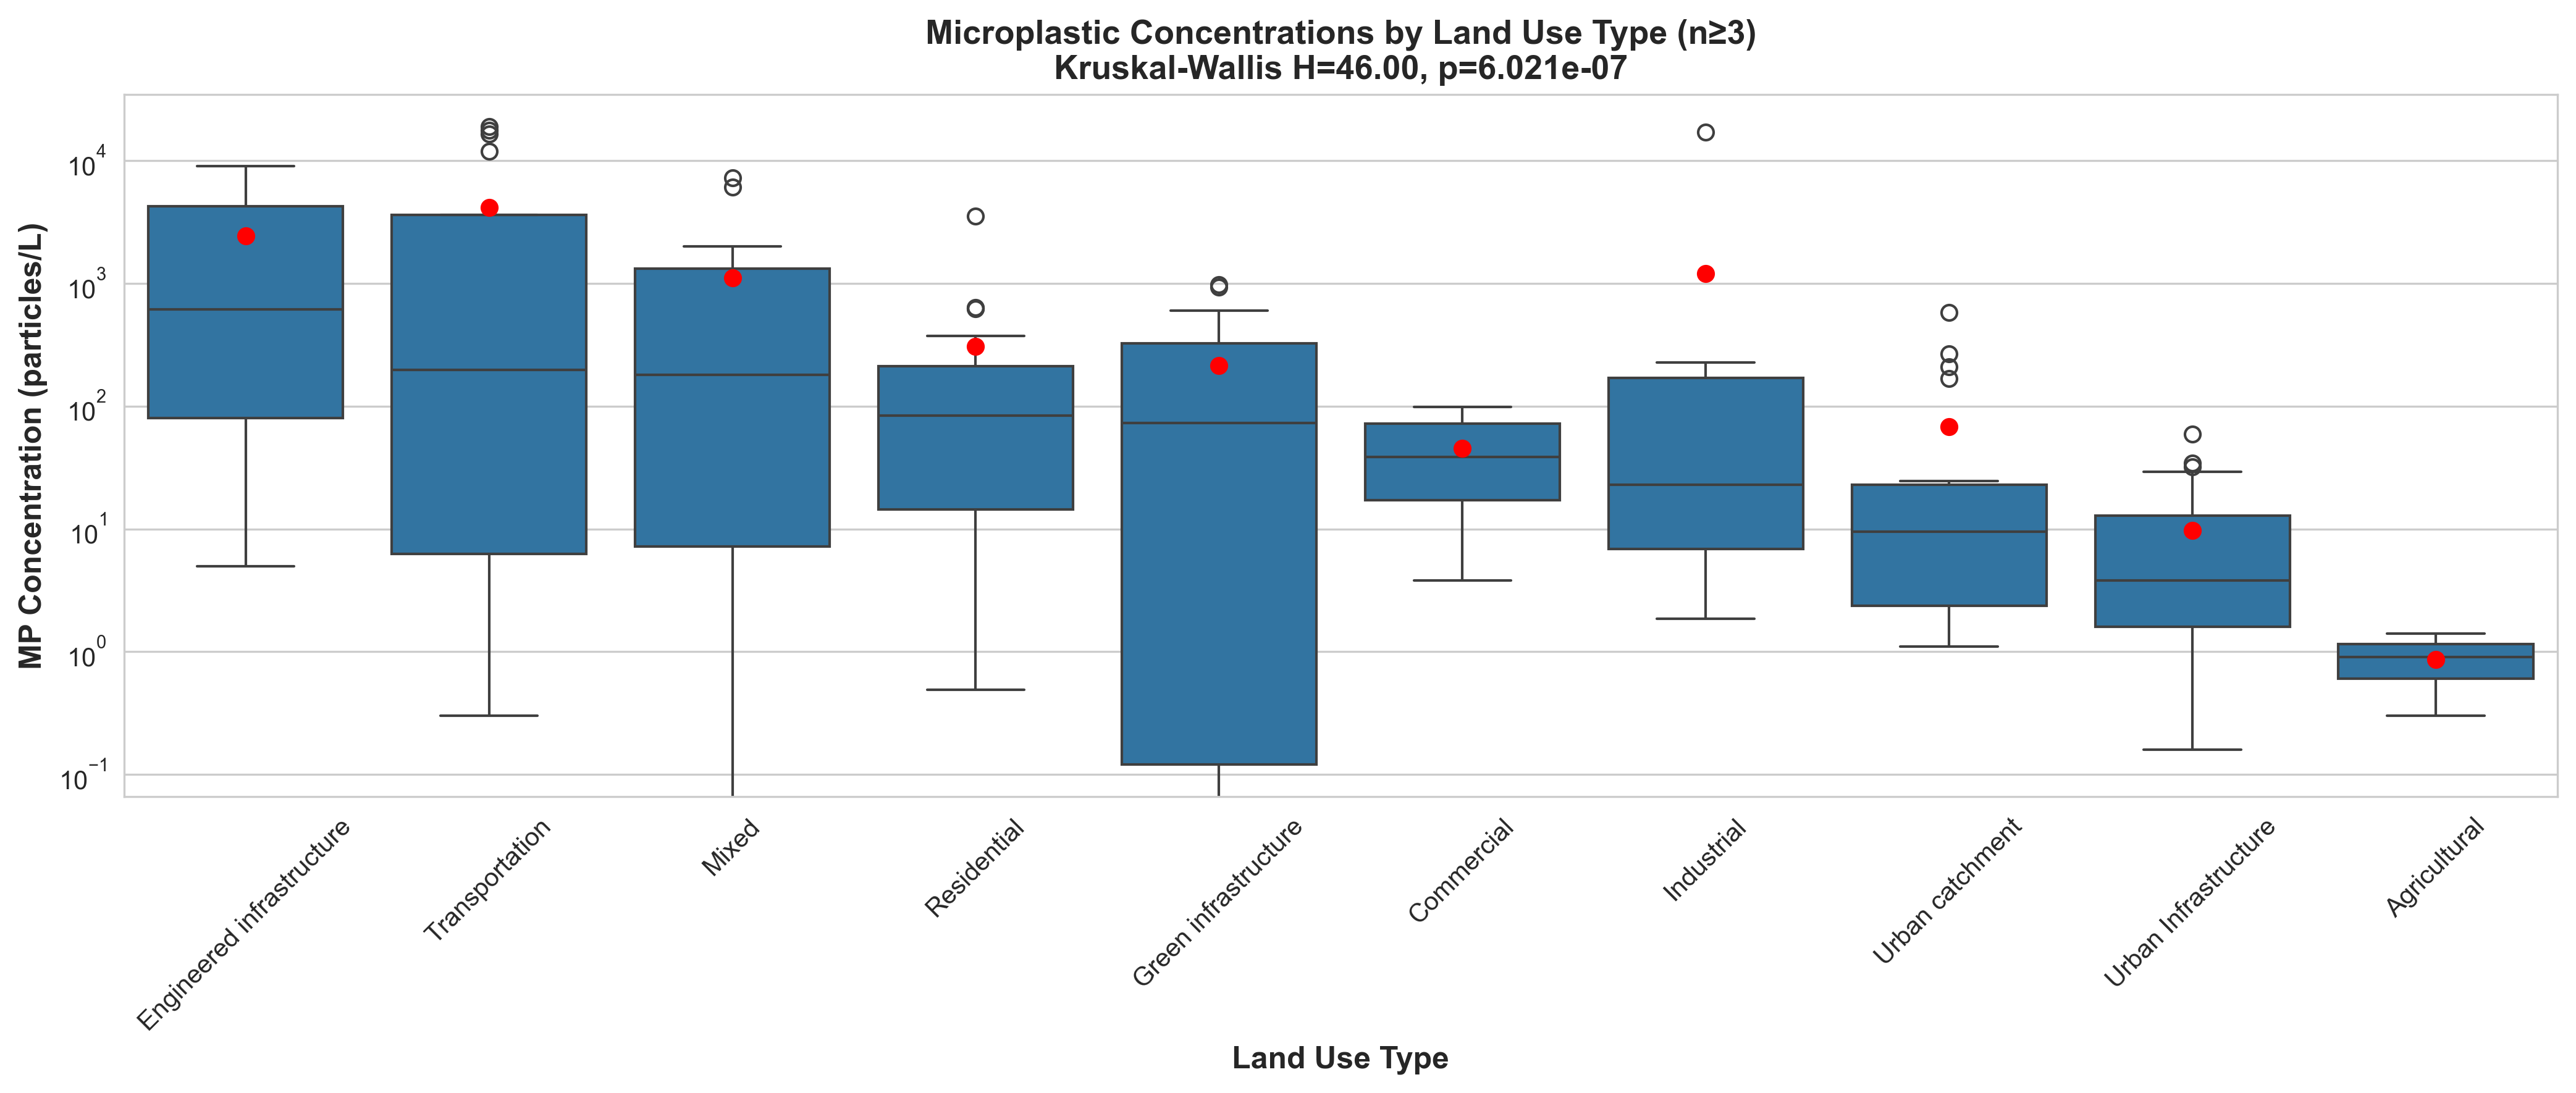


3. METHODOLOGICAL INFLUENCES

--- 3A. SAMPLING METHOD ---

Records per sampling method:
Sampling method (standardized)
Composite          78
Grab               44
Automated          35
Engineered Flow    20
Other               2
Name: count, dtype: int64

Kruskal-Wallis test: H=15.067, p=1.760e-03

Summary by sampling method:
                                count  median     mean
Sampling method (standardized)                        
Engineered Flow                    20  193.00   273.25
Automated                          35  116.20   997.95
Grab                               44   12.24  1520.58
Composite                          78    7.48   713.59

--- 3B. QUANTIFICATION METHOD ---

Records per quantification method:
Quantification method (standardized)
FTIR            75
Multi-method    49
FTIR + Raman    21
Raman           19
Hot Needle       8
Microscopy       7
Name: count, dtype: int64

Kruskal-Wallis test: H=28.787, p=2.553e-05

Summary by quantification method:
              

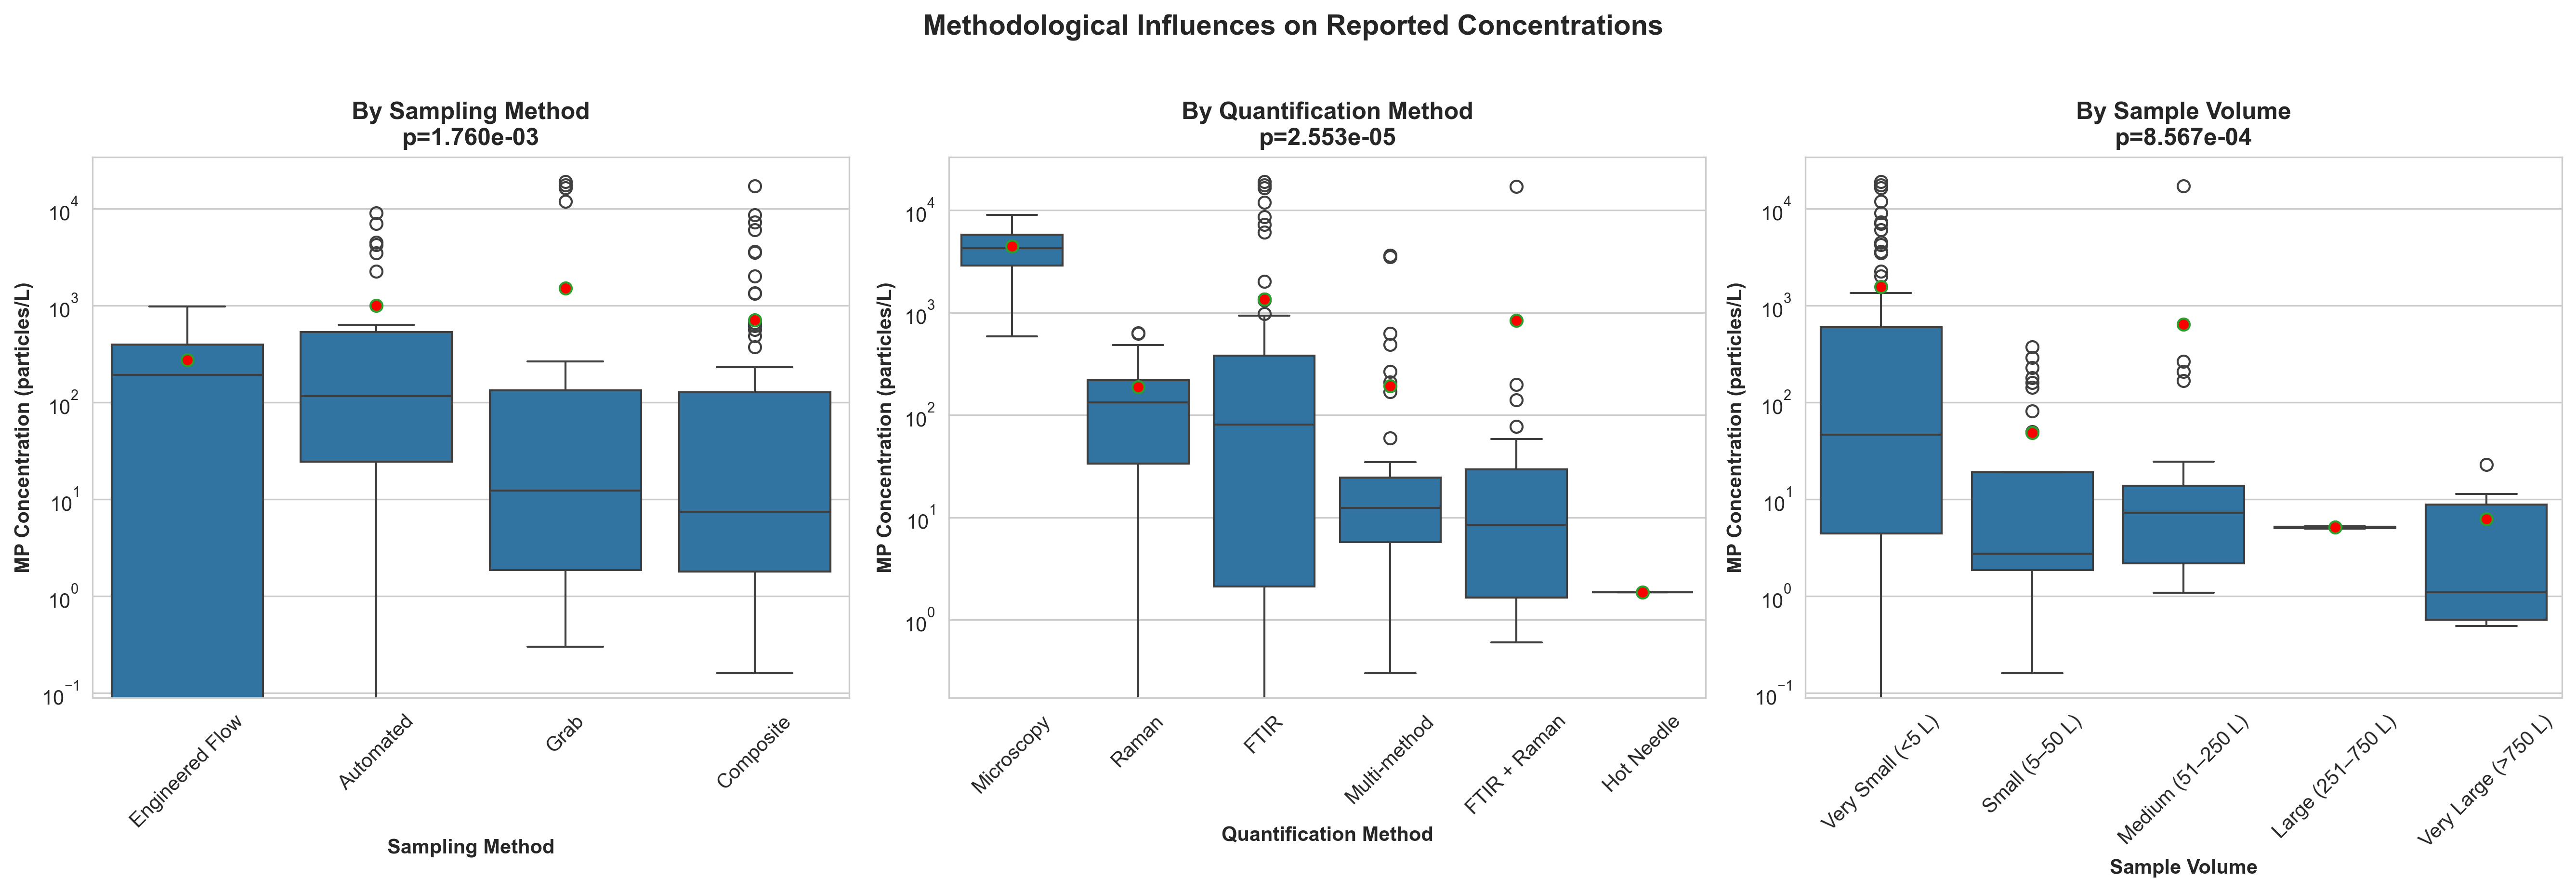


4. ENVIRONMENTAL CORRELATIONS

Antecedent dry days:
  N = 45
  Pearson: r = 0.521, p = 2.423e-04
  Spearman: ρ = 0.326, p = 2.902e-02

Total rainfall: Insufficient data (n=1)

Temperature: Insufficient data (n=0)

Average wind speed: Insufficient data (n=0)

CORRELATION SUMMARY TABLE
           Variable  N  Pearson_r  Pearson_p  Spearman_rho  Spearman_p
Antecedent dry days 45   0.521111   0.000242      0.325692    0.029018


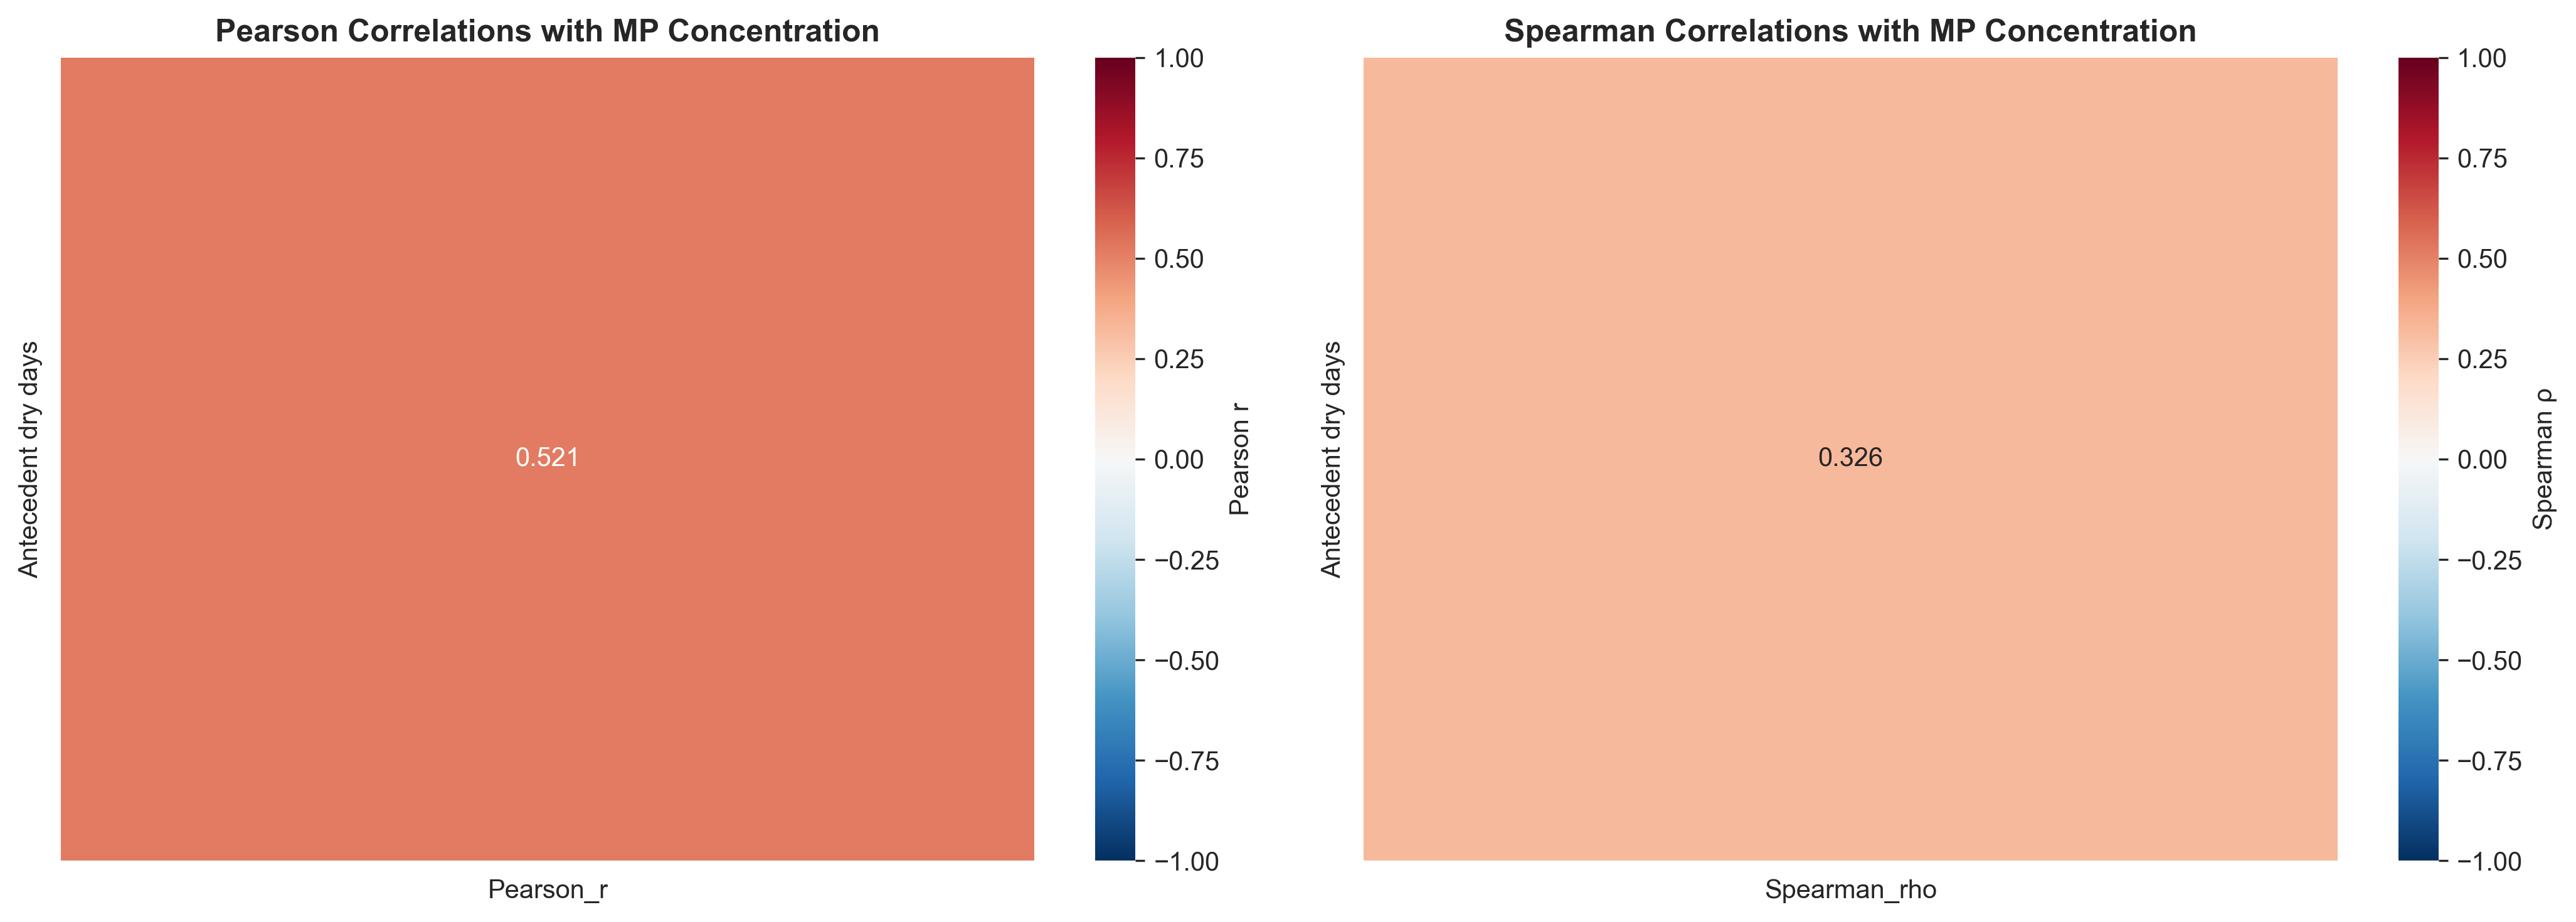

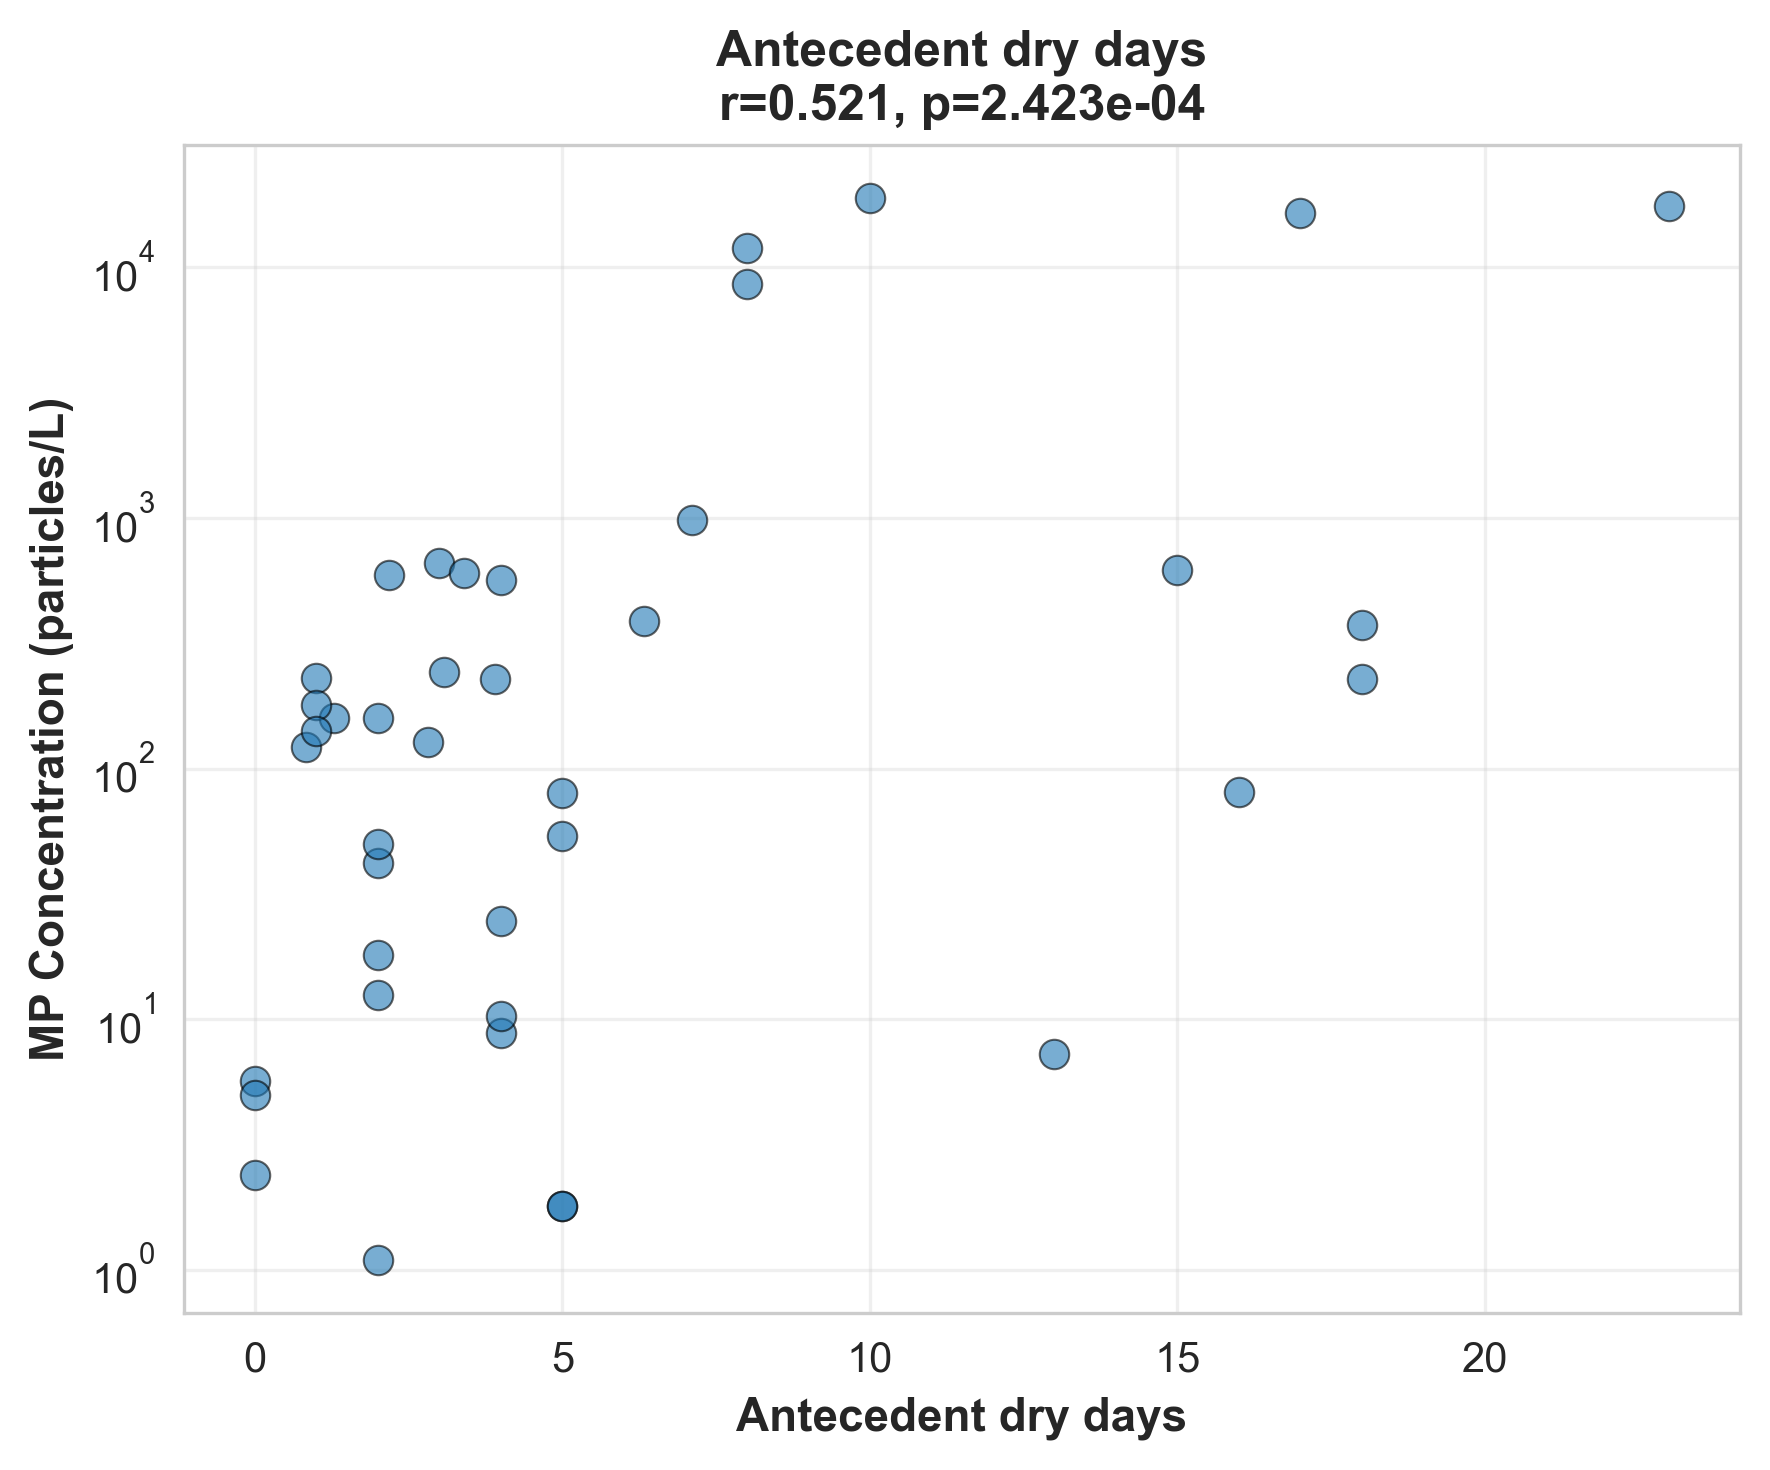


ANALYSIS COMPLETE!

Check the generated PNG files for visualizations


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# ============================================================================
# LOAD DATA
# ============================================================================
file_path = r"C:\Users\ai22h\OneDrive - Florida State University\Weekly Meeting_EA\MP Data Analysis_Experimental\My Database_Urban\Paper materials\Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database")
df.columns = df.columns.str.strip()

# Get standardized concentration
conc_col = "Standardized Concentration (particles/L)"
df = df[pd.to_numeric(df[conc_col], errors="coerce").notna()].copy()
df[conc_col] = df[conc_col].astype(float)

print(f"Total records with valid concentration: {len(df)}")

# ============================================================================
# 1. GEOGRAPHIC COMPARISONS BY COUNTRY
# ============================================================================

print("\n" + "="*80)
print("1. GEOGRAPHIC ANALYSIS BY COUNTRY")
print("="*80)

# Get country counts
country_counts = df['Country'].value_counts()
print("\nRecords per country:")
print(country_counts)

# Try different minimum thresholds
for min_n in [3, 4, 5]:
    countries_to_plot = country_counts[country_counts >= min_n].index
    print(f"\nCountries with n>={min_n}: {len(countries_to_plot)}")
    if len(countries_to_plot) >= 2:
        break

if len(countries_to_plot) < 2:
    print("\nNOTE: Insufficient countries for statistical comparison. Using all countries.")
    countries_to_plot = country_counts.index
    min_n = 1

df_country = df[df['Country'].isin(countries_to_plot)].copy()

# Statistical test (only if >=2 groups)
if len(countries_to_plot) >= 2:
    country_groups = [df_country[df_country['Country']==c][conc_col].values 
                      for c in countries_to_plot]
    # Filter out empty groups
    country_groups = [g for g in country_groups if len(g) > 0]
    
    if len(country_groups) >= 2:
        H_stat, p_val = stats.kruskal(*country_groups)
        print(f"\nKruskal-Wallis test: H={H_stat:.3f}, p={p_val:.3e}")
    else:
        H_stat, p_val = None, None
        print("\nInsufficient groups for statistical test")
else:
    H_stat, p_val = None, None
    print("\nOnly one country with sufficient data - no statistical test performed")

# Summary statistics by country
country_stats = df_country.groupby('Country')[conc_col].agg([
    'count', 'median', 'mean', 
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(2)
print("\nSummary statistics by country:")
print(country_stats.sort_values('median', ascending=False))

# PLOT: Box plots by country
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=df_country, 
    x='Country', 
    y=conc_col,
    order=country_stats.sort_values('median', ascending=False).index,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
    ax=ax
)
ax.set_yscale('log')
ax.set_ylabel('MP Concentration (particles/L)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

title = f'Microplastic Concentrations by Country (n≥{min_n})'
if H_stat is not None:
    title += f'\nKruskal-Wallis H={H_stat:.2f}, p={p_val:.3e}'
ax.set_title(title, fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('country_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 2. LAND USE COMPARISONS
# ============================================================================

print("\n" + "="*80)
print("2. LAND USE ANALYSIS")
print("="*80)

# Get land use counts
landuse_counts = df['Land Use Tags'].value_counts()
print("\nRecords per land use:")
print(landuse_counts)

# Try different minimum thresholds
for min_n_landuse in [3, 4, 5]:
    landuses_to_plot = landuse_counts[landuse_counts >= min_n_landuse].index
    print(f"\nLand uses with n>={min_n_landuse}: {len(landuses_to_plot)}")
    if len(landuses_to_plot) >= 2:
        break

if len(landuses_to_plot) < 2:
    print("\nNOTE: Insufficient land uses for comparison. Using all land uses.")
    landuses_to_plot = landuse_counts.index
    min_n_landuse = 1

df_landuse = df[df['Land Use Tags'].isin(landuses_to_plot)].copy()

# Statistical test
if len(landuses_to_plot) >= 2:
    landuse_groups = [df_landuse[df_landuse['Land Use Tags']==lu][conc_col].values 
                      for lu in landuses_to_plot]
    landuse_groups = [g for g in landuse_groups if len(g) > 0]
    
    if len(landuse_groups) >= 2:
        H_stat_lu, p_val_lu = stats.kruskal(*landuse_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_lu:.3f}, p={p_val_lu:.3e}")
    else:
        H_stat_lu, p_val_lu = None, None
else:
    H_stat_lu, p_val_lu = None, None

# Summary statistics by land use
landuse_stats = df_landuse.groupby('Land Use Tags')[conc_col].agg([
    'count', 'median', 'mean',
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(2)
print("\nSummary statistics by land use:")
print(landuse_stats.sort_values('median', ascending=False))

# PLOT: Box plots by land use
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(
    data=df_landuse,
    x='Land Use Tags',
    y=conc_col,
    order=landuse_stats.sort_values('median', ascending=False).index,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
    ax=ax
)
ax.set_yscale('log')
ax.set_ylabel('MP Concentration (particles/L)', fontsize=12, fontweight='bold')
ax.set_xlabel('Land Use Type', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

title = f'Microplastic Concentrations by Land Use Type (n≥{min_n_landuse})'
if H_stat_lu is not None:
    title += f'\nKruskal-Wallis H={H_stat_lu:.2f}, p={p_val_lu:.3e}'
ax.set_title(title, fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('landuse_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. METHODOLOGICAL INFLUENCES
# ============================================================================

print("\n" + "="*80)
print("3. METHODOLOGICAL INFLUENCES")
print("="*80)

# 3A. Sampling Method
print("\n--- 3A. SAMPLING METHOD ---")
sampling_counts = df['Sampling method (standardized)'].value_counts()
print("\nRecords per sampling method:")
print(sampling_counts)

min_n_method = 5
methods_to_plot = sampling_counts[sampling_counts >= min_n_method].index
df_method = df[df['Sampling method (standardized)'].isin(methods_to_plot)].copy()

if len(methods_to_plot) >= 2:
    method_groups = [df_method[df_method['Sampling method (standardized)']==m][conc_col].values 
                     for m in methods_to_plot]
    method_groups = [g for g in method_groups if len(g) > 0]
    
    if len(method_groups) >= 2:
        H_stat_method, p_val_method = stats.kruskal(*method_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_method:.3f}, p={p_val_method:.3e}")
        
        method_stats = df_method.groupby('Sampling method (standardized)')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by sampling method:")
        print(method_stats.sort_values('median', ascending=False))
    else:
        H_stat_method, p_val_method = None, None
else:
    H_stat_method, p_val_method = None, None
    print("Insufficient sampling methods for comparison")

# 3B. Quantification Method
print("\n--- 3B. QUANTIFICATION METHOD ---")
quant_counts = df['Quantification method (standardized)'].value_counts()
print("\nRecords per quantification method:")
print(quant_counts)

quant_to_plot = quant_counts[quant_counts >= min_n_method].index
df_quant = df[df['Quantification method (standardized)'].isin(quant_to_plot)].copy()

if len(quant_to_plot) >= 2:
    quant_groups = [df_quant[df_quant['Quantification method (standardized)']==q][conc_col].values 
                    for q in quant_to_plot]
    quant_groups = [g for g in quant_groups if len(g) > 0]
    
    if len(quant_groups) >= 2:
        H_stat_quant, p_val_quant = stats.kruskal(*quant_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_quant:.3f}, p={p_val_quant:.3e}")
        
        quant_stats = df_quant.groupby('Quantification method (standardized)')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by quantification method:")
        print(quant_stats.sort_values('median', ascending=False))
    else:
        H_stat_quant, p_val_quant = None, None
else:
    H_stat_quant, p_val_quant = None, None
    print("Insufficient quantification methods for comparison")

# 3C. Sample Volume
print("\n--- 3C. SAMPLE VOLUME ---")
volume_counts = df['Sample volume bin'].value_counts()
print("\nRecords per volume bin:")
print(volume_counts)

volume_order = ['Very Small (<5 L)', 'Small (5–50 L)', 'Medium (51–250 L)', 
                'Large (251–750 L)', 'Very Large (>750 L)']
existing_volumes = [v for v in volume_order if v in df['Sample volume bin'].unique()]

df_volume = df[df['Sample volume bin'].isin(existing_volumes)].copy()

if len(existing_volumes) >= 2:
    volume_groups = [df_volume[df_volume['Sample volume bin']==v][conc_col].values 
                     for v in existing_volumes]
    volume_groups = [g for g in volume_groups if len(g) > 0]
    
    if len(volume_groups) >= 2:
        H_stat_vol, p_val_vol = stats.kruskal(*volume_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_vol:.3f}, p={p_val_vol:.3e}")
        
        volume_stats = df_volume.groupby('Sample volume bin')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by volume bin:")
        print(volume_stats.reindex(existing_volumes))
    else:
        H_stat_vol, p_val_vol = None, None
else:
    H_stat_vol, p_val_vol = None, None

# PLOT: Multi-panel methodological influences (only if data available)
n_panels = sum([
    len(methods_to_plot) >= 2 and H_stat_method is not None,
    len(quant_to_plot) >= 2 and H_stat_quant is not None,
    len(existing_volumes) >= 2 and H_stat_vol is not None
])

if n_panels > 0:
    fig, axes = plt.subplots(1, n_panels, figsize=(6*n_panels, 6))
    if n_panels == 1:
        axes = [axes]
    
    panel_idx = 0
    
    # Sampling method
    if len(methods_to_plot) >= 2 and H_stat_method is not None:
        sns.boxplot(data=df_method, x='Sampling method (standardized)', y=conc_col,
                    order=method_stats.sort_values('median', ascending=False).index,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Sampling Method', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Sampling Method\np={p_val_method:.3e}', fontweight='bold')
        panel_idx += 1
    
    # Quantification method
    if len(quant_to_plot) >= 2 and H_stat_quant is not None:
        sns.boxplot(data=df_quant, x='Quantification method (standardized)', y=conc_col,
                    order=quant_stats.sort_values('median', ascending=False).index,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Quantification Method', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Quantification Method\np={p_val_quant:.3e}', fontweight='bold')
        panel_idx += 1
    
    # Sample volume
    if len(existing_volumes) >= 2 and H_stat_vol is not None:
        sns.boxplot(data=df_volume, x='Sample volume bin', y=conc_col,
                    order=existing_volumes,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Sample Volume', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Sample Volume\np={p_val_vol:.3e}', fontweight='bold')
    
    plt.suptitle('Methodological Influences on Reported Concentrations', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('methodological_influences.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo methodological comparisons available with current data")

# ============================================================================
# 4. ENVIRONMENTAL CORRELATIONS (EXCLUDING LAT/LONG)
# ============================================================================

print("\n" + "="*80)
print("4. ENVIRONMENTAL CORRELATIONS")
print("="*80)

env_vars = {
    'Antecedent dry days': 'Antecedent dry days',
    'Total rainfall': 'Total rainfall',
    'Temperature': 'Temperature',
    'Average wind speed': 'Average wind speed'
}

correlation_results = []

for var_name, var_col in env_vars.items():
    if var_col in df.columns:
        temp_df = df[[conc_col, var_col]].copy()
        temp_df[var_col] = pd.to_numeric(temp_df[var_col], errors='coerce')
        valid_data = temp_df.dropna()
        
        if len(valid_data) >= 3:
            pearson_r, pearson_p = stats.pearsonr(valid_data[conc_col], valid_data[var_col])
            spearman_r, spearman_p = stats.spearmanr(valid_data[conc_col], valid_data[var_col])
            
            correlation_results.append({
                'Variable': var_name,
                'N': len(valid_data),
                'Pearson_r': pearson_r,
                'Pearson_p': pearson_p,
                'Spearman_rho': spearman_r,
                'Spearman_p': spearman_p
            })
            
            print(f"\n{var_name}:")
            print(f"  N = {len(valid_data)}")
            print(f"  Pearson: r = {pearson_r:.3f}, p = {pearson_p:.3e}")
            print(f"  Spearman: ρ = {spearman_r:.3f}, p = {spearman_p:.3e}")
        else:
            print(f"\n{var_name}: Insufficient data (n={len(valid_data)})")

if correlation_results:
    corr_df = pd.DataFrame(correlation_results)
    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(corr_df.to_string(index=False))
    
    # PLOT: Correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pearson_data = corr_df.set_index('Variable')['Pearson_r'].to_frame()
    sns.heatmap(pearson_data, annot=True, fmt='.3f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'},
                ax=axes[0])
    axes[0].set_title('Pearson Correlations with MP Concentration', fontweight='bold')
    axes[0].set_ylabel('')
    
    spearman_data = corr_df.set_index('Variable')['Spearman_rho'].to_frame()
    sns.heatmap(spearman_data, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Spearman ρ'},
                ax=axes[1])
    axes[1].set_title('Spearman Correlations with MP Concentration', fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('environmental_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # PLOT: Scatter plots for significant correlations
    sig_corrs = corr_df[(corr_df['Pearson_p'] < 0.05) | (corr_df['Spearman_p'] < 0.05)]
    
    if len(sig_corrs) > 0:
        n_plots = len(sig_corrs)
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (_, row) in enumerate(sig_corrs.iterrows()):
            var_name = row['Variable']
            var_col_name = env_vars[var_name]
            
            temp_df = df[[conc_col, var_col_name]].copy()
            temp_df[var_col_name] = pd.to_numeric(temp_df[var_col_name], errors='coerce')
            valid_data = temp_df.dropna()
            
            axes[idx].scatter(valid_data[var_col_name], valid_data[conc_col], 
                            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            axes[idx].set_xlabel(var_name, fontweight='bold', fontsize=11)
            axes[idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold', fontsize=11)
            axes[idx].set_yscale('log')
            axes[idx].set_title(f'{var_name}\nr={row["Pearson_r"]:.3f}, p={row["Pearson_p"]:.3e}',
                              fontweight='bold')
            
            # Add regression line
            z = np.polyfit(valid_data[var_col_name], np.log10(valid_data[conc_col]), 1)
            p = np.poly1d(z)
            x_line = np.linspace(valid_data[var_col_name].min(), valid_data[var_col_name].max(), 100)
            y_line = 10**p(x_line)
            axes[idx].plot(x_line, y_line, "r--", alpha=0.8, linewidth=2)
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('significant_correlations_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("\nNo environmental correlations could be computed")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nCheck the generated PNG files for visualizations")

In [5]:
import pandas as pd
import numpy as np

file_path = r"C:\Users\ai22h\OneDrive - Florida State University\Weekly Meeting_EA\MP Data Analysis_Experimental\My Database_Urban\Paper materials\Urban Runoff MP Database_072025.xlsx"
df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database")
df.columns = df.columns.str.strip()

print("="*80)
print("COLUMN DIAGNOSTICS")
print("="*80)

# Check if Country column exists
print("\n1. COUNTRY COLUMN:")
if 'Country' in df.columns:
    print(f"   ✓ Column 'Country' exists")
    print(f"   Total rows: {len(df)}")
    print(f"   Non-null values: {df['Country'].notna().sum()}")
    print(f"   Unique countries: {df['Country'].nunique()}")
    print(f"\n   Country value counts:")
    print(df['Country'].value_counts())
    print(f"\n   First 10 Country values:")
    print(df['Country'].head(10).tolist())
else:
    print("   ✗ Column 'Country' NOT FOUND")
    print(f"\n   Available columns containing 'country' (case-insensitive):")
    country_cols = [col for col in df.columns if 'country' in col.lower()]
    print(country_cols)

# Check concentration column
print("\n2. CONCENTRATION COLUMN:")
conc_col = "Standardized Concentration (particles/L)"
if conc_col in df.columns:
    print(f"   ✓ Column exists")
    valid_conc = pd.to_numeric(df[conc_col], errors='coerce').notna()
    print(f"   Valid concentration values: {valid_conc.sum()}")
else:
    print(f"   ✗ Column '{conc_col}' NOT FOUND")
    print(f"\n   Available columns containing 'concentration':")
    conc_cols = [col for col in df.columns if 'concentration' in col.lower()]
    print(conc_cols)

# Check Total rainfall column
print("\n3. TOTAL RAINFALL COLUMN:")
if 'Total rainfall' in df.columns:
    print(f"   ✓ Column 'Total rainfall' exists")
    print(f"   Non-null values: {df['Total rainfall'].notna().sum()}")
    print(f"   Data type: {df['Total rainfall'].dtype}")
    print(f"\n   Sample values (first 10 non-null):")
    print(df['Total rainfall'].dropna().head(10).tolist())
    
    # Check how many have BOTH concentration and rainfall
    conc_col = "Standardized Concentration (particles/L)"
    if conc_col in df.columns:
        df_temp = df[[conc_col, 'Total rainfall']].copy()
        df_temp[conc_col] = pd.to_numeric(df_temp[conc_col], errors='coerce')
        df_temp['Total rainfall'] = pd.to_numeric(df_temp['Total rainfall'], errors='coerce')
        both_valid = df_temp.dropna()
        print(f"\n   Records with BOTH valid concentration AND rainfall: {len(both_valid)}")
else:
    print(f"   ✗ Column 'Total rainfall' NOT FOUND")
    print(f"\n   Available columns containing 'rainfall':")
    rainfall_cols = [col for col in df.columns if 'rainfall' in col.lower()]
    print(rainfall_cols)

# Check other environmental columns
print("\n4. OTHER ENVIRONMENTAL COLUMNS:")
env_cols = ['Antecedent dry days', 'Temperature', 'Average wind speed']
for col in env_cols:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"   {col}: {non_null} non-null values")
    else:
        print(f"   {col}: NOT FOUND")

# Now check if Country + Concentration together
print("\n5. COUNTRY + CONCENTRATION TOGETHER:")
if 'Country' in df.columns and conc_col in df.columns:
    df_both = df[['Country', conc_col]].copy()
    df_both[conc_col] = pd.to_numeric(df_both[conc_col], errors='coerce')
    df_both = df_both.dropna()
    print(f"   Records with BOTH valid Country and Concentration: {len(df_both)}")
    if len(df_both) > 0:
        print(f"\n   Country distribution:")
        print(df_both['Country'].value_counts())

print("\n" + "="*80)
print("ALL COLUMN NAMES IN DATASET:")
print("="*80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. '{col}'")

COLUMN DIAGNOSTICS

1. COUNTRY COLUMN:
   ✓ Column 'Country' exists
   Total rows: 180
   Non-null values: 0
   Unique countries: 0

   Country value counts:
Series([], Name: count, dtype: int64)

   First 10 Country values:
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

2. CONCENTRATION COLUMN:
   ✓ Column exists
   Valid concentration values: 179

3. TOTAL RAINFALL COLUMN:
   ✓ Column 'Total rainfall' exists
   Non-null values: 180
   Data type: object

   Sample values (first 10 non-null):
['24.13 mm and\n7.87 mm', '24.13 mm and\n7.87 mm', '24.13 mm and\n7.87 mm', '24.13 mm and\n7.87 mm', '24.13 mm and\n7.87 mm', '24.13 mm and\n7.87 mm', '18.29 mm', '10.16 mm', '20.32 mm', '20.32 mm']

   Records with BOTH valid concentration AND rainfall: 1

4. OTHER ENVIRONMENTAL COLUMNS:
   Antecedent dry days: 180 non-null values
   Temperature: 180 non-null values
   Average wind speed: 180 non-null values

5. COUNTRY + CONCENTRATION TOGETHER:
   Records with BOTH valid Country and Concent

Loaded 180 rows

After cleaning:
Total records with valid concentration: 179
Records with valid Region: 179

Region distribution:
Region
California               26
New Jersey               24
Ontario                  24
Alberta                  15
Queensland               13
Shanghai City            10
Sundsvall                 9
Wuhan                     8
Bushehr                   8
Gumi                      6
Daejeon                   5
Tijuana                   5
Aarhus                    5
Paris                     4
Pathum Thani province     4
Vanice                    4
Victoria Harbor           2
Tokyo                     2
Cheonan City              2
Gothenburg                1
Silkeborg                 1
Viborg                    1
Name: count, dtype: int64

PARSING ENVIRONMENTAL VARIABLES
Total rainfall - Valid: 103
Temperature - Valid: 6
Wind speed - Valid: 10
Antecedent dry days - Valid: 92

1. GEOGRAPHIC ANALYSIS BY REGION

Records per region:
Region
California          

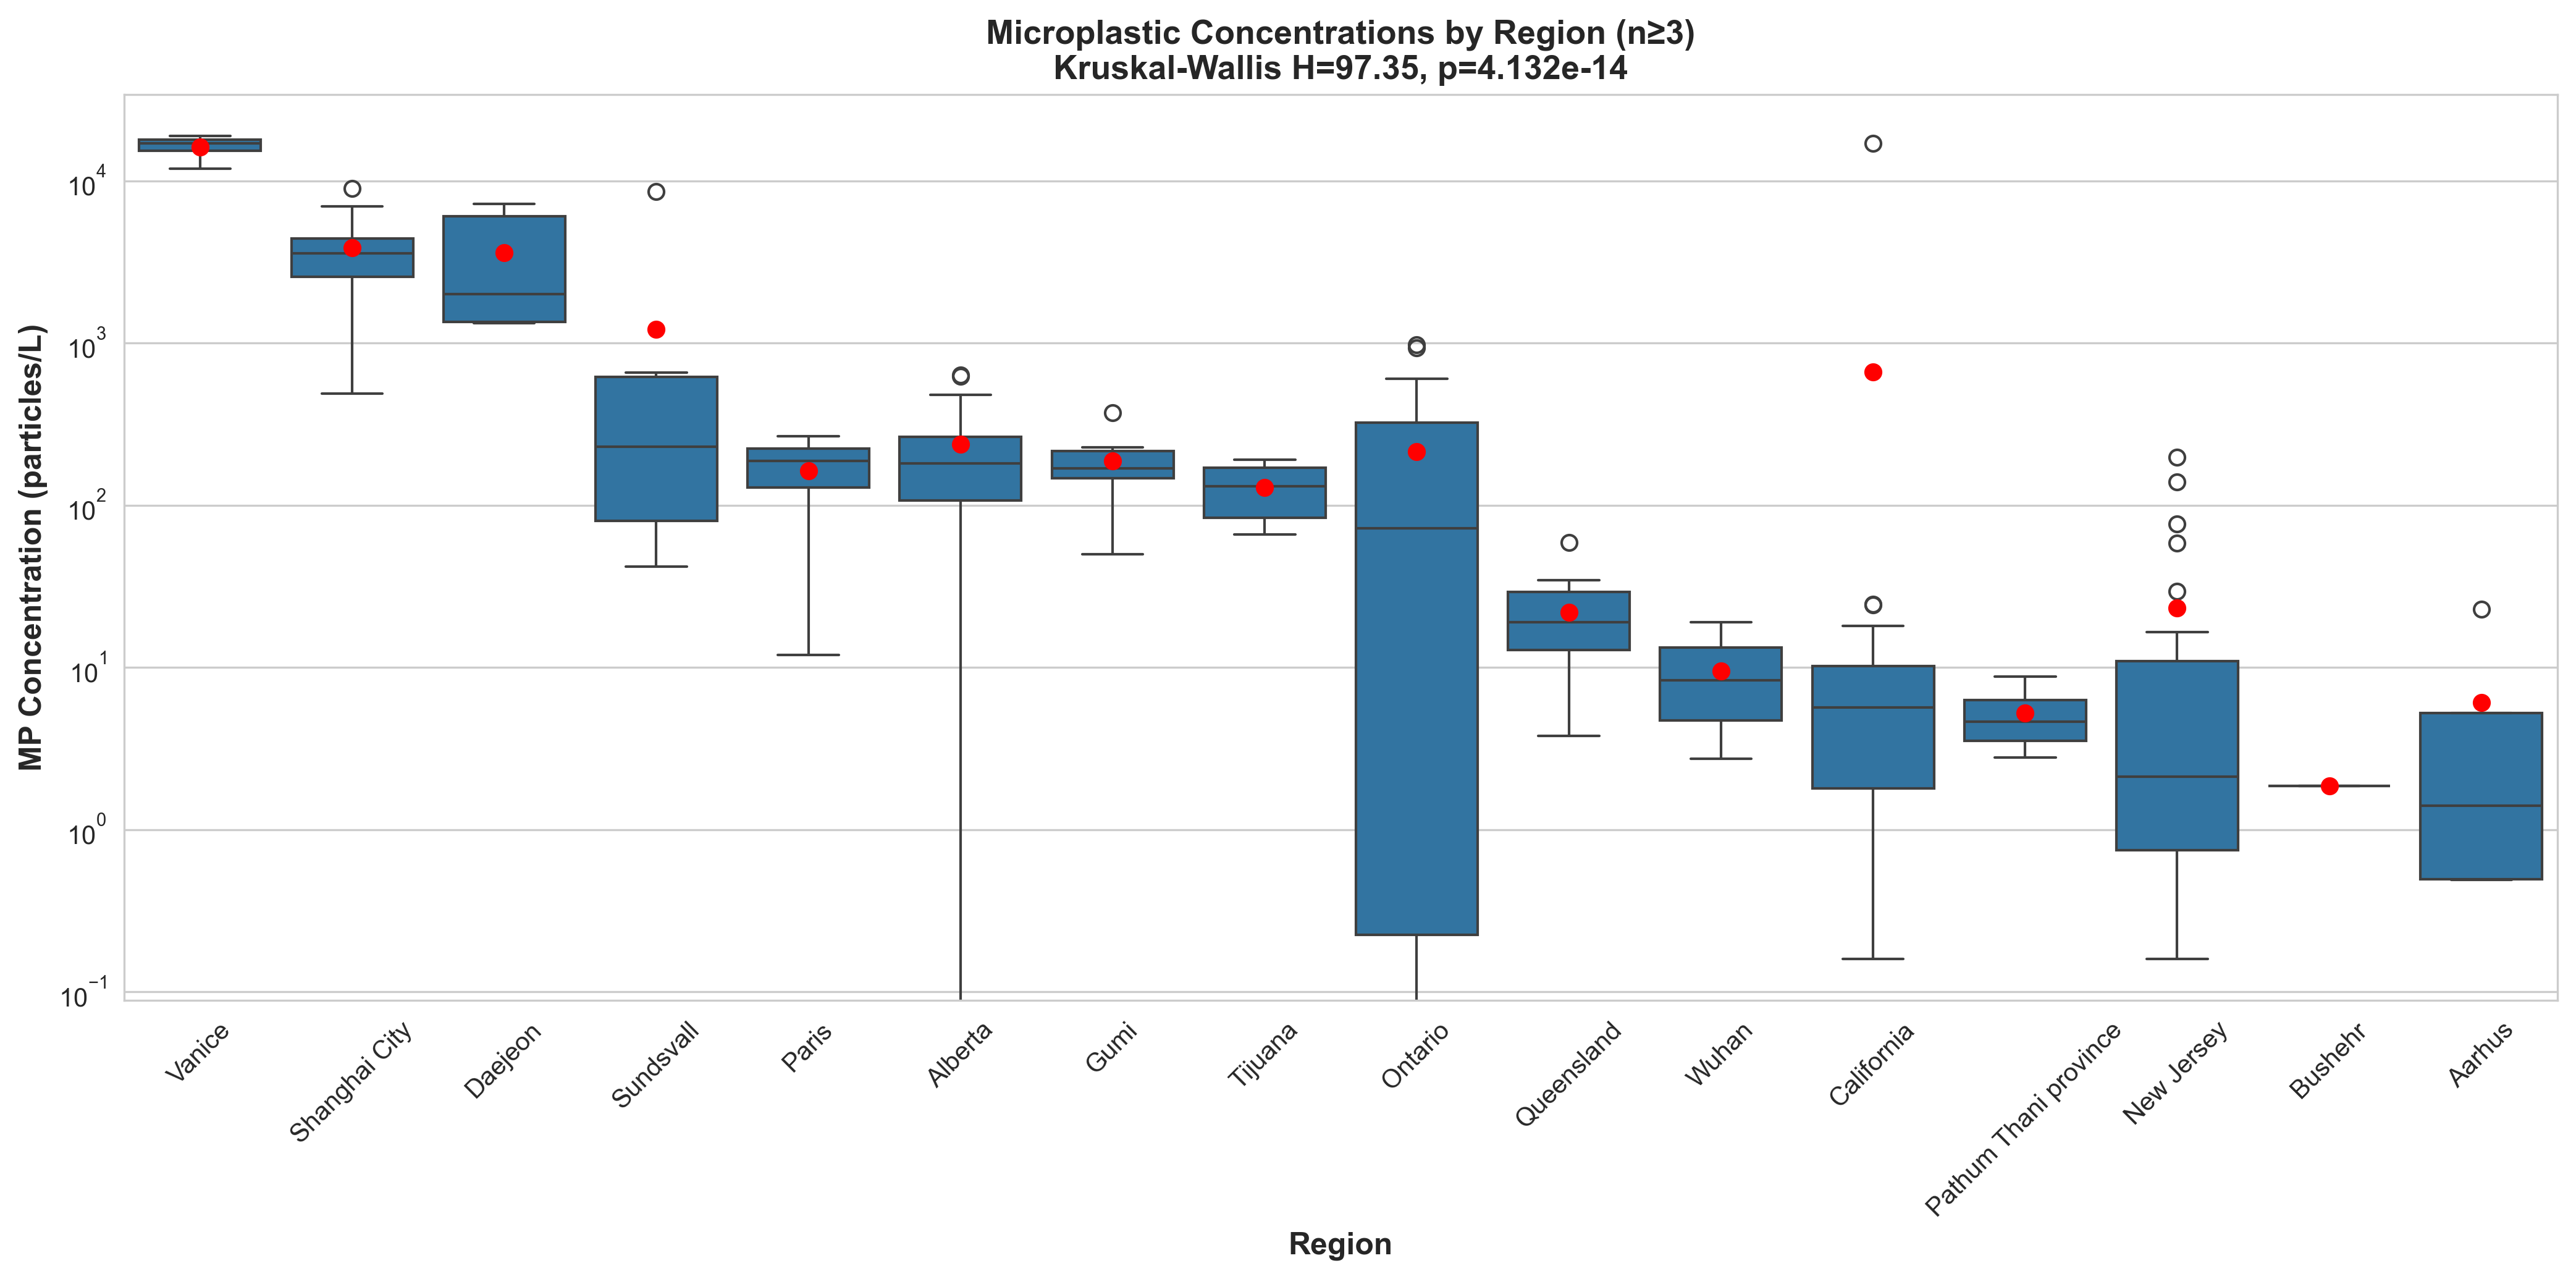


2. LAND USE ANALYSIS

Records per land use:
Land Use Tags
Urban Infrastructure         37
Green infrastructure         24
Residential                  23
Urban catchment              20
Engineered infrastructure    17
Transportation               17
Mixed                        17
Industrial                   15
Commercial                    6
Agricultural                  3
Name: count, dtype: int64

Kruskal-Wallis test: H=46.000, p=6.021e-07

Summary statistics by land use:
                           count  median     mean     Q1       Q3
Land Use Tags                                                    
Engineered infrastructure     17  618.00  2437.67  80.00  4250.00
Transportation                17  197.50  4133.41   6.29  3612.60
Mixed                         17  180.70  1113.66   7.20  1327.00
Residential                   23   84.00   307.73  14.34   211.05
Green infrastructure          24   73.15   213.47   0.12   324.75
Commercial                     6   38.77    45.51  17.16

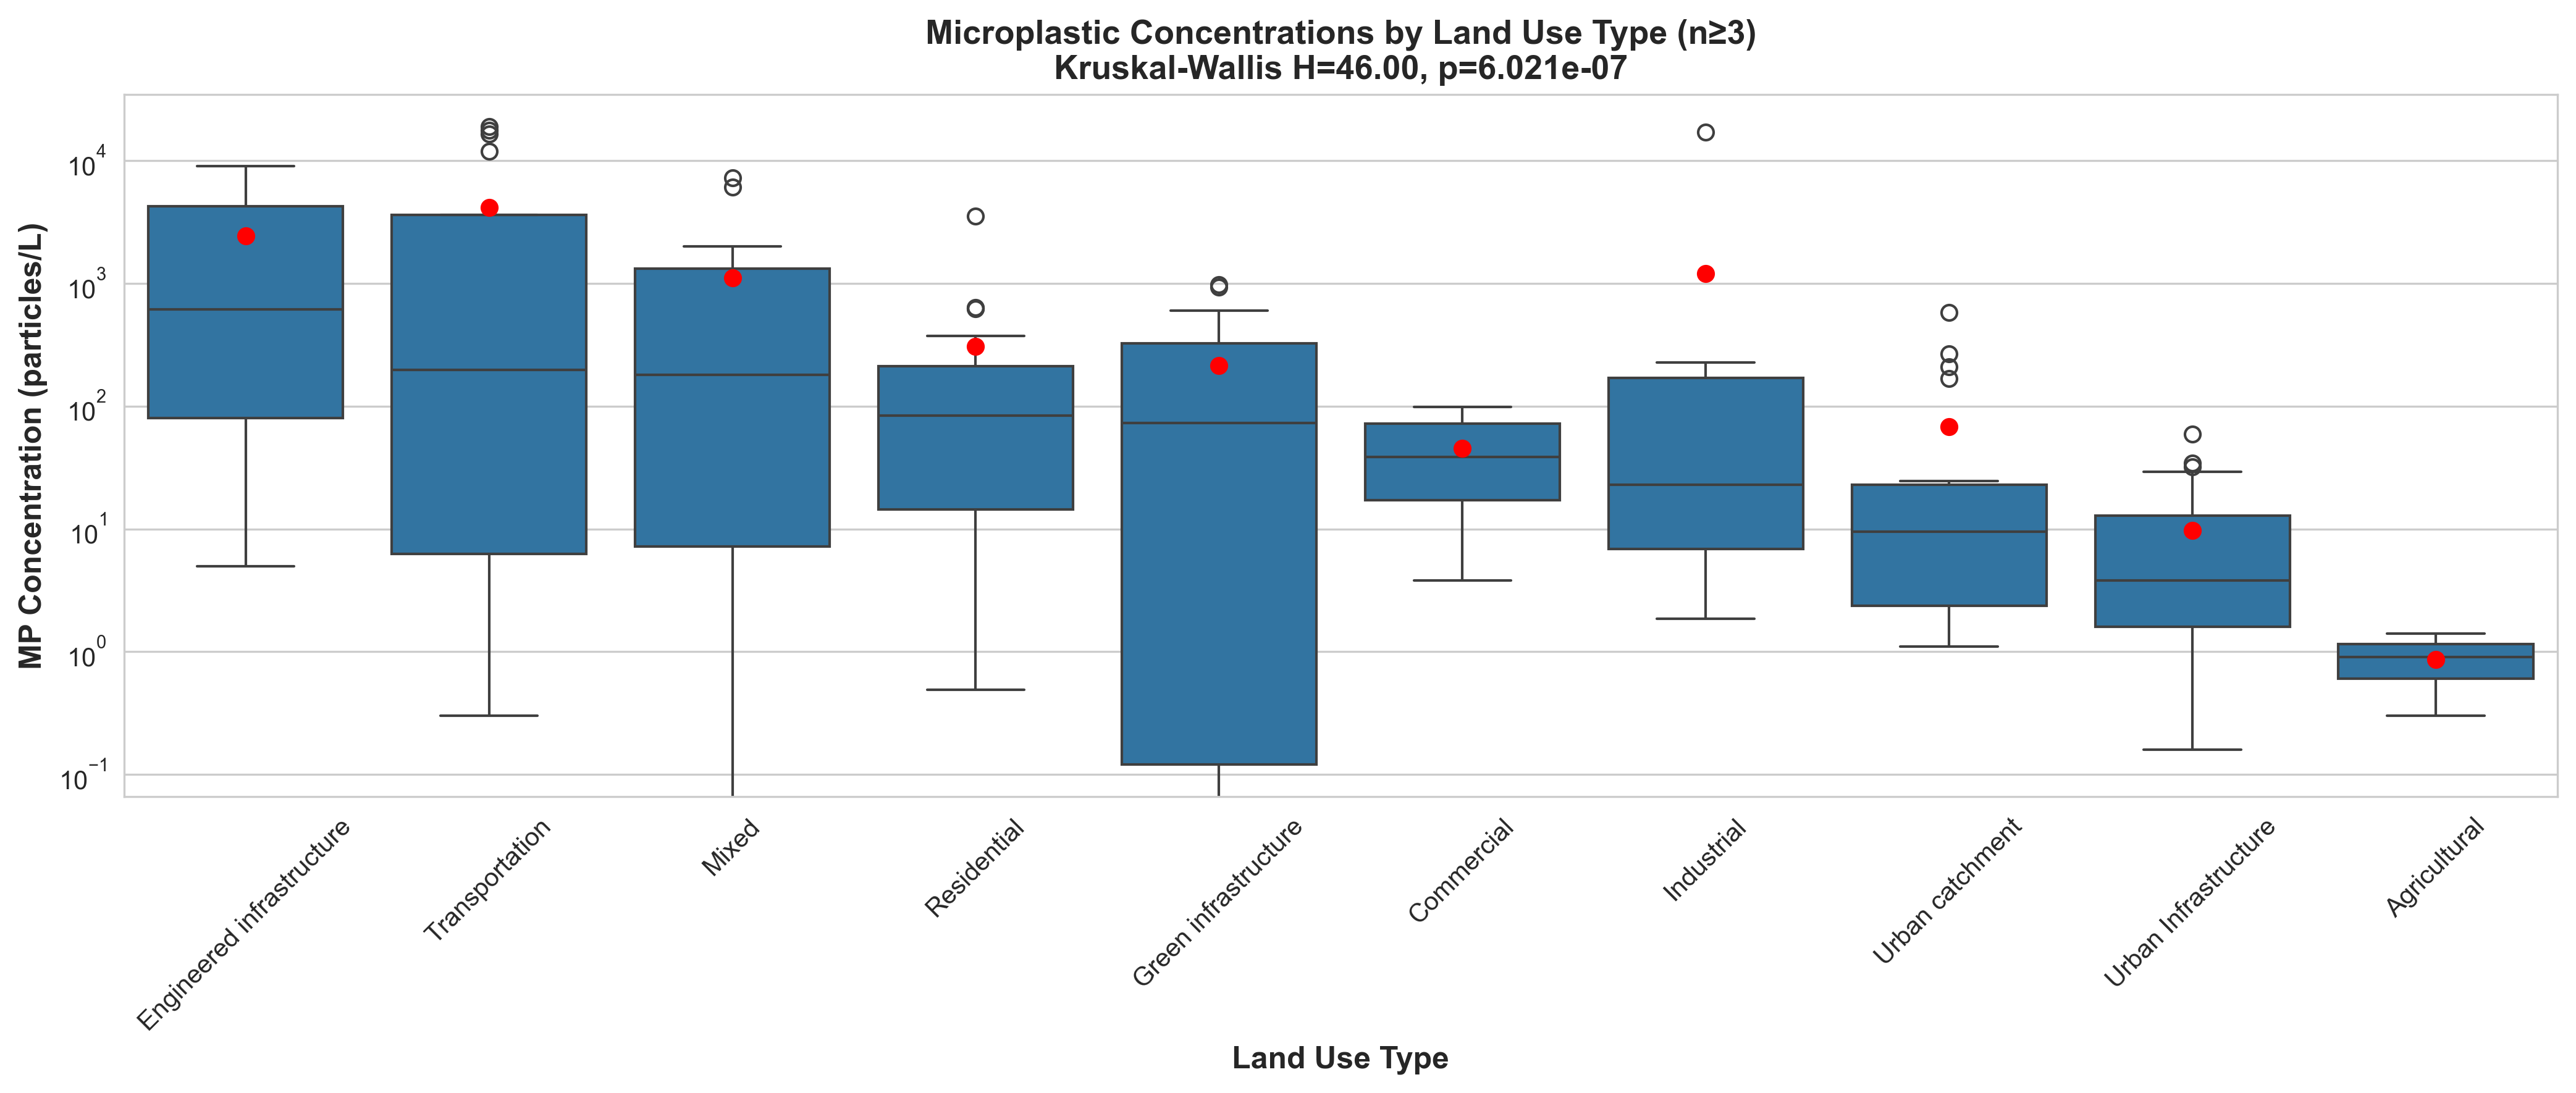


3. METHODOLOGICAL INFLUENCES

--- SAMPLING METHOD ---

Records per sampling method:
Sampling method (standardized)
Composite          78
Grab               44
Automated          35
Engineered Flow    20
Other               2
Name: count, dtype: int64

Kruskal-Wallis test: H=15.067, p=1.760e-03

Summary by sampling method:
                                count  median     mean
Sampling method (standardized)                        
Engineered Flow                    20  193.00   273.25
Automated                          35  116.20   997.95
Grab                               44   12.24  1520.58
Composite                          78    7.48   713.59

--- QUANTIFICATION METHOD ---

Records per quantification method:
Quantification method (standardized)
FTIR            75
Multi-method    49
FTIR + Raman    21
Raman           19
Hot Needle       8
Microscopy       7
Name: count, dtype: int64

Kruskal-Wallis test: H=28.787, p=2.553e-05

Summary by quantification method:
                      

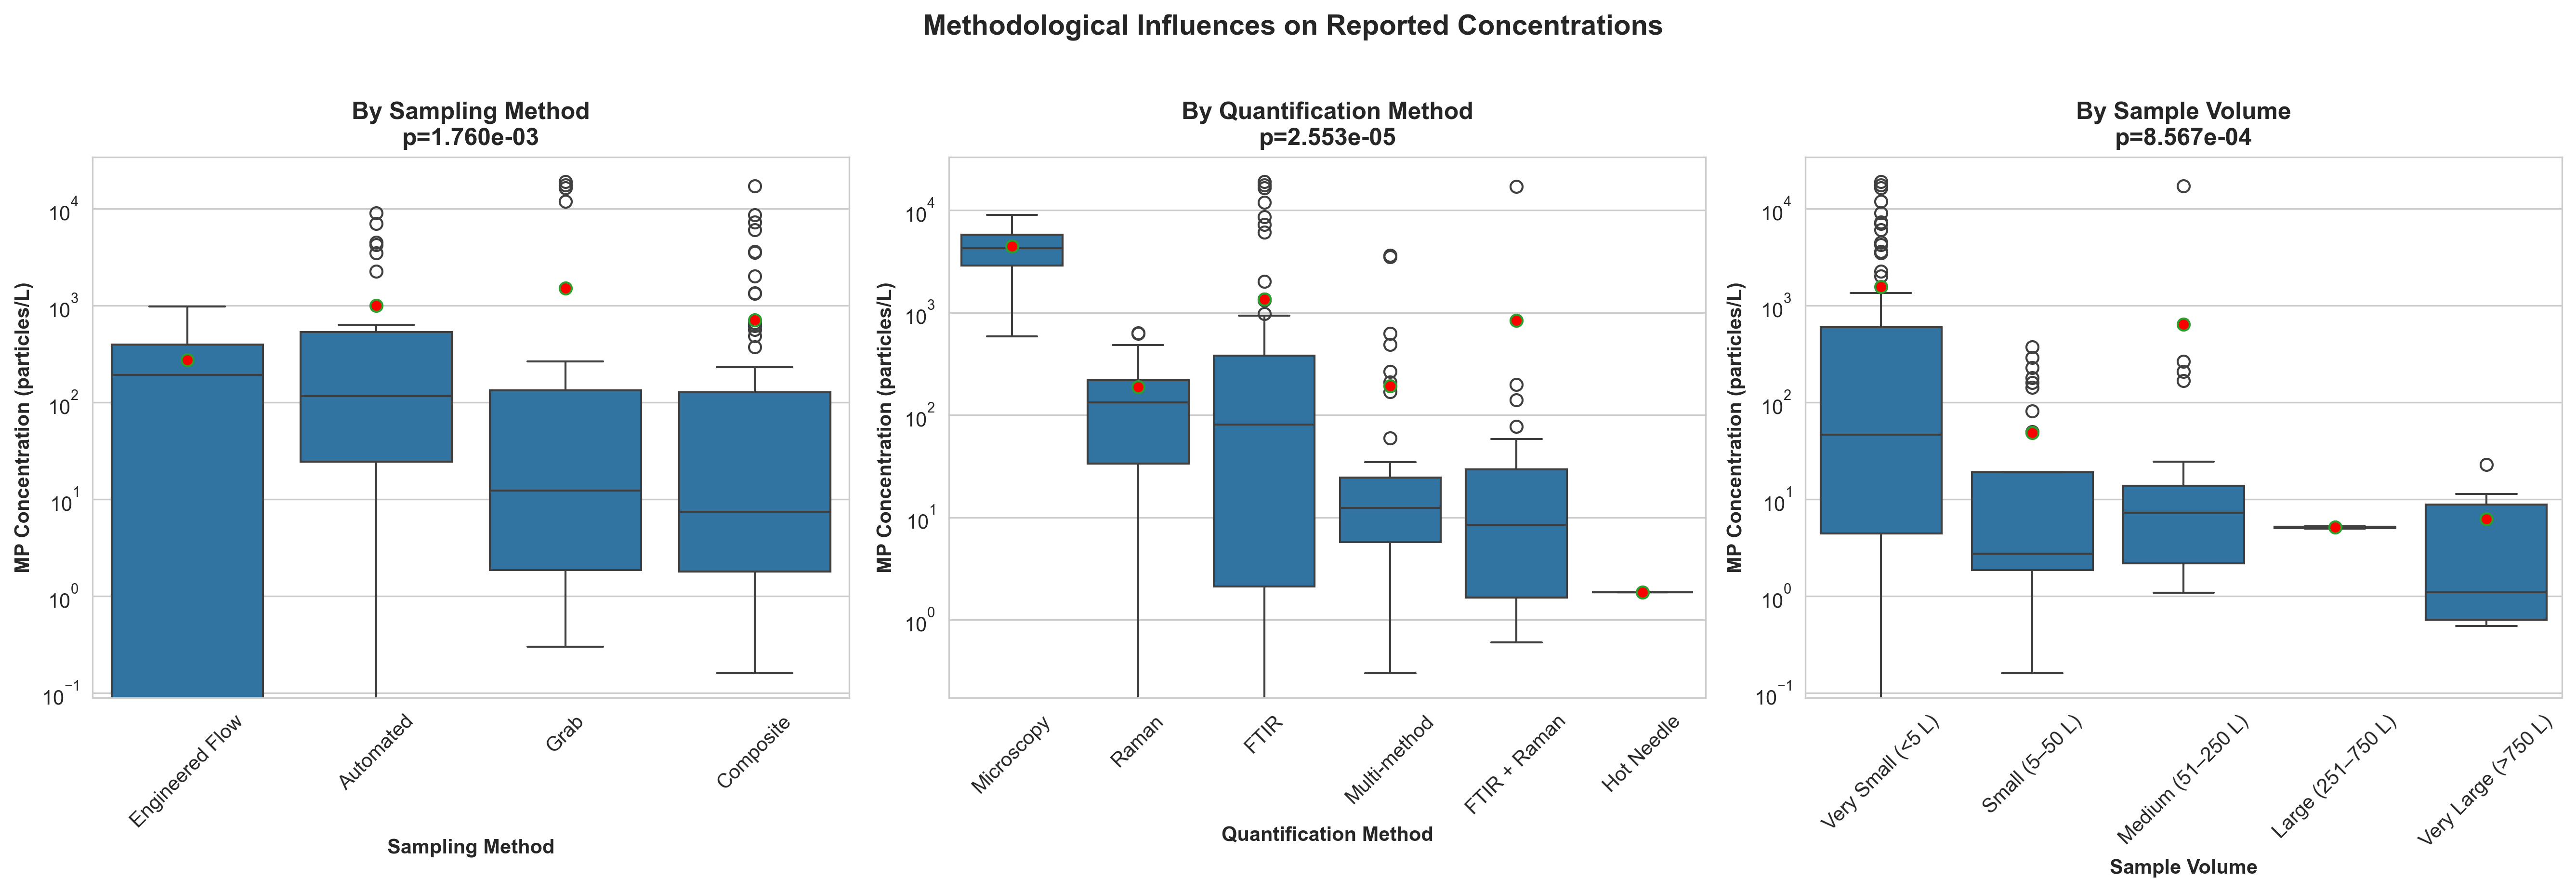


4. ENVIRONMENTAL CORRELATIONS

Antecedent dry days:
  N = 92
  Pearson: r = 0.178, p = 8.919e-02
  Spearman: ρ = 0.373, p = 2.515e-04

Total rainfall:
  N = 103
  Pearson: r = -0.017, p = 8.641e-01
  Spearman: ρ = -0.079, p = 4.249e-01

Temperature:
  N = 6
  Pearson: r = nan, p = nan
  Spearman: ρ = nan, p = nan

Average wind speed:
  N = 10
  Pearson: r = -0.489, p = 1.517e-01
  Spearman: ρ = -0.847, p = 2.002e-03

CORRELATION SUMMARY TABLE
           Variable   N  Pearson_r  Pearson_p  Spearman_rho  Spearman_p
Antecedent dry days  92   0.178220   0.089188      0.372898    0.000251
     Total rainfall 103  -0.017076   0.864067     -0.079465    0.424929
        Temperature   6        NaN        NaN           NaN         NaN
 Average wind speed  10  -0.488831   0.151652     -0.846658    0.002002


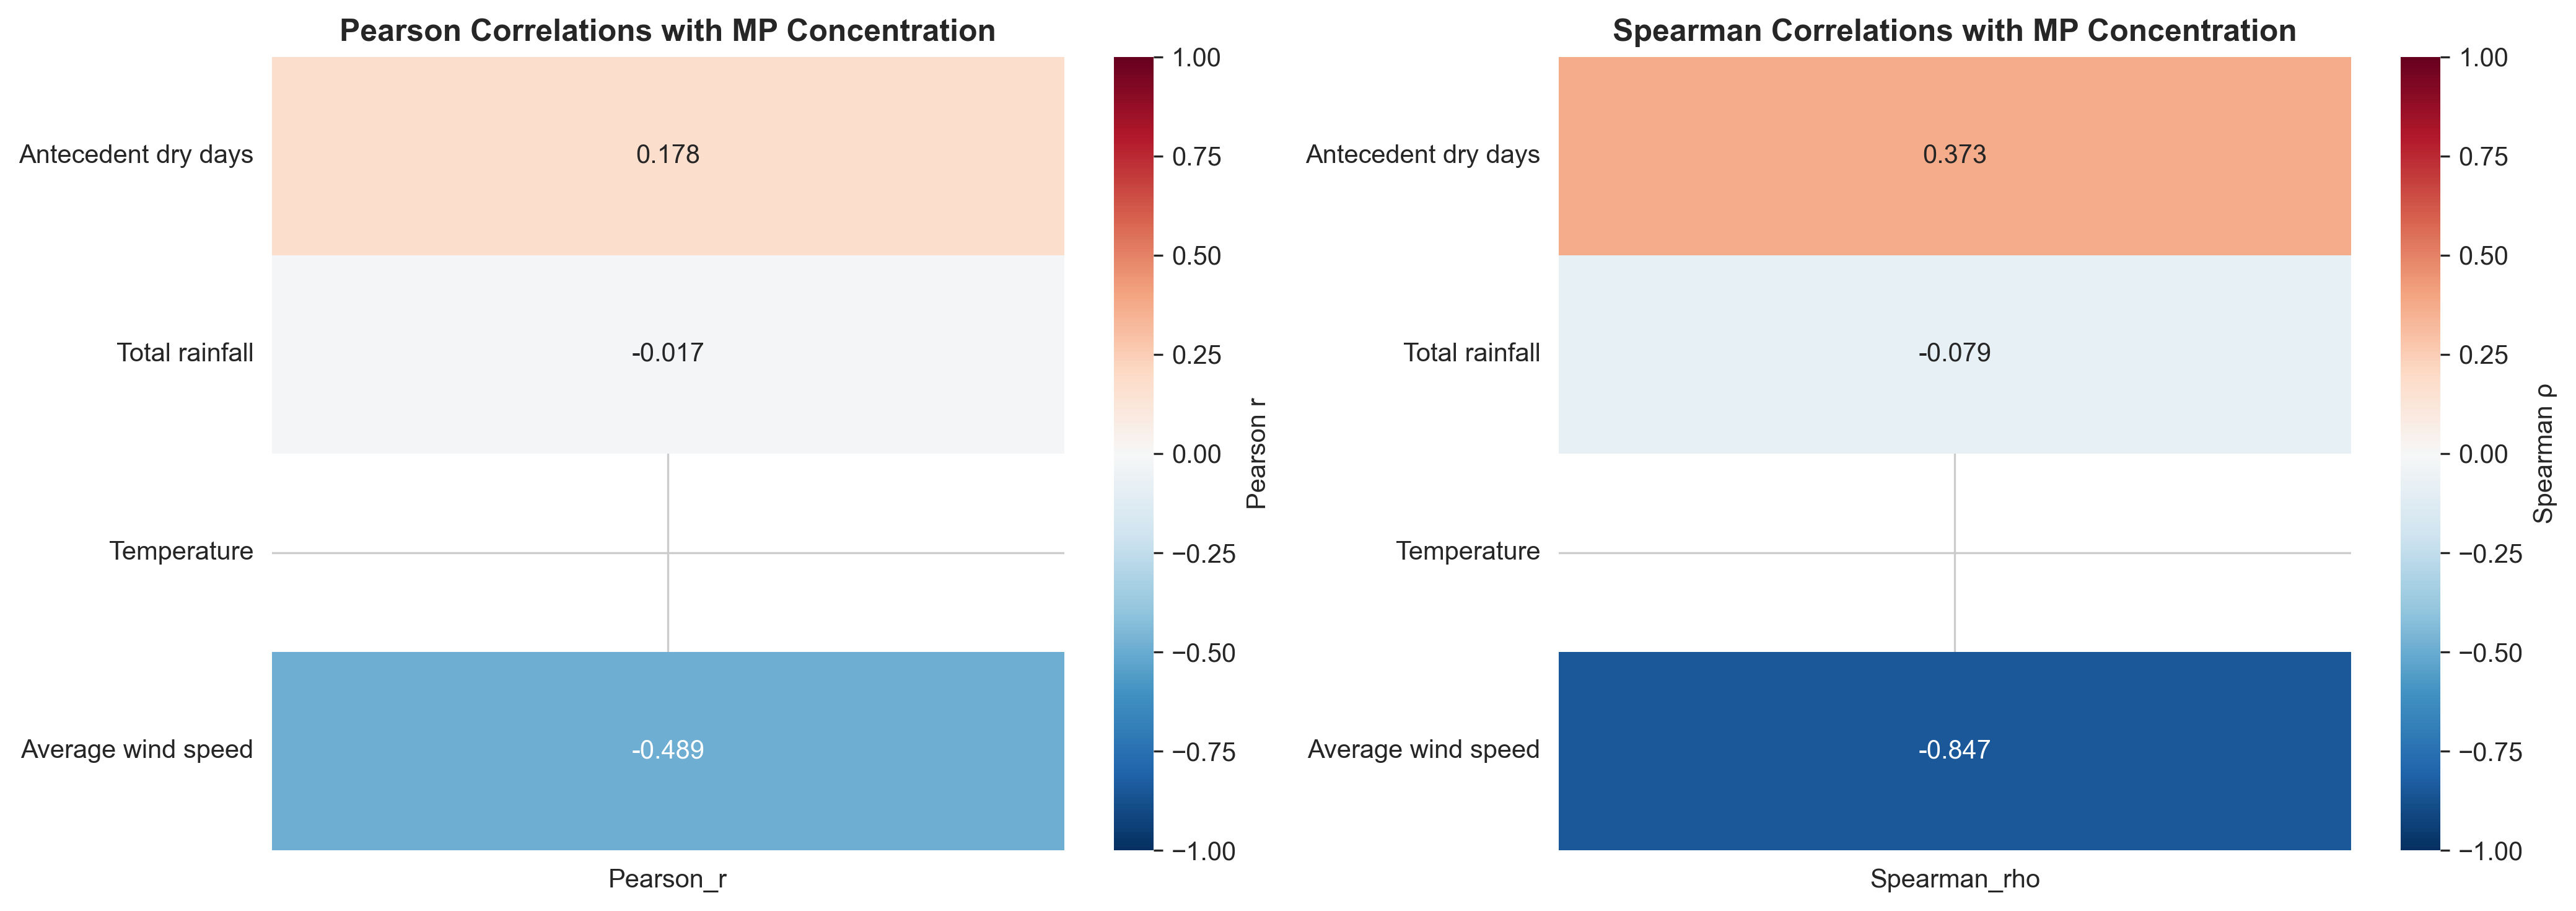

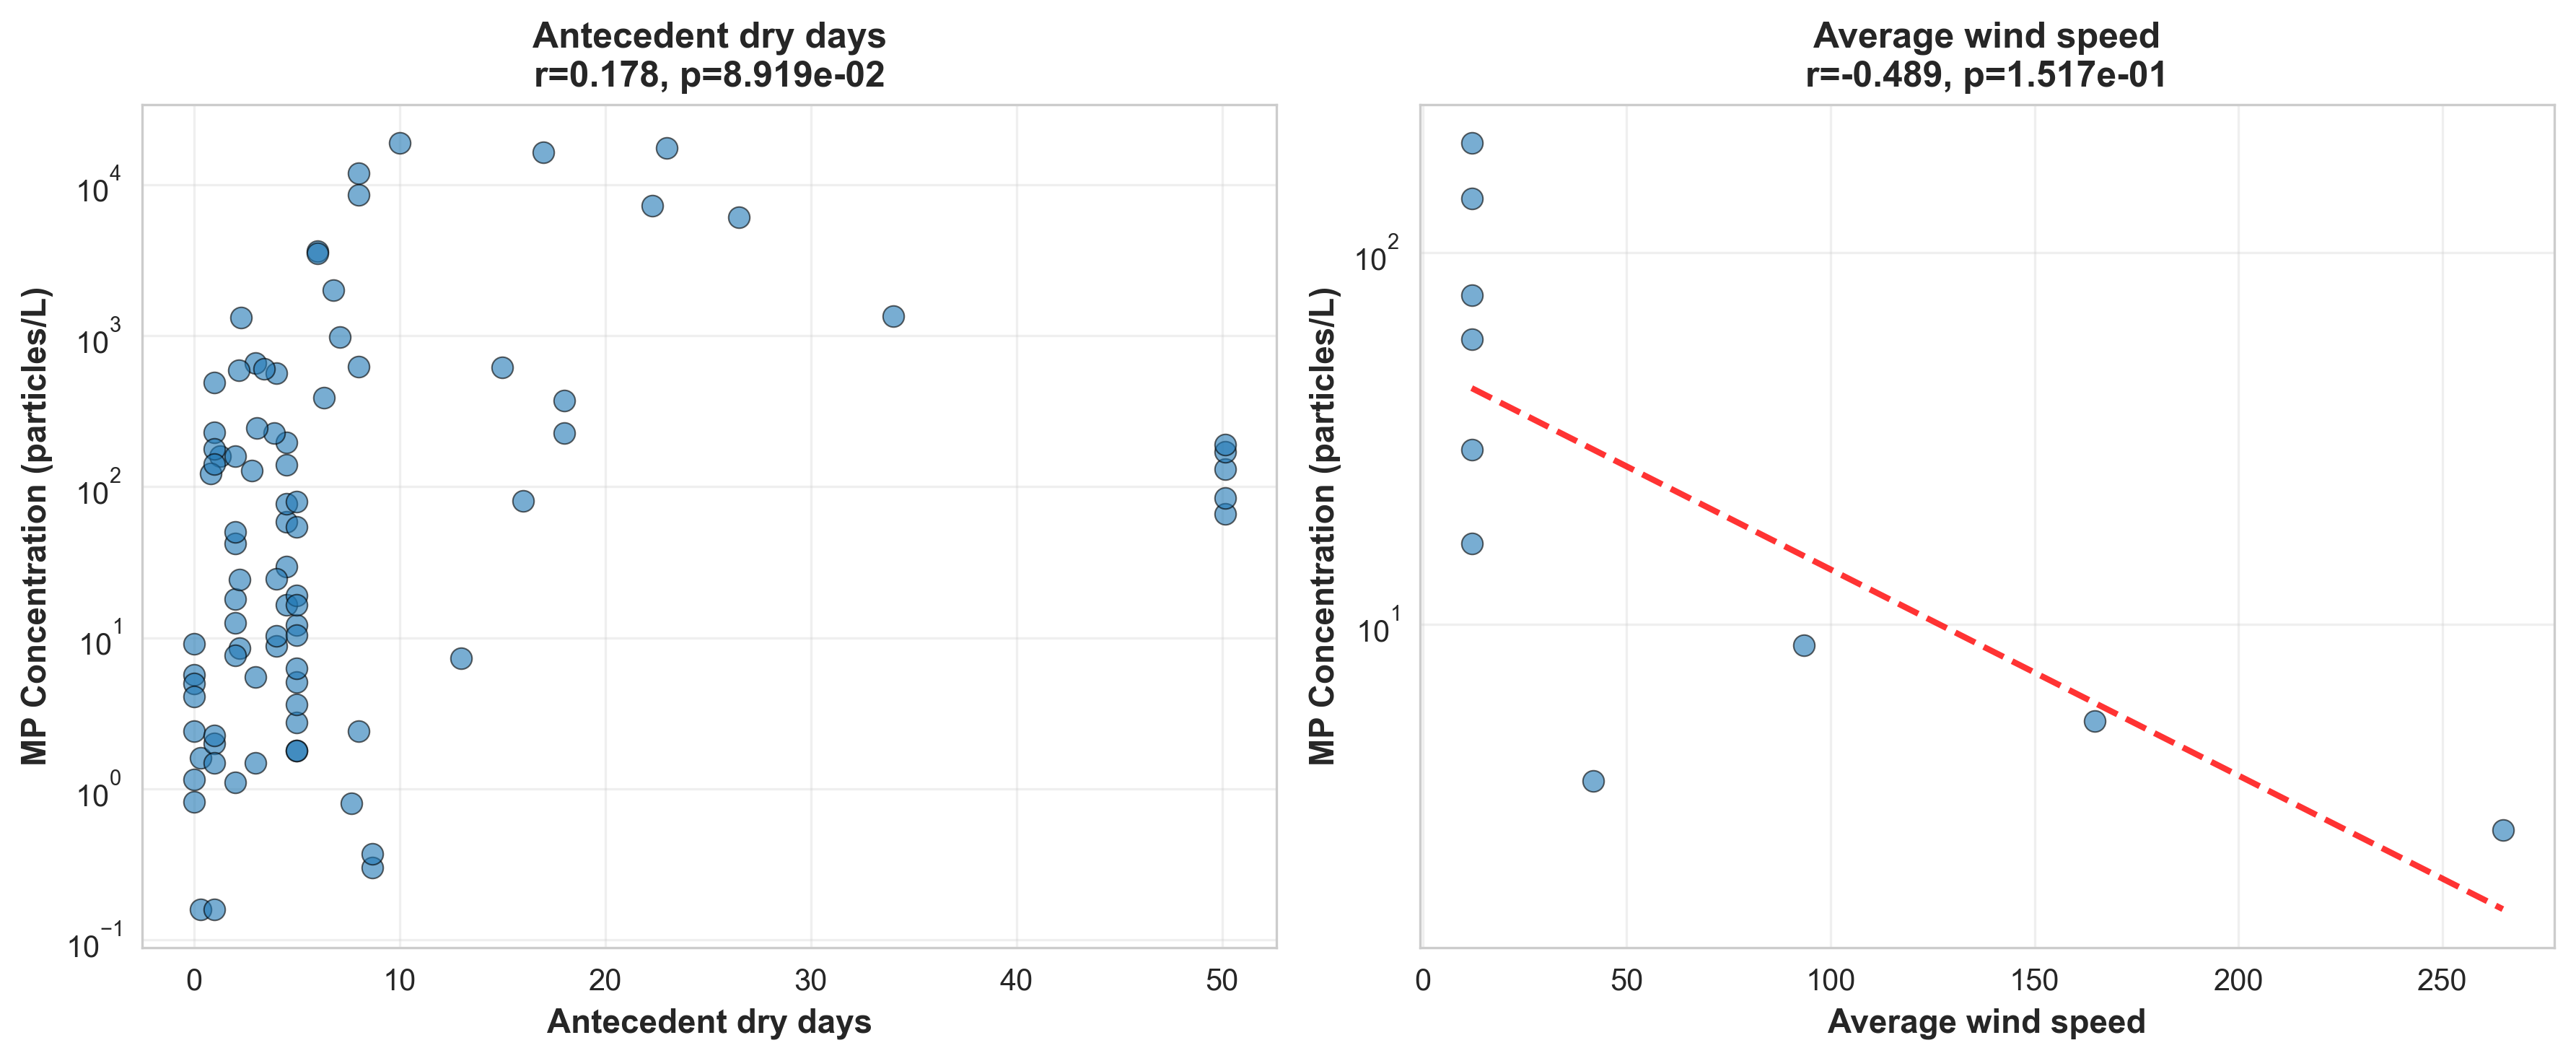


ANALYSIS COMPLETE!

Generated figures:
1. region_comparison_boxplot.png (instead of country)
2. landuse_comparison_boxplot.png
3. methodological_influences.png
4. environmental_correlations.png
5. significant_correlations_scatter.png


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# ============================================================================
# LOAD DATA
# ============================================================================
file_path = r"C:\Users\ai22h\OneDrive - Florida State University\Weekly Meeting_EA\MP Data Analysis_Experimental\My Database_Urban\Paper materials\Urban Runoff MP Database_072025.xlsx"

try:
    df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database", engine='openpyxl')
except:
    df = pd.read_excel(file_path, sheet_name=0)

df.columns = df.columns.str.strip()

print(f"Loaded {len(df)} rows")

# Get standardized concentration
conc_col = "Standardized Concentration (particles/L)"
df_clean = df[pd.to_numeric(df[conc_col], errors="coerce").notna()].copy()
df_clean[conc_col] = df_clean[conc_col].astype(float)

# Clean Region column
df_clean['Region'] = df_clean['Region'].astype(str).str.strip()
df_clean = df_clean[df_clean['Region'] != 'nan']

print(f"\nAfter cleaning:")
print(f"Total records with valid concentration: {len(df_clean)}")
print(f"Records with valid Region: {df_clean['Region'].notna().sum()}")
print(f"\nRegion distribution:")
print(df_clean['Region'].value_counts())

# ============================================================================
# HELPER FUNCTION: Parse numeric values from text
# ============================================================================
def extract_numeric_from_text(text):
    """Extract numeric value from text like '24.13 mm' or '24.13 mm and 7.87 mm'"""
    if pd.isna(text):
        return np.nan
    
    numbers = re.findall(r'\d+\.?\d*', str(text))
    
    if not numbers:
        return np.nan
    
    nums = [float(n) for n in numbers]
    return np.mean(nums)

# ============================================================================
# PARSE ENVIRONMENTAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("PARSING ENVIRONMENTAL VARIABLES")
print("="*80)

df_clean['Total rainfall (numeric)'] = df_clean['Total rainfall'].apply(extract_numeric_from_text)
df_clean['Temperature (numeric)'] = df_clean['Temperature'].apply(extract_numeric_from_text)
df_clean['Wind speed (numeric)'] = df_clean['Average wind speed'].apply(extract_numeric_from_text)
df_clean['ADD (numeric)'] = df_clean['Antecedent dry days'].apply(extract_numeric_from_text)

print(f"Total rainfall - Valid: {df_clean['Total rainfall (numeric)'].notna().sum()}")
print(f"Temperature - Valid: {df_clean['Temperature (numeric)'].notna().sum()}")
print(f"Wind speed - Valid: {df_clean['Wind speed (numeric)'].notna().sum()}")
print(f"Antecedent dry days - Valid: {df_clean['ADD (numeric)'].notna().sum()}")

# ============================================================================
# 1. GEOGRAPHIC ANALYSIS BY REGION
# ============================================================================

print("\n" + "="*80)
print("1. GEOGRAPHIC ANALYSIS BY REGION")
print("="*80)

region_counts = df_clean['Region'].value_counts()
print("\nRecords per region:")
print(region_counts)

# Use regions with n>=3
min_n = 3
regions_to_plot = region_counts[region_counts >= min_n].index
df_region = df_clean[df_clean['Region'].isin(regions_to_plot)].copy()

print(f"\nRegions with n>={min_n}: {len(regions_to_plot)}")

if len(regions_to_plot) >= 2:
    region_groups = [df_region[df_region['Region']==r][conc_col].values 
                      for r in regions_to_plot]
    region_groups = [g for g in region_groups if len(g) > 0]
    
    if len(region_groups) >= 2:
        H_stat, p_val = stats.kruskal(*region_groups)
        print(f"\nKruskal-Wallis test: H={H_stat:.3f}, p={p_val:.3e}")
        
        region_stats = df_region.groupby('Region')[conc_col].agg([
            'count', 'median', 'mean', 
            ('Q1', lambda x: x.quantile(0.25)),
            ('Q3', lambda x: x.quantile(0.75))
        ]).round(2)
        print("\nSummary statistics by region:")
        print(region_stats.sort_values('median', ascending=False))
        
        # PLOT
        fig, ax = plt.subplots(figsize=(14, 7))
        order = region_stats.sort_values('median', ascending=False).index
        sns.boxplot(
            data=df_region, 
            x='Region', 
            y=conc_col,
            order=order,
            showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
            ax=ax
        )
        ax.set_yscale('log')
        ax.set_ylabel('MP Concentration (particles/L)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Region', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.set_title(f'Microplastic Concentrations by Region (n≥{min_n})\nKruskal-Wallis H={H_stat:.2f}, p={p_val:.3e}', 
                    fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig('region_comparison_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# 2. LAND USE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("2. LAND USE ANALYSIS")
print("="*80)

landuse_counts = df_clean['Land Use Tags'].value_counts()
print("\nRecords per land use:")
print(landuse_counts)

min_n_landuse = 3
landuses_to_plot = landuse_counts[landuse_counts >= min_n_landuse].index
df_landuse = df_clean[df_clean['Land Use Tags'].isin(landuses_to_plot)].copy()

if len(landuses_to_plot) >= 2:
    landuse_groups = [df_landuse[df_landuse['Land Use Tags']==lu][conc_col].values 
                      for lu in landuses_to_plot]
    landuse_groups = [g for g in landuse_groups if len(g) > 0]
    
    if len(landuse_groups) >= 2:
        H_stat_lu, p_val_lu = stats.kruskal(*landuse_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_lu:.3f}, p={p_val_lu:.3e}")
        
        landuse_stats = df_landuse.groupby('Land Use Tags')[conc_col].agg([
            'count', 'median', 'mean',
            ('Q1', lambda x: x.quantile(0.25)),
            ('Q3', lambda x: x.quantile(0.75))
        ]).round(2)
        print("\nSummary statistics by land use:")
        print(landuse_stats.sort_values('median', ascending=False))
        
        # PLOT
        fig, ax = plt.subplots(figsize=(14, 6))
        sns.boxplot(
            data=df_landuse,
            x='Land Use Tags',
            y=conc_col,
            order=landuse_stats.sort_values('median', ascending=False).index,
            showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"},
            ax=ax
        )
        ax.set_yscale('log')
        ax.set_ylabel('MP Concentration (particles/L)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Land Use Type', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'Microplastic Concentrations by Land Use Type (n≥{min_n_landuse})\nKruskal-Wallis H={H_stat_lu:.2f}, p={p_val_lu:.3e}',
                    fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig('landuse_comparison_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# 3. METHODOLOGICAL INFLUENCES
# ============================================================================

print("\n" + "="*80)
print("3. METHODOLOGICAL INFLUENCES")
print("="*80)

# 3A. Sampling Method
print("\n--- SAMPLING METHOD ---")
sampling_counts = df_clean['Sampling method (standardized)'].value_counts()
print("\nRecords per sampling method:")
print(sampling_counts)

min_n_method = 5
methods_to_plot = sampling_counts[sampling_counts >= min_n_method].index
df_method = df_clean[df_clean['Sampling method (standardized)'].isin(methods_to_plot)].copy()

method_stats = None
if len(methods_to_plot) >= 2:
    method_groups = [df_method[df_method['Sampling method (standardized)']==m][conc_col].values 
                     for m in methods_to_plot]
    method_groups = [g for g in method_groups if len(g) > 0]
    
    if len(method_groups) >= 2:
        H_stat_method, p_val_method = stats.kruskal(*method_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_method:.3f}, p={p_val_method:.3e}")
        
        method_stats = df_method.groupby('Sampling method (standardized)')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by sampling method:")
        print(method_stats.sort_values('median', ascending=False))

# 3B. Quantification Method
print("\n--- QUANTIFICATION METHOD ---")
quant_counts = df_clean['Quantification method (standardized)'].value_counts()
print("\nRecords per quantification method:")
print(quant_counts)

quant_to_plot = quant_counts[quant_counts >= min_n_method].index
df_quant = df_clean[df_clean['Quantification method (standardized)'].isin(quant_to_plot)].copy()

quant_stats = None
if len(quant_to_plot) >= 2:
    quant_groups = [df_quant[df_quant['Quantification method (standardized)']==q][conc_col].values 
                    for q in quant_to_plot]
    quant_groups = [g for g in quant_groups if len(g) > 0]
    
    if len(quant_groups) >= 2:
        H_stat_quant, p_val_quant = stats.kruskal(*quant_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_quant:.3f}, p={p_val_quant:.3e}")
        
        quant_stats = df_quant.groupby('Quantification method (standardized)')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by quantification method:")
        print(quant_stats.sort_values('median', ascending=False))

# 3C. Sample Volume
print("\n--- SAMPLE VOLUME ---")
volume_counts = df_clean['Sample volume bin'].value_counts()
print("\nRecords per volume bin:")
print(volume_counts)

volume_order = ['Very Small (<5 L)', 'Small (5–50 L)', 'Medium (51–250 L)', 
                'Large (251–750 L)', 'Very Large (>750 L)']
existing_volumes = [v for v in volume_order if v in df_clean['Sample volume bin'].unique()]

df_volume = df_clean[df_clean['Sample volume bin'].isin(existing_volumes)].copy()

volume_stats = None
if len(existing_volumes) >= 2:
    volume_groups = [df_volume[df_volume['Sample volume bin']==v][conc_col].values 
                     for v in existing_volumes]
    volume_groups = [g for g in volume_groups if len(g) > 0]
    
    if len(volume_groups) >= 2:
        H_stat_vol, p_val_vol = stats.kruskal(*volume_groups)
        print(f"\nKruskal-Wallis test: H={H_stat_vol:.3f}, p={p_val_vol:.3e}")
        
        volume_stats = df_volume.groupby('Sample volume bin')[conc_col].agg([
            'count', 'median', 'mean'
        ]).round(2)
        print("\nSummary by volume bin:")
        print(volume_stats.reindex(existing_volumes))

# PLOT: Multi-panel methodological influences
n_panels = sum([
    method_stats is not None,
    quant_stats is not None,
    volume_stats is not None
])

if n_panels > 0:
    fig, axes = plt.subplots(1, n_panels, figsize=(6*n_panels, 6))
    if n_panels == 1:
        axes = [axes]
    
    panel_idx = 0
    
    if method_stats is not None:
        sns.boxplot(data=df_method, x='Sampling method (standardized)', y=conc_col,
                    order=method_stats.sort_values('median', ascending=False).index,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Sampling Method', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Sampling Method\np={p_val_method:.3e}', fontweight='bold')
        panel_idx += 1
    
    if quant_stats is not None:
        sns.boxplot(data=df_quant, x='Quantification method (standardized)', y=conc_col,
                    order=quant_stats.sort_values('median', ascending=False).index,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Quantification Method', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Quantification Method\np={p_val_quant:.3e}', fontweight='bold')
        panel_idx += 1
    
    if volume_stats is not None:
        sns.boxplot(data=df_volume, x='Sample volume bin', y=conc_col,
                    order=existing_volumes,
                    showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "red"},
                    ax=axes[panel_idx])
        axes[panel_idx].set_yscale('log')
        axes[panel_idx].set_xlabel('Sample Volume', fontweight='bold')
        axes[panel_idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold')
        axes[panel_idx].tick_params(axis='x', rotation=45)
        axes[panel_idx].set_title(f'By Sample Volume\np={p_val_vol:.3e}', fontweight='bold')
    
    plt.suptitle('Methodological Influences on Reported Concentrations', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('methodological_influences.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 4. ENVIRONMENTAL CORRELATIONS
# ============================================================================

print("\n" + "="*80)
print("4. ENVIRONMENTAL CORRELATIONS")
print("="*80)

env_vars = {
    'Antecedent dry days': 'ADD (numeric)',
    'Total rainfall': 'Total rainfall (numeric)',
    'Temperature': 'Temperature (numeric)',
    'Average wind speed': 'Wind speed (numeric)'
}

correlation_results = []

for var_name, var_col in env_vars.items():
    if var_col in df_clean.columns:
        valid_data = df_clean[[conc_col, var_col]].dropna()
        
        if len(valid_data) >= 3:
            pearson_r, pearson_p = stats.pearsonr(valid_data[conc_col], valid_data[var_col])
            spearman_r, spearman_p = stats.spearmanr(valid_data[conc_col], valid_data[var_col])
            
            correlation_results.append({
                'Variable': var_name,
                'N': len(valid_data),
                'Pearson_r': pearson_r,
                'Pearson_p': pearson_p,
                'Spearman_rho': spearman_r,
                'Spearman_p': spearman_p
            })
            
            print(f"\n{var_name}:")
            print(f"  N = {len(valid_data)}")
            print(f"  Pearson: r = {pearson_r:.3f}, p = {pearson_p:.3e}")
            print(f"  Spearman: ρ = {spearman_r:.3f}, p = {spearman_p:.3e}")
        else:
            print(f"\n{var_name}: Insufficient data (n={len(valid_data)})")

if correlation_results:
    corr_df = pd.DataFrame(correlation_results)
    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(corr_df.to_string(index=False))
    
    # PLOT: Correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pearson_data = corr_df.set_index('Variable')['Pearson_r'].to_frame()
    sns.heatmap(pearson_data, annot=True, fmt='.3f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'},
                ax=axes[0])
    axes[0].set_title('Pearson Correlations with MP Concentration', fontweight='bold')
    axes[0].set_ylabel('')
    
    spearman_data = corr_df.set_index('Variable')['Spearman_rho'].to_frame()
    sns.heatmap(spearman_data, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Spearman ρ'},
                ax=axes[1])
    axes[1].set_title('Spearman Correlations with MP Concentration', fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('environmental_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # PLOT: Scatter plots for significant correlations
    sig_corrs = corr_df[(corr_df['Pearson_p'] < 0.05) | (corr_df['Spearman_p'] < 0.05)]
    
    if len(sig_corrs) > 0:
        n_plots = len(sig_corrs)
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (_, row) in enumerate(sig_corrs.iterrows()):
            var_name = row['Variable']
            var_col_name = env_vars[var_name]
            
            valid_data = df_clean[[conc_col, var_col_name]].dropna()
            
            axes[idx].scatter(valid_data[var_col_name], valid_data[conc_col], 
                            alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            axes[idx].set_xlabel(var_name, fontweight='bold', fontsize=11)
            axes[idx].set_ylabel('MP Concentration (particles/L)', fontweight='bold', fontsize=11)
            axes[idx].set_yscale('log')
            axes[idx].set_title(f'{var_name}\nr={row["Pearson_r"]:.3f}, p={row["Pearson_p"]:.3e}',
                              fontweight='bold')
            
            # Add regression line
            z = np.polyfit(valid_data[var_col_name], np.log10(valid_data[conc_col]), 1)
            p = np.poly1d(z)
            x_line = np.linspace(valid_data[var_col_name].min(), valid_data[var_col_name].max(), 100)
            y_line = 10**p(x_line)
            axes[idx].plot(x_line, y_line, "r--", alpha=0.8, linewidth=2)
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('significant_correlations_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated figures:")
print("1. region_comparison_boxplot.png (instead of country)")
print("2. landuse_comparison_boxplot.png")
print("3. methodological_influences.png")
print("4. environmental_correlations.png")
print("5. significant_correlations_scatter.png")

Total records: 179

Region distribution:
Region
California               26
New Jersey               24
Ontario                  24
Alberta                  15
Queensland               13
Shanghai City            10
Sundsvall                 9
Wuhan                     8
Bushehr                   8
Gumi                      6
Daejeon                   5
Tijuana                   5
Aarhus                    5
Paris                     4
Pathum Thani province     4
Vanice                    4
Victoria Harbor           2
Tokyo                     2
Cheonan City              2
Gothenburg                1
Silkeborg                 1
Viborg                    1
Name: count, dtype: int64

MORPHOLOGY ANALYSIS BY REGION

Total shape records after explosion: 202
Unique shapes: 14

Overall shape distribution:
shape_list
Fiber                          65
Fragment                       56
Not Reported                   35
Tire Wear Particles\n(Twps)    13
Film                            8
Granule  

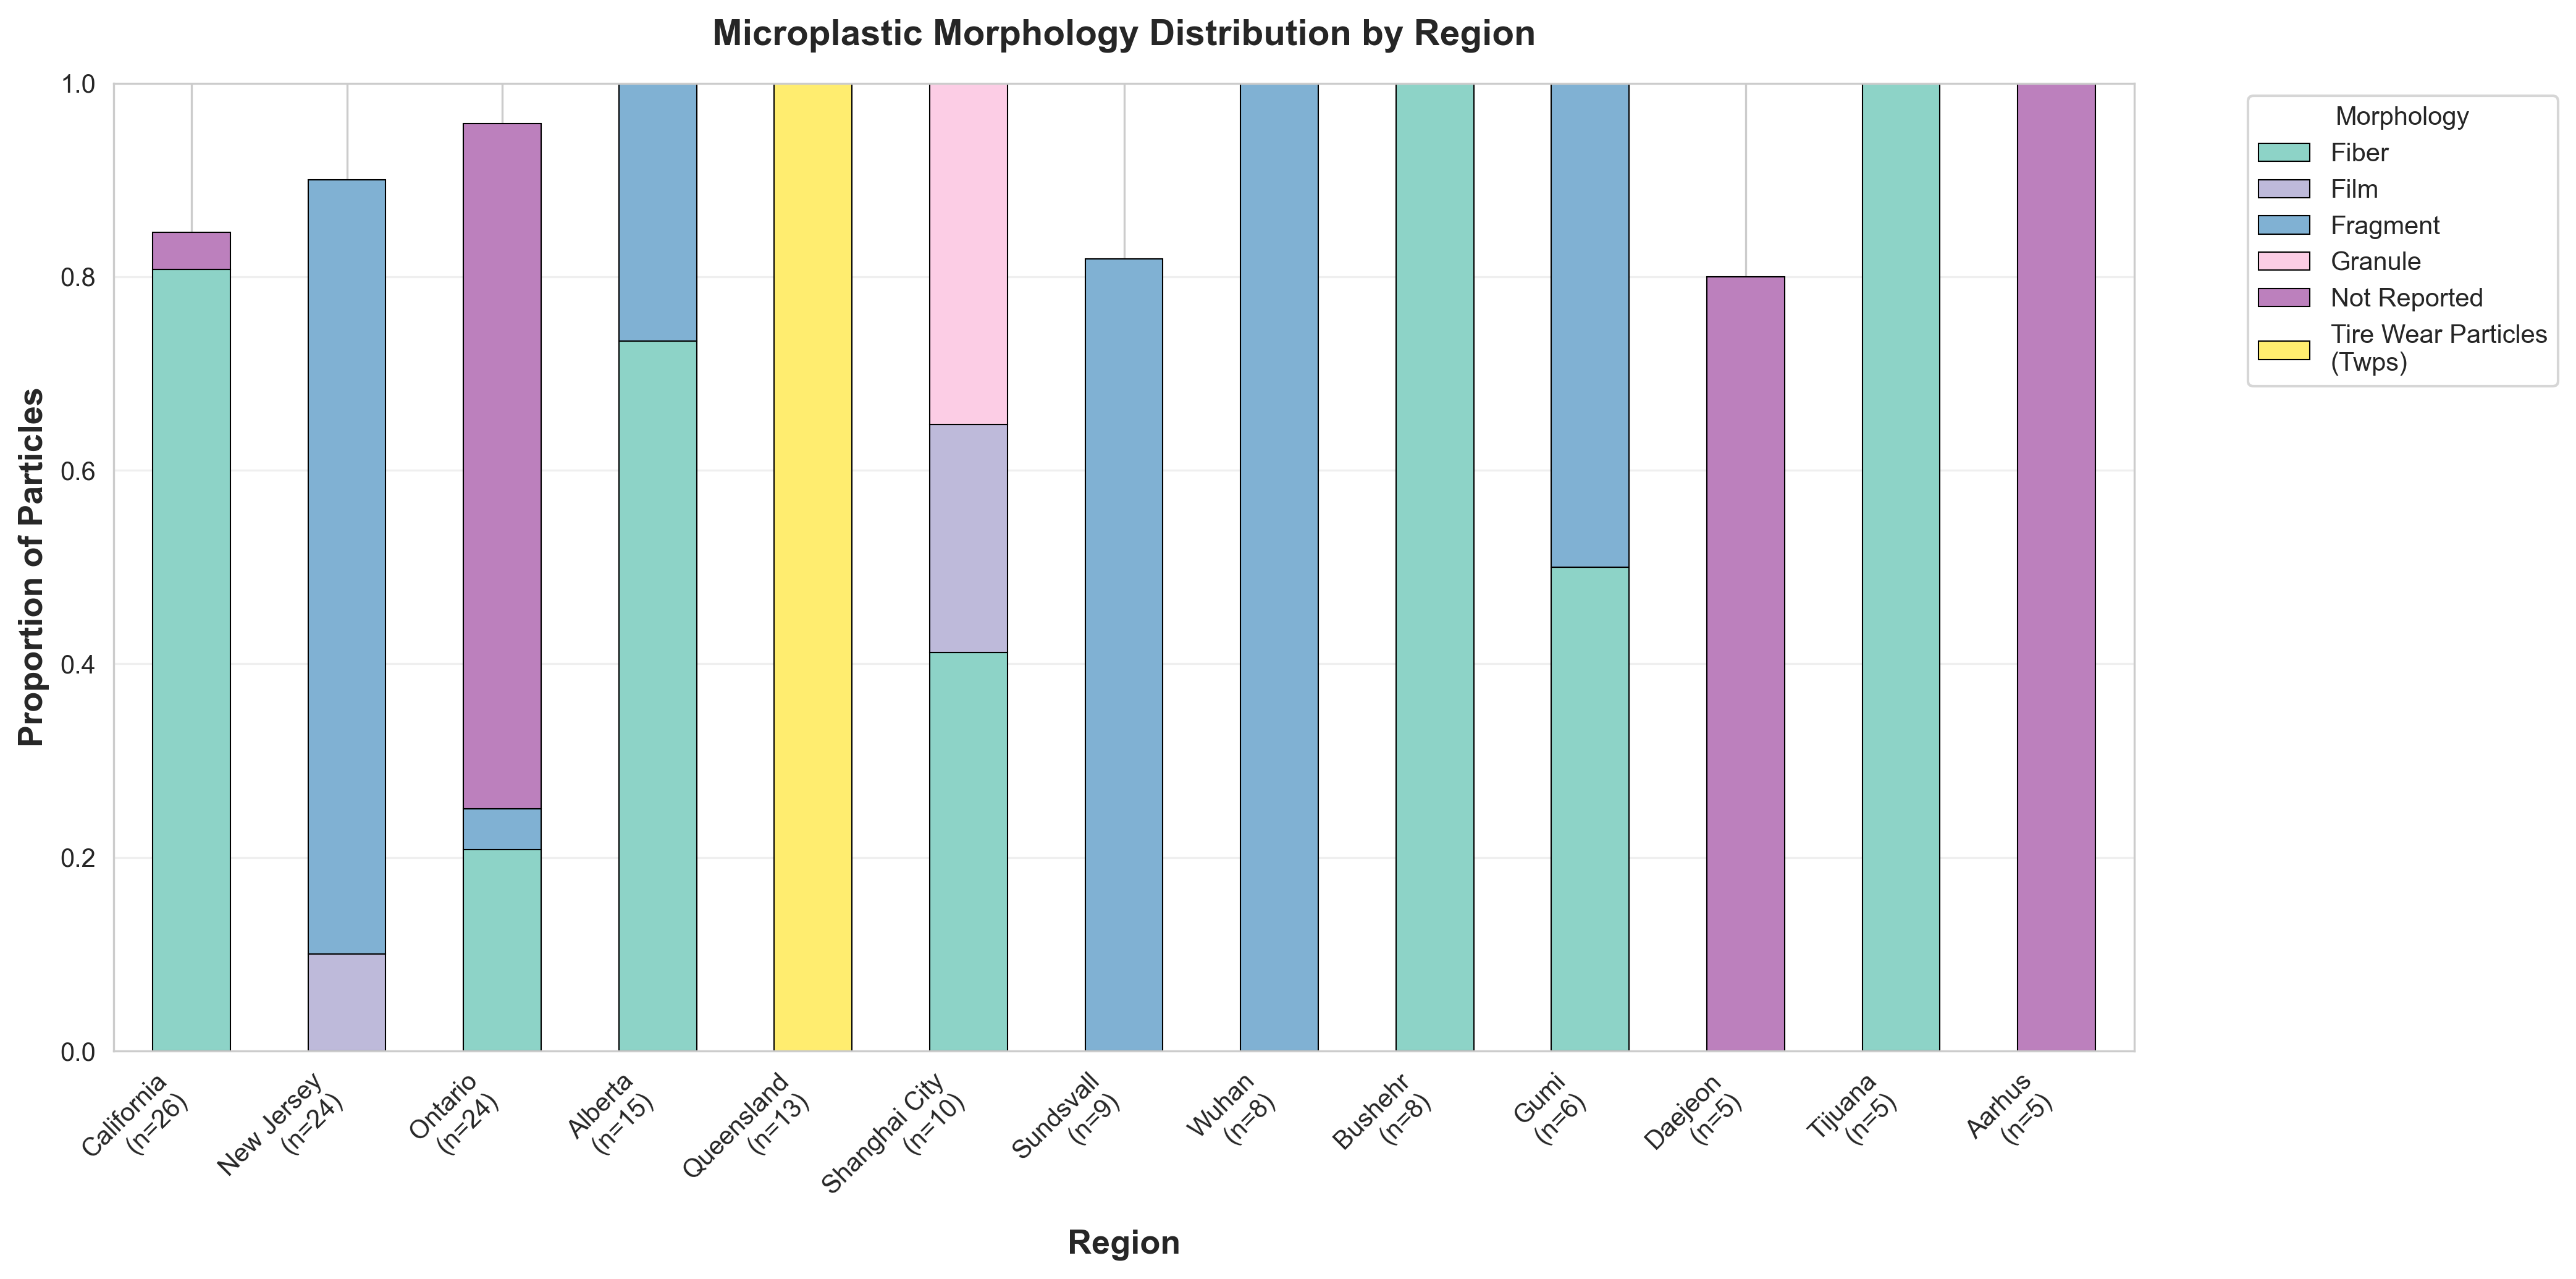


Morphology plot saved: morphology_by_region.png

POLYMER COMPOSITION ANALYSIS BY REGION

Total polymer records after explosion: 261
Unique polymers: 47

Overall polymer distribution:
polymer_list
POLYPROPYLENE (PP)                                 57
POLYETHYLENE (PE)                                  56
NOT REPORTED                                       25
DISCUSSED                                          15
STYRENE-BUTADIENE RUBBER (SBR)                     13
ETHYLENE PROPYLENE DIENE MONOMER\n(EPDM)            9
POLYETHYLENE TEREPHTHALATE (PET)                    9
POLYVINYL CHLORIDE (PVC)                            6
POLYESTER                                           5
RUBBER (RU)                                         4
BITUMEN (BI)                                        4
PE                                                  4
POLYETHYLENCE TEREPTHALATE\n(PET)                   3
CELLULOSE                                           3
ANTHROPOGENIC (DYE-BASED)                      

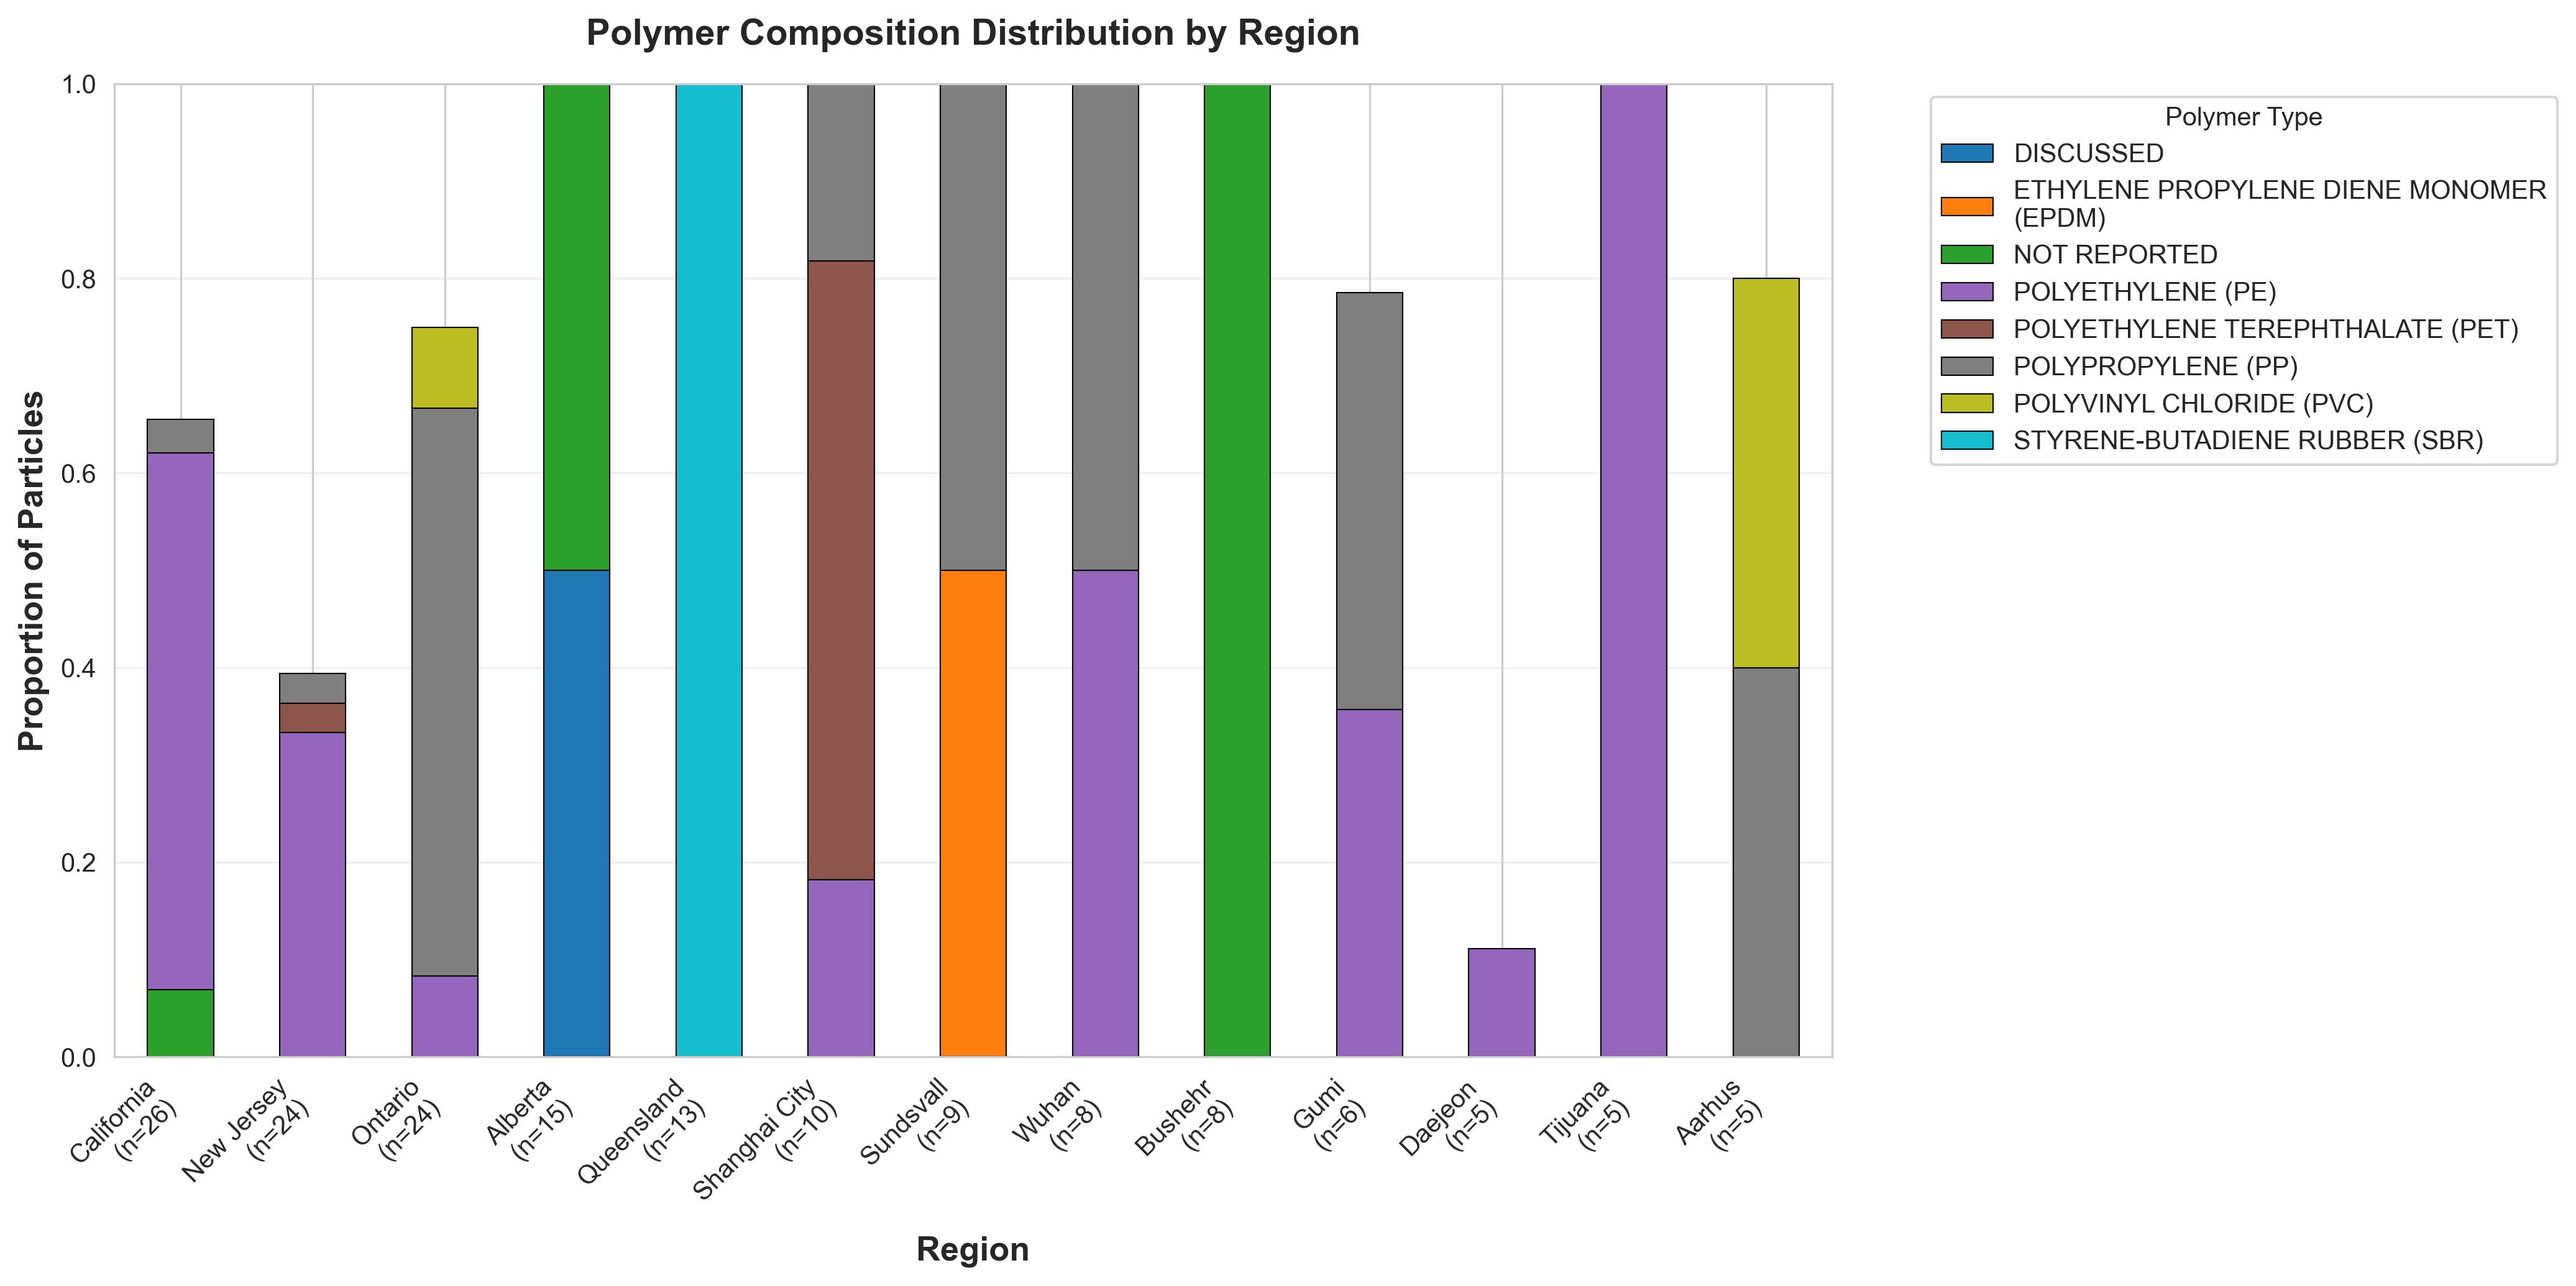


Polymer plot saved: polymer_by_region.png

STATISTICAL TESTS

Morphology distribution by region:
  Chi-square test: χ² = 611.45, df = 132, p = 9.098e-63
  → Morphology distribution DIFFERS significantly across regions

Polymer composition by region:
  Chi-square test: χ² = 1255.91, df = 408, p = 4.155e-87
  → Polymer composition DIFFERS significantly across regions

ANALYSIS COMPLETE!

Generated files:
1. morphology_by_region.png
2. polymer_by_region.png


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# ============================================================================
# LOAD DATA
# ============================================================================
file_path = r"C:\Users\ai22h\OneDrive - Florida State University\Weekly Meeting_EA\MP Data Analysis_Experimental\My Database_Urban\Paper materials\Urban Runoff MP Database_072025.xlsx"

try:
    df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database", engine='openpyxl')
except:
    df = pd.read_excel(file_path, sheet_name=0)

df.columns = df.columns.str.strip()

# Get standardized concentration
conc_col = "Standardized Concentration (particles/L)"
df_clean = df[pd.to_numeric(df[conc_col], errors="coerce").notna()].copy()
df_clean[conc_col] = df_clean[conc_col].astype(float)

# Use Region column directly (already manually cleaned)
df_clean['Region'] = df_clean['Region'].astype(str).str.strip()
df_clean = df_clean[df_clean['Region'] != 'nan']

print(f"Total records: {len(df_clean)}")
print(f"\nRegion distribution:")
region_counts = df_clean['Region'].value_counts()
print(region_counts)

# ============================================================================
# MORPHOLOGY BY REGION
# ============================================================================
print("\n" + "="*80)
print("MORPHOLOGY ANALYSIS BY REGION")
print("="*80)

def split_shapes(x):
    """Split multiple shapes and standardize names"""
    if pd.isna(x):
        return []
    
    # Split on common separators
    parts = re.split(r'[;,/&]\s*|\s+and\s+', str(x).lower())
    
    # Mapping to standardize shape names
    shape_map = {
        'fiber': 'Fiber',
        'fibers': 'Fiber',
        'fibres': 'Fiber',
        'fragment': 'Fragment',
        'fragments': 'Fragment',
        'film': 'Film',
        'films': 'Film',
        'sphere': 'Sphere',
        'spheres': 'Sphere',
        'bead': 'Sphere',
        'beads': 'Sphere',
        'tire': 'Tire Wear',
        'twp': 'Tire Wear',
        'tire wear': 'Tire Wear',
        'foam': 'Foam',
        'pellet': 'Pellet',
        'pellets': 'Pellet'
    }
    
    cleaned = []
    for part in parts:
        part = part.strip()
        if part in shape_map:
            cleaned.append(shape_map[part])
        elif part and len(part) > 2:  # Keep other shapes if meaningful
            cleaned.append(part.title())
    
    return cleaned if cleaned else []

# Apply shape splitting
if 'Dominant shape' in df_clean.columns:
    df_clean['shape_list'] = df_clean['Dominant shape'].apply(split_shapes)
    
    # Explode for counting
    df_shapes = df_clean.explode('shape_list')
    df_shapes = df_shapes[df_shapes['shape_list'].notna() & (df_shapes['shape_list'] != '')]
    
    print(f"\nTotal shape records after explosion: {len(df_shapes)}")
    print(f"Unique shapes: {df_shapes['shape_list'].nunique()}")
    print(f"\nOverall shape distribution:")
    print(df_shapes['shape_list'].value_counts())
    
    # Count by region (only regions with n>=5 for meaningful comparison)
    min_n_region = 5
    regions_to_analyze = region_counts[region_counts >= min_n_region].index
    
    df_shapes_filtered = df_shapes[df_shapes['Region'].isin(regions_to_analyze)].copy()
    
    # Calculate proportions by region
    shape_by_region = df_shapes_filtered.groupby(['Region', 'shape_list']).size().reset_index(name='count')
    region_totals_shapes = shape_by_region.groupby('Region')['count'].sum().reset_index(name='total')
    shape_by_region = shape_by_region.merge(region_totals_shapes, on='Region')
    shape_by_region['proportion'] = shape_by_region['count'] / shape_by_region['total']
    
    print(f"\n" + "="*80)
    print(f"MORPHOLOGY PROPORTIONS BY REGION (regions with n>={min_n_region})")
    print("="*80)
    
    for region in regions_to_analyze:
        region_data = shape_by_region[shape_by_region['Region'] == region].sort_values('proportion', ascending=False)
        print(f"\n{region} (n={region_counts[region]}):")
        for _, row in region_data.iterrows():
            print(f"  {row['shape_list']}: {row['proportion']*100:.1f}% (n={row['count']:.0f})")
    
    # PLOT 1: Stacked bar chart - Morphology by Region
    # Get top 6 most common shapes overall
    top_shapes = df_shapes['shape_list'].value_counts().head(6).index.tolist()
    
    # Create pivot table for top shapes
    shape_pivot = shape_by_region[shape_by_region['shape_list'].isin(top_shapes)].pivot(
        index='Region', 
        columns='shape_list', 
        values='proportion'
    ).fillna(0)
    
    # Sort regions by total sample size (or alphabetically)
    shape_pivot = shape_pivot.loc[regions_to_analyze]
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    shape_pivot.plot(
        kind='bar', 
        stacked=True, 
        ax=ax,
        colormap='Set3',
        edgecolor='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Region', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proportion of Particles', fontsize=13, fontweight='bold')
    ax.set_title('Microplastic Morphology Distribution by Region', fontsize=14, fontweight='bold', pad=15)
    ax.legend(title='Morphology', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes to x-axis
    labels = [f'{region}\n(n={region_counts[region]})' for region in shape_pivot.index]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('morphology_by_region.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMorphology plot saved: morphology_by_region.png")

# ============================================================================
# POLYMER BY REGION
# ============================================================================
print("\n" + "="*80)
print("POLYMER COMPOSITION ANALYSIS BY REGION")
print("="*80)

def split_polymers(x):
    """Split multiple polymers and standardize names"""
    if pd.isna(x):
        return []
    
    # Split on common separators
    parts = re.split(r'[;,/&]\s*|\s+and\s+', str(x))
    
    # Mapping to standardize polymer names
    polymer_map = {
        'PE': 'PE',
        'pe': 'PE',
        'polyethylene': 'PE',
        'Polyethylene': 'PE',
        'PP': 'PP',
        'pp': 'PP',
        'polypropylene': 'PP',
        'Polypropylene': 'PP',
        'PET': 'PET',
        'pet': 'PET',
        'polyethylene terephthalate': 'PET',
        'Polyethylene terephthalate': 'PET',
        'PS': 'PS',
        'ps': 'PS',
        'polystyrene': 'PS',
        'Polystyrene': 'PS',
        'PVC': 'PVC',
        'pvc': 'PVC',
        'polyvinyl chloride': 'PVC',
        'SBR': 'SBR',
        'sbr': 'SBR',
        'styrene-butadiene rubber': 'SBR',
        'styrene butadiene rubber': 'SBR',
        'EPDM': 'EPDM',
        'epdm': 'EPDM',
        'PA': 'PA',
        'pa': 'PA',
        'polyamide': 'PA',
        'nylon': 'PA',
        'Nylon': 'PA',
        'PU': 'PU',
        'pu': 'PU',
        'polyurethane': 'PU',
        'Polyurethane': 'PU'
    }
    
    cleaned = []
    for part in parts:
        part = part.strip()
        if part in polymer_map:
            cleaned.append(polymer_map[part])
        elif part and len(part) >= 2:  # Keep other polymers if meaningful
            cleaned.append(part.upper())
    
    return cleaned if cleaned else []

# Apply polymer splitting
if 'Dominant polymer (s)' in df_clean.columns:
    df_clean['polymer_list'] = df_clean['Dominant polymer (s)'].apply(split_polymers)
    
    # Explode for counting
    df_polymers = df_clean.explode('polymer_list')
    df_polymers = df_polymers[df_polymers['polymer_list'].notna() & (df_polymers['polymer_list'] != '')]
    
    print(f"\nTotal polymer records after explosion: {len(df_polymers)}")
    print(f"Unique polymers: {df_polymers['polymer_list'].nunique()}")
    print(f"\nOverall polymer distribution:")
    print(df_polymers['polymer_list'].value_counts())
    
    # Count by region (only regions with n>=5)
    df_polymers_filtered = df_polymers[df_polymers['Region'].isin(regions_to_analyze)].copy()
    
    # Calculate proportions by region
    polymer_by_region = df_polymers_filtered.groupby(['Region', 'polymer_list']).size().reset_index(name='count')
    region_totals_polymer = polymer_by_region.groupby('Region')['count'].sum().reset_index(name='total')
    polymer_by_region = polymer_by_region.merge(region_totals_polymer, on='Region')
    polymer_by_region['proportion'] = polymer_by_region['count'] / polymer_by_region['total']
    
    print(f"\n" + "="*80)
    print(f"POLYMER PROPORTIONS BY REGION (regions with n>={min_n_region})")
    print("="*80)
    
    for region in regions_to_analyze:
        region_data = polymer_by_region[polymer_by_region['Region'] == region].sort_values('proportion', ascending=False)
        print(f"\n{region} (n={region_counts[region]}):")
        for _, row in region_data.head(5).iterrows():  # Show top 5 polymers
            print(f"  {row['polymer_list']}: {row['proportion']*100:.1f}% (n={row['count']:.0f})")
    
    # PLOT 2: Stacked bar chart - Polymer by Region
    # Get top 8 most common polymers overall
    top_polymers = df_polymers['polymer_list'].value_counts().head(8).index.tolist()
    
    # Create pivot table for top polymers
    polymer_pivot = polymer_by_region[polymer_by_region['polymer_list'].isin(top_polymers)].pivot(
        index='Region', 
        columns='polymer_list', 
        values='proportion'
    ).fillna(0)
    
    # Sort regions same as morphology plot
    polymer_pivot = polymer_pivot.loc[regions_to_analyze]
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    polymer_pivot.plot(
        kind='bar', 
        stacked=True, 
        ax=ax,
        colormap='tab10',
        edgecolor='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Region', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proportion of Particles', fontsize=13, fontweight='bold')
    ax.set_title('Polymer Composition Distribution by Region', fontsize=14, fontweight='bold', pad=15)
    ax.legend(title='Polymer Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes to x-axis
    labels = [f'{region}\n(n={region_counts[region]})' for region in polymer_pivot.index]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('polymer_by_region.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nPolymer plot saved: polymer_by_region.png")

# ============================================================================
# STATISTICAL TESTS
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)

# Test if morphology distribution differs by region
if 'df_shapes_filtered' in locals() and len(df_shapes_filtered) > 0:
    # Chi-square test for independence
    contingency_table_shape = pd.crosstab(df_shapes_filtered['Region'], df_shapes_filtered['shape_list'])
    chi2_shape, p_shape, dof_shape, expected_shape = stats.chi2_contingency(contingency_table_shape)
    print(f"\nMorphology distribution by region:")
    print(f"  Chi-square test: χ² = {chi2_shape:.2f}, df = {dof_shape}, p = {p_shape:.3e}")
    if p_shape < 0.05:
        print("  → Morphology distribution DIFFERS significantly across regions")
    else:
        print("  → Morphology distribution does NOT differ significantly across regions")

# Test if polymer distribution differs by region
if 'df_polymers_filtered' in locals() and len(df_polymers_filtered) > 0:
    contingency_table_polymer = pd.crosstab(df_polymers_filtered['Region'], df_polymers_filtered['polymer_list'])
    chi2_polymer, p_polymer, dof_polymer, expected_polymer = stats.chi2_contingency(contingency_table_polymer)
    print(f"\nPolymer composition by region:")
    print(f"  Chi-square test: χ² = {chi2_polymer:.2f}, df = {dof_polymer}, p = {p_polymer:.3e}")
    if p_polymer < 0.05:
        print("  → Polymer composition DIFFERS significantly across regions")
    else:
        print("  → Polymer composition does NOT differ significantly across regions")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. morphology_by_region.png")
print("2. polymer_by_region.png")

Total records: 179

Region distribution:
Region
California               26
New Jersey               24
Ontario                  24
Alberta                  15
Queensland               13
Shanghai City            10
Sundsvall                 9
Wuhan                     8
Bushehr                   8
Gumi                      6
Daejeon                   5
Tijuana                   5
Aarhus                    5
Paris                     4
Pathum Thani province     4
Vanice                    4
Victoria Harbor           2
Tokyo                     2
Cheonan City              2
Gothenburg                1
Silkeborg                 1
Viborg                    1
Name: count, dtype: int64

MORPHOLOGY ANALYSIS BY REGION

Total shape records after explosion: 156
Unique shapes: 9

Overall shape distribution:
shape_list
Fiber                          65
Fragment                       56
Tire Wear Particles\n(Twps)    13
Film                            8
Granule                         6
And Pellet

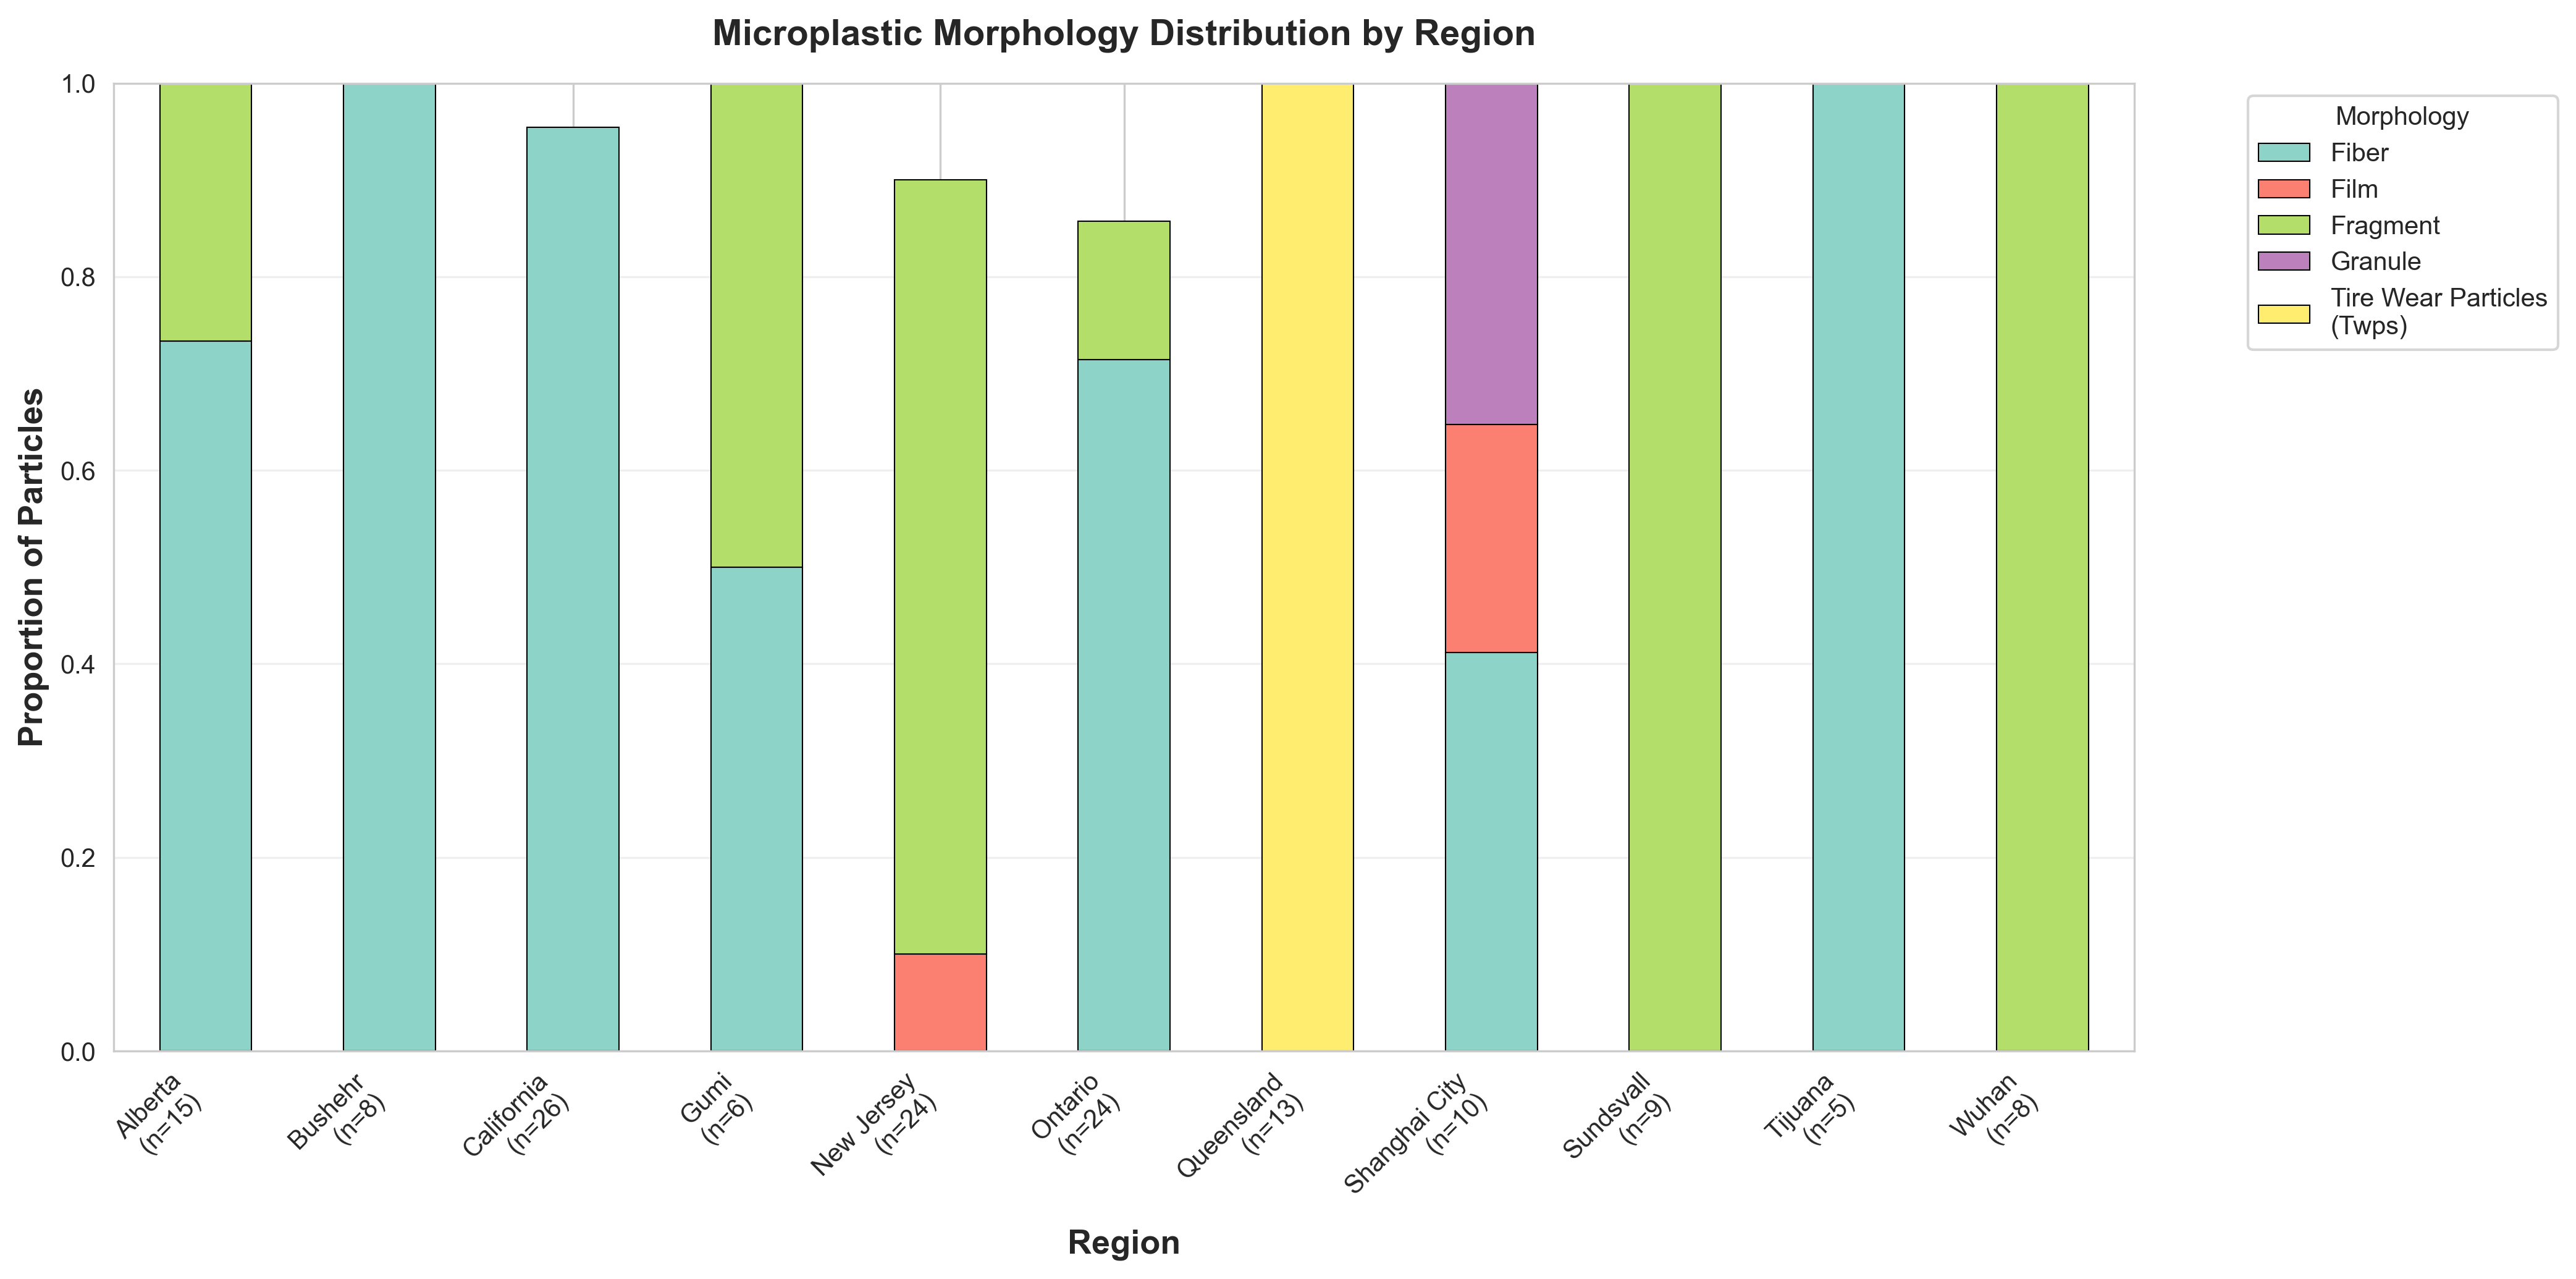


Morphology plot saved: morphology_by_region_corrected.png

POLYMER COMPOSITION ANALYSIS BY REGION

Total polymer records after explosion: 167
Unique polymers: 11

Overall polymer distribution:
polymer_list
PE           57
PP           56
SBR          13
PET          11
EPDM          9
Polyester     6
PS            4
PA            4
PVC           3
Acrylic       2
PU            2
Name: count, dtype: int64

POLYMER PROPORTIONS BY REGION (regions with n>=5)

California (n=26):
  PE: 66.7% (n=16)
  Polyester: 12.5% (n=3)
  PET: 12.5% (n=3)
  Acrylic: 4.2% (n=1)
  PP: 4.2% (n=1)

New Jersey (n=24):
  PE: 72.2% (n=13)
  PS: 11.1% (n=2)
  PU: 11.1% (n=2)
  PP: 5.6% (n=1)

Ontario (n=24):
  PP: 100.0% (n=18)

Alberta (n=15): No polymer data available

Queensland (n=13):
  SBR: 100.0% (n=13)

Shanghai City (n=10):
  PET: 63.6% (n=7)
  PE: 18.2% (n=2)
  PP: 18.2% (n=2)

Sundsvall (n=9):
  EPDM: 50.0% (n=9)
  PP: 50.0% (n=9)

Wuhan (n=8):
  PE: 50.0% (n=8)
  PP: 50.0% (n=8)

Bushehr (n=8): No po

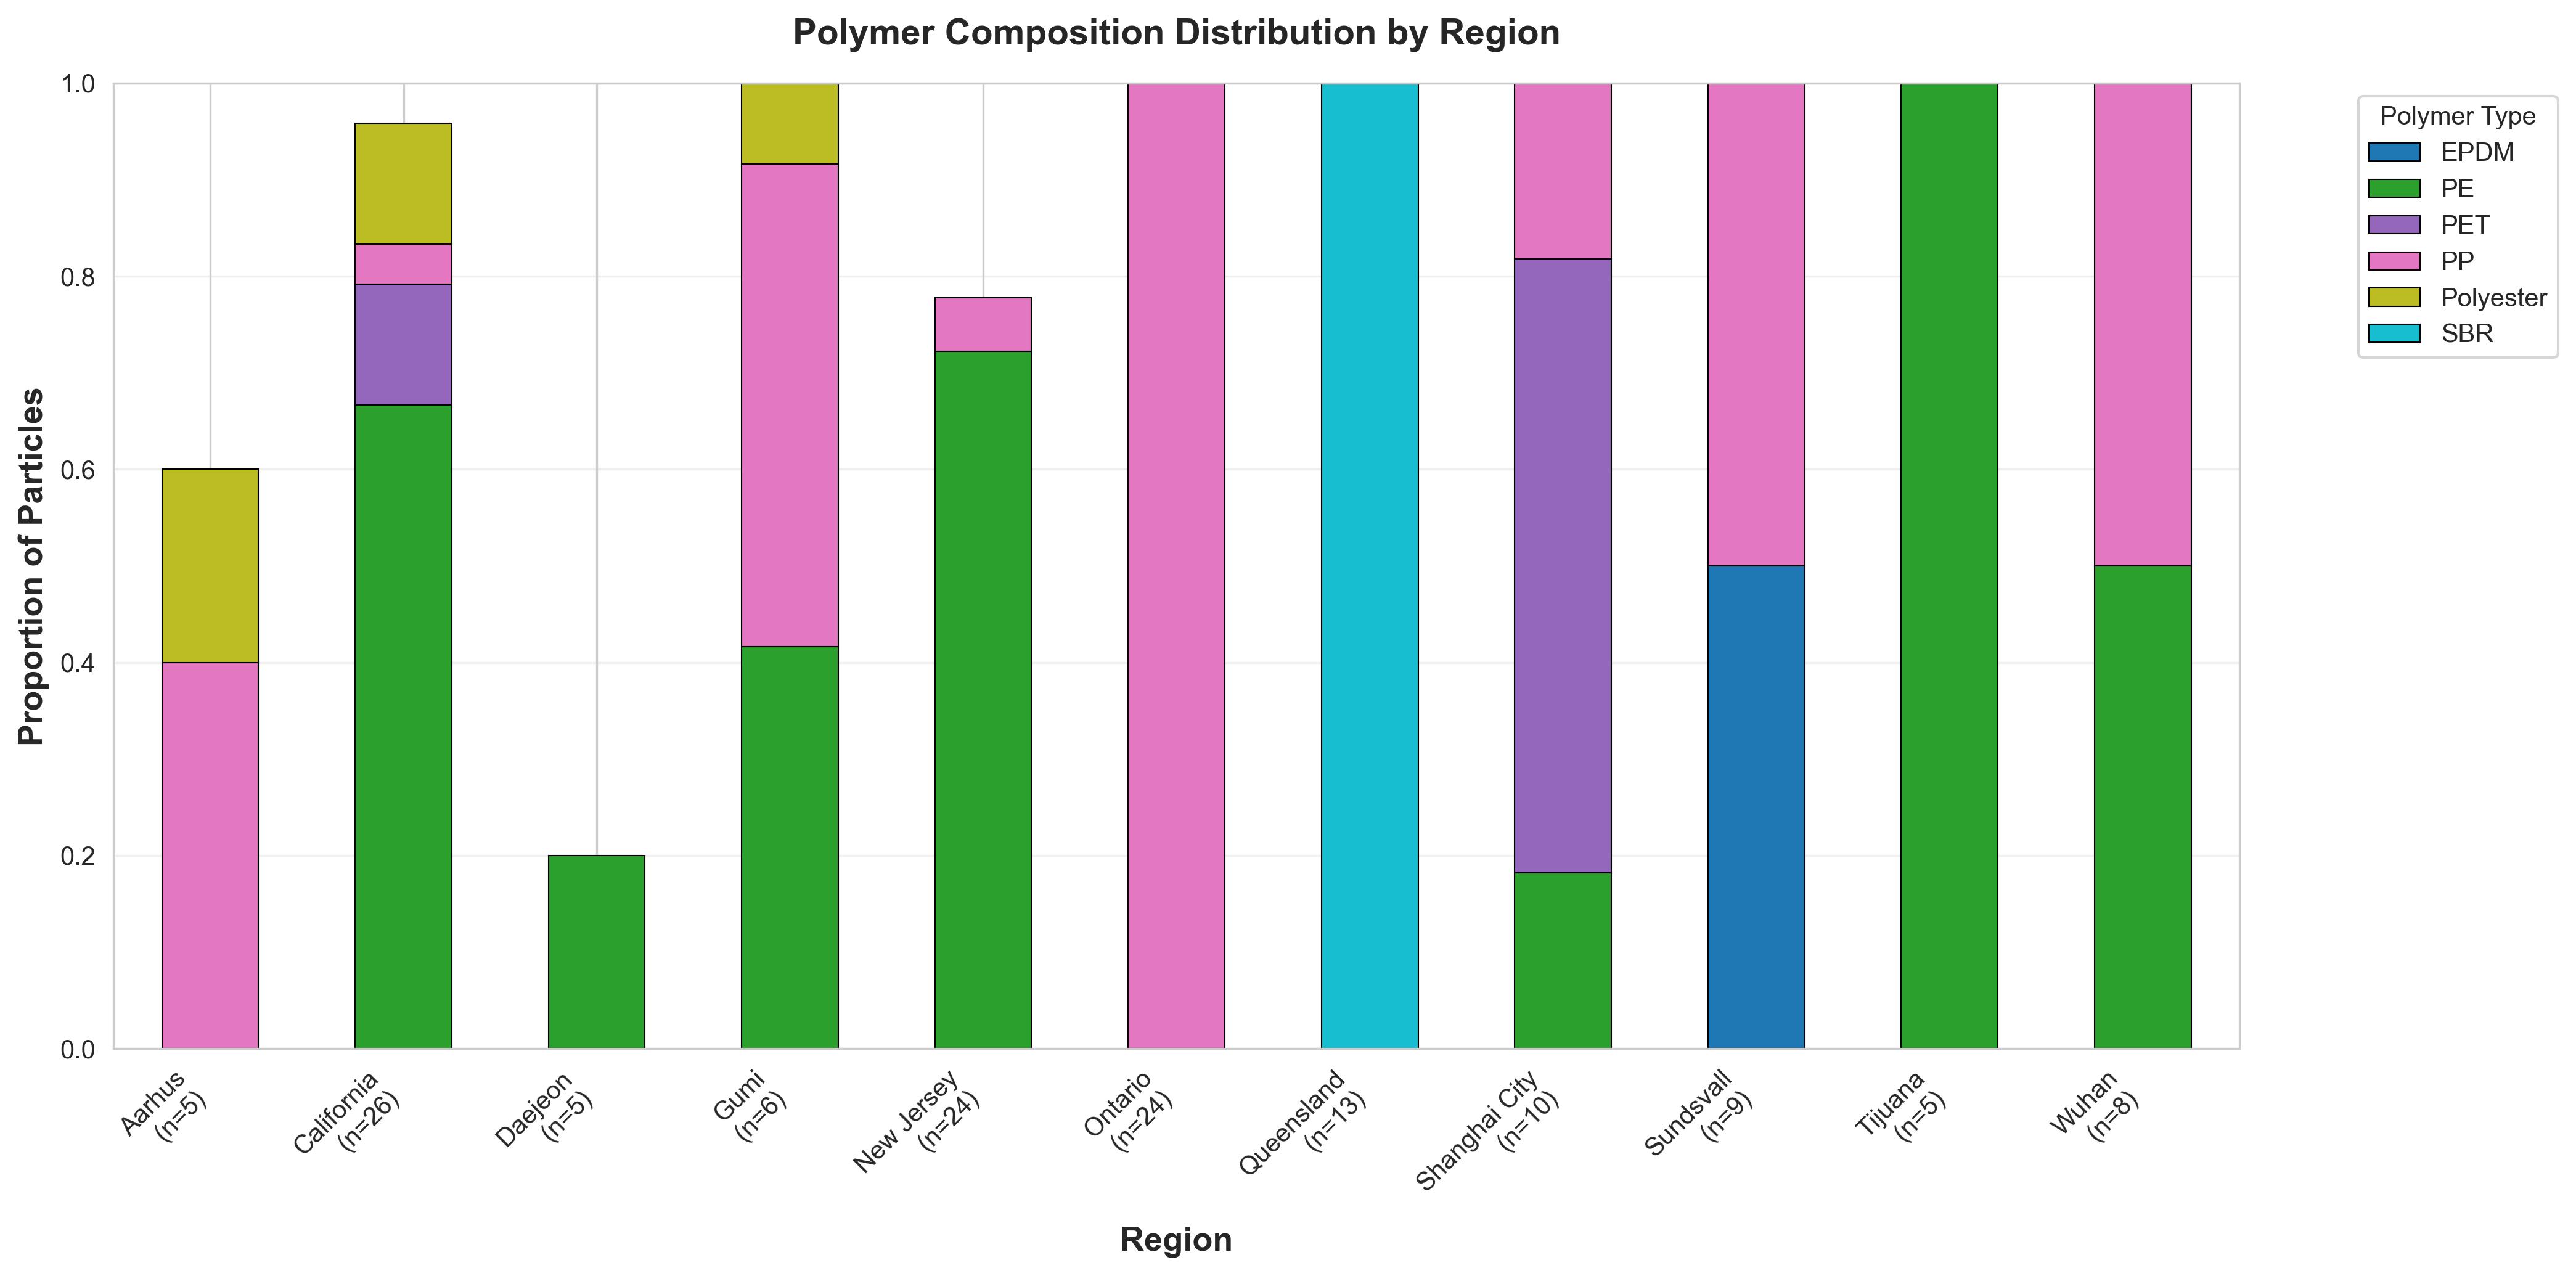


Polymer plot saved: polymer_by_region_corrected.png

STATISTICAL TESTS

Morphology distribution by region:
  Chi-square test: χ² = 350.15, df = 70, p = 7.211e-39
  → Morphology distribution DIFFERS significantly across regions

Polymer composition by region:
  Chi-square test: χ² = 518.50, df = 100, p = 9.733e-58
  → Polymer composition DIFFERS significantly across regions

ANALYSIS COMPLETE!

Generated files:
1. morphology_by_region_corrected.png
2. polymer_by_region_corrected.png


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# ============================================================================
# LOAD DATA
# ============================================================================
file_path = r"C:\Users\ai22h\OneDrive - Florida State University\Weekly Meeting_EA\MP Data Analysis_Experimental\My Database_Urban\Paper materials\Urban Runoff MP Database_072025.xlsx"

try:
    df = pd.read_excel(file_path, sheet_name="Urban Runoff MP Database", engine='openpyxl')
except:
    df = pd.read_excel(file_path, sheet_name=0)

df.columns = df.columns.str.strip()

# Get standardized concentration
conc_col = "Standardized Concentration (particles/L)"
df_clean = df[pd.to_numeric(df[conc_col], errors="coerce").notna()].copy()
df_clean[conc_col] = df_clean[conc_col].astype(float)

# Use Region column directly (already manually cleaned)
df_clean['Region'] = df_clean['Region'].astype(str).str.strip()
df_clean = df_clean[df_clean['Region'] != 'nan']

print(f"Total records: {len(df_clean)}")
print(f"\nRegion distribution:")
region_counts = df_clean['Region'].value_counts()
print(region_counts)

# ============================================================================
# MORPHOLOGY BY REGION
# ============================================================================
print("\n" + "="*80)
print("MORPHOLOGY ANALYSIS BY REGION")
print("="*80)

def split_shapes(x):
    """Split multiple shapes and standardize names"""
    if pd.isna(x):
        return []
    
    # Split on common separators
    parts = re.split(r'[;,/&]\s*|\s+and\s+', str(x).lower())
    
    # Mapping to standardize shape names
    shape_map = {
        'fiber': 'Fiber',
        'fibers': 'Fiber',
        'fibres': 'Fiber',
        'fragment': 'Fragment',
        'fragments': 'Fragment',
        'film': 'Film',
        'films': 'Film',
        'sphere': 'Sphere',
        'spheres': 'Sphere',
        'bead': 'Sphere',
        'beads': 'Sphere',
        'tire': 'Tire Wear Particle',
        'twp': 'Tire Wear Particle',
        'twps': 'Tire Wear Particle',
        'tire wear': 'Tire Wear Particle',
        'tire wear particle': 'Tire Wear Particle',
        'tire wear particles': 'Tire Wear Particle',
        'foam': 'Foam',
        'pellet': 'Pellet',
        'pellets': 'Pellet',
        'granule': 'Granule',
        'granules': 'Granule'
    }
    
    # Terms to exclude (non-shape descriptors)
    exclude_terms = ['not reported', 'not discussed', 'not', 'and', 'or', 'the']
    
    cleaned = []
    for part in parts:
        part = part.strip()
        # Skip excluded terms
        if part in exclude_terms or len(part) < 3:
            continue
        # Apply mapping
        if part in shape_map:
            cleaned.append(shape_map[part])
        elif part and 'rubber' not in part.lower():  # Keep meaningful terms, exclude "rubber" fragments
            # Capitalize properly
            cleaned.append(part.title())
    
    return cleaned if cleaned else []

# Apply shape splitting
if 'Dominant shape' in df_clean.columns:
    df_clean['shape_list'] = df_clean['Dominant shape'].apply(split_shapes)
    
    # Explode for counting
    df_shapes = df_clean.explode('shape_list')
    df_shapes = df_shapes[df_shapes['shape_list'].notna() & (df_shapes['shape_list'] != '')]
    
    print(f"\nTotal shape records after explosion: {len(df_shapes)}")
    print(f"Unique shapes: {df_shapes['shape_list'].nunique()}")
    print(f"\nOverall shape distribution:")
    print(df_shapes['shape_list'].value_counts())
    
    # Count by region (only regions with n>=5 for meaningful comparison)
    min_n_region = 5
    regions_to_analyze = region_counts[region_counts >= min_n_region].index
    
    df_shapes_filtered = df_shapes[df_shapes['Region'].isin(regions_to_analyze)].copy()
    
    # Calculate proportions by region
    shape_by_region = df_shapes_filtered.groupby(['Region', 'shape_list']).size().reset_index(name='count')
    region_totals_shapes = shape_by_region.groupby('Region')['count'].sum().reset_index(name='total')
    shape_by_region = shape_by_region.merge(region_totals_shapes, on='Region')
    shape_by_region['proportion'] = shape_by_region['count'] / shape_by_region['total']
    
    print(f"\n" + "="*80)
    print(f"MORPHOLOGY PROPORTIONS BY REGION (regions with n>={min_n_region})")
    print("="*80)
    
    for region in regions_to_analyze:
        region_data = shape_by_region[shape_by_region['Region'] == region].sort_values('proportion', ascending=False)
        print(f"\n{region} (n={region_counts[region]}):")
        for _, row in region_data.iterrows():
            print(f"  {row['shape_list']}: {row['proportion']*100:.1f}% (n={row['count']:.0f})")
    
    # PLOT 1: Stacked bar chart - Morphology by Region
    # Get top 5 most common shapes overall
    top_shapes = df_shapes['shape_list'].value_counts().head(5).index.tolist()
    
    # Create pivot table for top shapes
    shape_pivot = shape_by_region[shape_by_region['shape_list'].isin(top_shapes)].pivot(
        index='Region', 
        columns='shape_list', 
        values='proportion'
    ).fillna(0)
    
    # FIX: Only keep regions that actually have data in the pivot table
    available_regions = shape_pivot.index.tolist()
    print(f"\nRegions with morphology data for top shapes: {available_regions}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    shape_pivot.plot(
        kind='bar', 
        stacked=True, 
        ax=ax,
        colormap='Set3',
        edgecolor='black',
        linewidth=0.5
    )
    
    ax.set_xlabel('Region', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proportion of Particles', fontsize=13, fontweight='bold')
    ax.set_title('Microplastic Morphology Distribution by Region', fontsize=14, fontweight='bold', pad=15)
    ax.legend(title='Morphology', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add sample sizes to x-axis
    labels = [f'{region}\n(n={region_counts[region]})' for region in shape_pivot.index]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('morphology_by_region_corrected.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMorphology plot saved: morphology_by_region_corrected.png")

# ============================================================================
# POLYMER BY REGION
# ============================================================================
print("\n" + "="*80)
print("POLYMER COMPOSITION ANALYSIS BY REGION")
print("="*80)

def split_polymers(x):
    """Split multiple polymers and standardize names"""
    if pd.isna(x):
        return []
    
    text = str(x)
    
    # Skip non-polymer entries entirely
    skip_terms = ['not reported', 'not discussed', 'discussed', 'anthropogenic', 'dye-based', 
                  'cellulose', 'celleulose', 'bitumen', 'bitument', 'rubber (ru)', 'tire wear']
    
    if any(skip.lower() in text.lower() for skip in skip_terms):
        return []
    
    # Split on common separators
    parts = re.split(r'[;,/&]\s*|\s+and\s+', text)
    
    # Comprehensive polymer mapping - standardize to common abbreviations
    polymer_map = {
        # Polyethylene
        'pe': 'PE',
        'polyethylene': 'PE',
        'polyethylene (pe)': 'PE',
        
        # Polypropylene
        'pp': 'PP',
        'polypropylene': 'PP',
        'polypropylene (pp)': 'PP',
        
        # PET
        'pet': 'PET',
        'polyethylene terephthalate': 'PET',
        'polyethylene terephthalate (pet)': 'PET',
        'polyethylence terepthalate': 'PET',
        
        # Polystyrene
        'ps': 'PS',
        'polystyrene': 'PS',
        'polystyrene (ps)': 'PS',
        
        # PVC
        'pvc': 'PVC',
        'polyvinyl chloride': 'PVC',
        'polyvinyl chloride (pvc)': 'PVC',
        
        # SBR - Tire rubber
        'sbr': 'SBR',
        'styrene-butadiene rubber': 'SBR',
        'styrene butadiene rubber': 'SBR',
        'styrene-butadiene rubber (sbr)': 'SBR',
        
        # EPDM - Tire rubber
        'epdm': 'EPDM',
        'ethylene propylene diene monomer': 'EPDM',
        
        # Polyamide/Nylon
        'pa': 'PA',
        'polyamide': 'PA',
        'nylon': 'PA',
        'polyamide (pa)': 'PA',
        'nylon (pa)': 'PA',
        
        # Polyurethane
        'pu': 'PU',
        'polyurethane': 'PU',
        'polyurethane (pu)': 'PU',
        
        # Polyester
        'pes': 'Polyester',
        'polyester': 'Polyester',
        'polyester (pes)': 'Polyester',
        
        # Acrylic
        'acrylic': 'Acrylic',
        'polyacrylates': 'Acrylic',
        'polyacrylamide': 'Acrylic'
    }
    
    cleaned = []
    for part in parts:
        part = part.strip().lower()
        
        # Remove parenthetical content and extra spaces
        part = re.sub(r'\([^)]*\)', '', part).strip()
        part = re.sub(r'\s+', ' ', part)
        
        # Skip if too short or contains excluded terms
        if len(part) < 2:
            continue
        
        # Apply mapping
        if part in polymer_map:
            polymer = polymer_map[part]
            if polymer not in cleaned:  # Avoid duplicates
                cleaned.append(polymer)
    
    return cleaned if cleaned else []

# Apply polymer splitting
if 'Dominant polymer (s)' in df_clean.columns:
    df_clean['polymer_list'] = df_clean['Dominant polymer (s)'].apply(split_polymers)
    
    # Explode for counting
    df_polymers = df_clean.explode('polymer_list')
    df_polymers = df_polymers[df_polymers['polymer_list'].notna() & (df_polymers['polymer_list'] != '')]
    
    print(f"\nTotal polymer records after explosion: {len(df_polymers)}")
    print(f"Unique polymers: {df_polymers['polymer_list'].nunique()}")
    print(f"\nOverall polymer distribution:")
    print(df_polymers['polymer_list'].value_counts())
    
    # Count by region (only regions with n>=5)
    df_polymers_filtered = df_polymers[df_polymers['Region'].isin(regions_to_analyze)].copy()
    
    # Calculate proportions by region
    polymer_by_region = df_polymers_filtered.groupby(['Region', 'polymer_list']).size().reset_index(name='count')
    region_totals_polymer = polymer_by_region.groupby('Region')['count'].sum().reset_index(name='total')
    polymer_by_region = polymer_by_region.merge(region_totals_polymer, on='Region')
    polymer_by_region['proportion'] = polymer_by_region['count'] / polymer_by_region['total']
    
    print(f"\n" + "="*80)
    print(f"POLYMER PROPORTIONS BY REGION (regions with n>={min_n_region})")
    print("="*80)
    
    for region in regions_to_analyze:
        region_data = polymer_by_region[polymer_by_region['Region'] == region].sort_values('proportion', ascending=False)
        if len(region_data) > 0:
            print(f"\n{region} (n={region_counts[region]}):")
            for _, row in region_data.head(5).iterrows():  # Show top 5 polymers
                print(f"  {row['polymer_list']}: {row['proportion']*100:.1f}% (n={row['count']:.0f})")
        else:
            print(f"\n{region} (n={region_counts[region]}): No polymer data available")
    
    # PLOT 2: Stacked bar chart - Polymer by Region
    # Get top 6 most common polymers overall
    top_polymers = df_polymers['polymer_list'].value_counts().head(6).index.tolist()
    
    # Create pivot table for top polymers
    polymer_pivot = polymer_by_region[polymer_by_region['polymer_list'].isin(top_polymers)].pivot(
        index='Region', 
        columns='polymer_list', 
        values='proportion'
    ).fillna(0)
    
    # FIX: Only keep regions that actually have polymer data
    polymer_pivot = polymer_pivot[polymer_pivot.sum(axis=1) > 0]
    
    print(f"\nRegions with polymer data for top polymers: {polymer_pivot.index.tolist()}")
    
    if len(polymer_pivot) > 0:
        # Plot
        fig, ax = plt.subplots(figsize=(14, 7))
        polymer_pivot.plot(
            kind='bar', 
            stacked=True, 
            ax=ax,
            colormap='tab10',
            edgecolor='black',
            linewidth=0.5
        )
        
        ax.set_xlabel('Region', fontsize=13, fontweight='bold')
        ax.set_ylabel('Proportion of Particles', fontsize=13, fontweight='bold')
        ax.set_title('Polymer Composition Distribution by Region', fontsize=14, fontweight='bold', pad=15)
        ax.legend(title='Polymer Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.grid(axis='y', alpha=0.3)
        
        # Add sample sizes to x-axis
        labels = [f'{region}\n(n={region_counts[region]})' for region in polymer_pivot.index]
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('polymer_by_region_corrected.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nPolymer plot saved: polymer_by_region_corrected.png")
    else:
        print("\nInsufficient polymer data for visualization")

# ============================================================================
# STATISTICAL TESTS
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)

# Test if morphology distribution differs by region
if 'df_shapes_filtered' in locals() and len(df_shapes_filtered) > 0:
    contingency_table_shape = pd.crosstab(df_shapes_filtered['Region'], df_shapes_filtered['shape_list'])
    chi2_shape, p_shape, dof_shape, expected_shape = stats.chi2_contingency(contingency_table_shape)
    print(f"\nMorphology distribution by region:")
    print(f"  Chi-square test: χ² = {chi2_shape:.2f}, df = {dof_shape}, p = {p_shape:.3e}")
    if p_shape < 0.05:
        print("  → Morphology distribution DIFFERS significantly across regions")
    else:
        print("  → Morphology distribution does NOT differ significantly across regions")

# Test if polymer distribution differs by region
if 'df_polymers_filtered' in locals() and len(df_polymers_filtered) > 0:
    contingency_table_polymer = pd.crosstab(df_polymers_filtered['Region'], df_polymers_filtered['polymer_list'])
    chi2_polymer, p_polymer, dof_polymer, expected_polymer = stats.chi2_contingency(contingency_table_polymer)
    print(f"\nPolymer composition by region:")
    print(f"  Chi-square test: χ² = {chi2_polymer:.2f}, df = {dof_polymer}, p = {p_polymer:.3e}")
    if p_polymer < 0.05:
        print("  → Polymer composition DIFFERS significantly across regions")
    else:
        print("  → Polymer composition does NOT differ significantly across regions")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("1. morphology_by_region_corrected.png")
print("2. polymer_by_region_corrected.png")